# Imports and Data Loading

**Experiment**: <br>
1. Inputs : Min, max, Qty, modal at time t-0 and modal_price from time t-0 to t-30
2. Output : modal_price from t+1 to t+5
3. Models : Stacked Bi-Dir LSTM.
4. Hyperparameter Tuning

In [59]:
import numpy as np
import pandas as pd
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 15,8
from warnings import filterwarnings
filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as metrics
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Flatten, TimeDistributed, Dropout
#from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn.model_selection import GridSearchCV

In [60]:
import tensorflow as tf

In [61]:
from keras.optimizers import Adam, SGD, RMSprop

In [62]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [63]:
pip install scikeras[tensorflow]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [64]:
from scikeras.wrappers import KerasRegressor

In [65]:
from google. colab import drive
drive.mount ('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [66]:
df_tomato = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Tomato_Kolar_2020_23.xlsx')
df_tomato.shape

(1163, 10)

In [67]:
df_tomato.head(5)

,state,district,market,commodity,variety,arrival_date,min_price,max_price,modal_price,quantity
0,Karnataka,Kolar,Kolar,Tomato,Tomato,2023-01-01,400,1330,730,6224
1,Karnataka,Kolar,Kolar,Tomato,Tomato,2023-01-02,400,1670,930,4439
2,Karnataka,Kolar,Kolar,Tomato,Tomato,2023-01-03,400,1670,930,5983
3,Karnataka,Kolar,Kolar,Tomato,Tomato,2023-01-04,330,1330,800,7830
4,Karnataka,Kolar,Kolar,Tomato,Tomato,2023-01-05,330,1200,530,6310


# EDA

In [68]:
df_tomato_2 = df_tomato.set_index('arrival_date',drop=True, verify_integrity=True)

In [69]:
df_tomato_2.sort_index(axis=1)

,commodity,district,market,max_price,min_price,modal_price,quantity,state,variety
arrival_date,,,,,,,,,
2023-01-01,Tomato,Kolar,Kolar,1330,400,730,6224,Karnataka,Tomato
2023-01-02,Tomato,Kolar,Kolar,1670,400,930,4439,Karnataka,Tomato
2023-01-03,Tomato,Kolar,Kolar,1670,400,930,5983,Karnataka,Tomato
2023-01-04,Tomato,Kolar,Kolar,1330,330,800,7830,Karnataka,Tomato
2023-01-05,Tomato,Kolar,Kolar,1200,330,530,6310,Karnataka,Tomato
...,...,...,...,...,...,...,...,...,...
2020-12-26,Tomato,Kolar,Kolar,1667,333,933,12250,Karnataka,Tomato
2020-12-27,Tomato,Kolar,Kolar,2000,667,1200,8530,Karnataka,Tomato
2020-12-28,Tomato,Kolar,Kolar,1733,400,1000,10794,Karnataka,Tomato


In [70]:
df_tomato_2 = df_tomato_2.drop(['state','district', 'market', 'commodity', 'variety'], axis=1)
df_tomato_2.head()

,min_price,max_price,modal_price,quantity
arrival_date,,,,
2023-01-01,400,1330,730,6224
2023-01-02,400,1670,930,4439
2023-01-03,400,1670,930,5983
2023-01-04,330,1330,800,7830
2023-01-05,330,1200,530,6310


In [71]:
df_tomato_2.isnull().sum()

min_price      0
max_price      0
modal_price    0
quantity       0
dtype: int64

In [72]:
cor_matrix = df_tomato_2.corr()

Text(0.5, 1.0, 'Heat map of correlation between features')

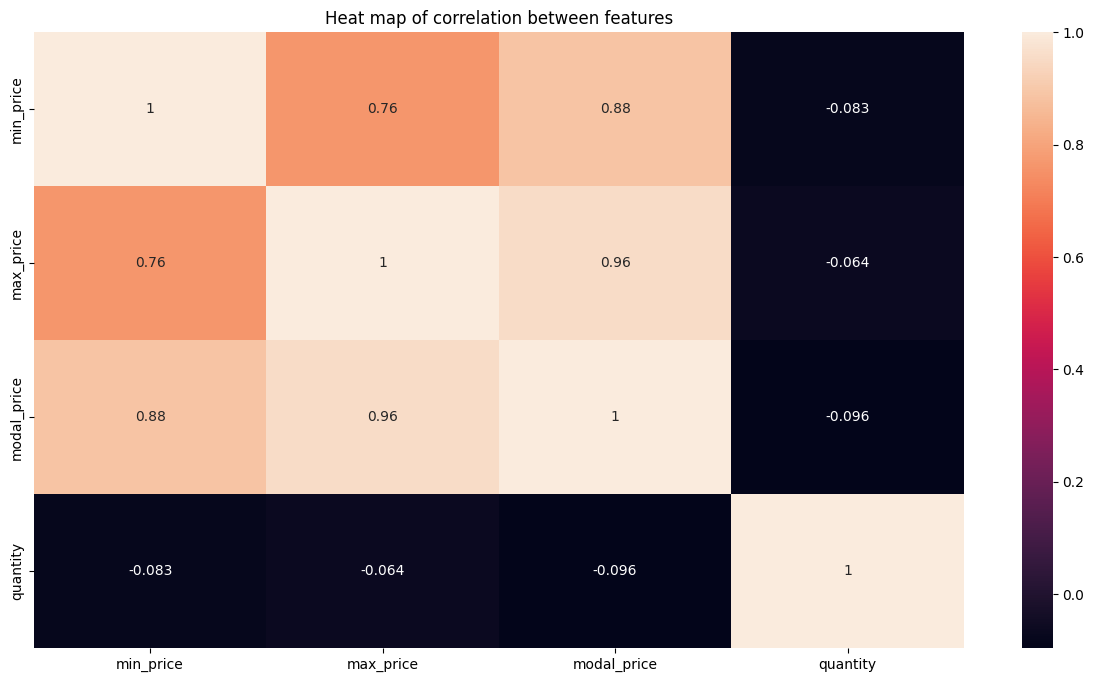

In [73]:
sns.heatmap(cor_matrix,annot=True)
plt.title("Heat map of correlation between features")

In [74]:
# Drop min_price and max_price because of hig auto-correlation 
# df_tomato_3 = df_tomato_2.drop(['min_price','max_price'], axis=1)
# df_tomato_3.head()

In [75]:
df_tomato_2.head()

,min_price,max_price,modal_price,quantity
arrival_date,,,,
2023-01-01,400,1330,730,6224
2023-01-02,400,1670,930,4439
2023-01-03,400,1670,930,5983
2023-01-04,330,1330,800,7830
2023-01-05,330,1200,530,6310


In [76]:
# Creating a new dataset and Sorting in ascending order of time series
df_tomato_3 = df_tomato_2[['quantity','min_price','max_price','modal_price']]
df_tomato_3.sort_index(ascending=True,inplace=True)
df_tomato_3.head()

,quantity,min_price,max_price,modal_price
arrival_date,,,,
2020-01-01,4144,333,1467,733
2020-01-02,4430,333,1733,986
2020-01-03,4532,400,2000,1047
2020-01-04,5578,333,2000,1033
2020-01-05,4960,333,2000,1033


# Preparing the dataset for training

### Creating Feature variable

In [77]:
# Function to create as many as features to represent the window size
def createWindow(winSize):
  df_temp = pd.DataFrame()
  for i in range(1,winSize+1):
    df_temp["feature_t"+str(i+1)] = df_tomato_3['modal_price'].shift(i)
  return df_temp

In [78]:
# Generating new features
df_newCols = createWindow(30)
df_newCols.head()

,feature_t2,feature_t3,feature_t4,feature_t5,feature_t6,feature_t7,feature_t8,feature_t9,feature_t10,feature_t11,...,feature_t22,feature_t23,feature_t24,feature_t25,feature_t26,feature_t27,feature_t28,feature_t29,feature_t30,feature_t31
arrival_date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,733.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,986.0,733.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,1047.0,986.0,733.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,1033.0,1047.0,986.0,733.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
# joining with base dataframe
df_tomato_4 = df_tomato_3.join(df_newCols)
df_tomato_4.head()

,quantity,min_price,max_price,modal_price,feature_t2,feature_t3,feature_t4,feature_t5,feature_t6,feature_t7,...,feature_t22,feature_t23,feature_t24,feature_t25,feature_t26,feature_t27,feature_t28,feature_t29,feature_t30,feature_t31
arrival_date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,4144,333,1467,733,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,4430,333,1733,986,733.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,4532,400,2000,1047,986.0,733.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,5578,333,2000,1033,1047.0,986.0,733.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,4960,333,2000,1033,1033.0,1047.0,986.0,733.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
# Replacing null values with 0, thus created window of 30 days as each input.
for val in df_tomato_4.columns:
  df_tomato_4[val].fillna(0, inplace=True)
df_tomato_4.head()

,quantity,min_price,max_price,modal_price,feature_t2,feature_t3,feature_t4,feature_t5,feature_t6,feature_t7,...,feature_t22,feature_t23,feature_t24,feature_t25,feature_t26,feature_t27,feature_t28,feature_t29,feature_t30,feature_t31
arrival_date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,4144,333,1467,733,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-02,4430,333,1733,986,733.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-03,4532,400,2000,1047,986.0,733.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-04,5578,333,2000,1033,1047.0,986.0,733.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-05,4960,333,2000,1033,1033.0,1047.0,986.0,733.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Creating Target Variable

In [81]:
# Creating target Variables
def createTargets(winSize):
  df_temp = pd.DataFrame()
  for i in range(1,winSize+1):
    df_temp["target_t"+str(i)] = df_tomato_3['modal_price'].shift(-i)
  return df_temp

In [82]:
# Generating target columns
df_newTargetCols = createTargets(5)
df_newTargetCols.head()

,target_t1,target_t2,target_t3,target_t4,target_t5
arrival_date,,,,,
2020-01-01,986.0,1047.0,1033.0,1033.0,1046.0
2020-01-02,1047.0,1033.0,1033.0,1046.0,1153.0
2020-01-03,1033.0,1033.0,1046.0,1153.0,933.0
2020-01-04,1033.0,1046.0,1153.0,933.0,1133.0
2020-01-05,1046.0,1153.0,933.0,1133.0,933.0


In [83]:
# joining with base dataframe
df_tomato_4 = df_tomato_4.join(df_newTargetCols)
df_tomato_4.head()

,quantity,min_price,max_price,modal_price,feature_t2,feature_t3,feature_t4,feature_t5,feature_t6,feature_t7,...,feature_t27,feature_t28,feature_t29,feature_t30,feature_t31,target_t1,target_t2,target_t3,target_t4,target_t5
arrival_date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,4144,333,1467,733,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,986.0,1047.0,1033.0,1033.0,1046.0
2020-01-02,4430,333,1733,986,733.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1047.0,1033.0,1033.0,1046.0,1153.0
2020-01-03,4532,400,2000,1047,986.0,733.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1033.0,1033.0,1046.0,1153.0,933.0
2020-01-04,5578,333,2000,1033,1047.0,986.0,733.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1033.0,1046.0,1153.0,933.0,1133.0
2020-01-05,4960,333,2000,1033,1033.0,1047.0,986.0,733.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1046.0,1153.0,933.0,1133.0,933.0


In [84]:
# Drop all the null values
df_tomato_4.dropna(inplace=True)
df_tomato_4

,quantity,min_price,max_price,modal_price,feature_t2,feature_t3,feature_t4,feature_t5,feature_t6,feature_t7,...,feature_t27,feature_t28,feature_t29,feature_t30,feature_t31,target_t1,target_t2,target_t3,target_t4,target_t5
arrival_date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,4144,333,1467,733,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,986.0,1047.0,1033.0,1033.0,1046.0
2020-01-02,4430,333,1733,986,733.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1047.0,1033.0,1033.0,1046.0,1153.0
2020-01-03,4532,400,2000,1047,986.0,733.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1033.0,1033.0,1046.0,1153.0,933.0
2020-01-04,5578,333,2000,1033,1047.0,986.0,733.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1033.0,1046.0,1153.0,933.0,1133.0
2020-01-05,4960,333,2000,1033,1033.0,1047.0,986.0,733.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1046.0,1153.0,933.0,1133.0,933.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,2874,400,1800,1000,1200.0,1130.0,1000.0,1000.0,1000.0,1200.0,...,1070.0,1000.0,930.0,1070.0,1000.0,1270.0,1200.0,1000.0,930.0,870.0
2023-03-10,3506,530,2000,1270,1000.0,1200.0,1130.0,1000.0,1000.0,1000.0,...,1200.0,1070.0,1000.0,930.0,1070.0,1200.0,1000.0,930.0,870.0,930.0
2023-03-11,3698,400,1870,1200,1270.0,1000.0,1200.0,1130.0,1000.0,1000.0,...,1200.0,1200.0,1070.0,1000.0,930.0,1000.0,930.0,870.0,930.0,730.0


### Scaling

In [85]:
# Preprocessing the dataset
# Extract the values from the DataFrame
data_to_scale = df_tomato_4.copy()
# Initialize the scaler
scaler = MinMaxScaler()
# Fit the scaler to the data
scaler.fit(data_to_scale)
# Transform the data
scaled_data = scaler.transform(data_to_scale)
# convert the scaled_data array back to a DataFrame with Timestamp index
scaled_data_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns, index=data_to_scale.index)
# combine the scaled data with the Timestamp index column
# scaled_data_df = pd.concat([df_tomato_3.index.to_frame(), scaled_data_df], axis=1)
scaled_data_df.head()

,quantity,min_price,max_price,modal_price,feature_t2,feature_t3,feature_t4,feature_t5,feature_t6,feature_t7,...,feature_t27,feature_t28,feature_t29,feature_t30,feature_t31,target_t1,target_t2,target_t3,target_t4,target_t5
arrival_date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,0.076304,0.068107,0.129021,0.091897,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.135517,0.146034,0.143621,0.143621,0.145862
2020-01-02,0.083274,0.068107,0.161185,0.135517,0.122167,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.146034,0.143621,0.143621,0.145862,0.164310
2020-01-03,0.085760,0.085133,0.193470,0.146034,0.164333,0.122167,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.143621,0.143621,0.145862,0.164310,0.126379
2020-01-04,0.111252,0.068107,0.193470,0.143621,0.174500,0.164333,0.122167,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.143621,0.145862,0.164310,0.126379,0.160862
2020-01-05,0.096191,0.068107,0.193470,0.143621,0.172167,0.174500,0.164333,0.122167,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.145862,0.164310,0.126379,0.160862,0.126379


### Train Test Split

In [86]:
# Split the data into train and test sets
train_size = int(len(scaled_data_df) * 0.8)
train_data = scaled_data_df[:train_size]
test_data = scaled_data_df[train_size:]

In [87]:
# Splitting target and feature variables
train_X = train_data.drop(columns=['target_t1','target_t2','target_t3','target_t4','target_t5'],axis=1)
train_y = train_data[['target_t1','target_t2','target_t3','target_t4','target_t5']]

test_X = test_data.drop(columns=['target_t1','target_t2','target_t3','target_t4','target_t5'],axis=1)
test_y = test_data[['target_t1','target_t2','target_t3','target_t4','target_t5']]

In [88]:
# Converting Dataframe to 3D array
vec_train_X = train_X.values
vec_train_y = train_y.values

vec_test_X = test_X.values
vec_test_y = test_y.values

In [89]:
# reshape input to be 3D [samples, look_back, features]
# samples -> are the number of rows in your data set
# look_back -> number of times to feed in the model or LSTM
# features -> number of columns of each sample

vec_train_X = vec_train_X.reshape((int(train_X.shape[0]), 17, 2))
vec_test_X = vec_test_X.reshape((int(test_X.shape[0]), 17, 2))

In [90]:
# Verifying the shape of train and test
print(vec_train_X.shape, vec_train_y.shape, vec_test_X.shape, vec_test_y.shape)

(926, 17, 2) (926, 5) (232, 17, 2) (232, 5)


# Model - Stacked Bi-Directional LSTM

## Model building

In [91]:
# Function to create model, required for KerasClassifier
def create_model():
  # create model
  model_Stacked_biDir = Sequential()
  model_Stacked_biDir.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True),
                                        input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
  model_Stacked_biDir.add(Dropout(0.2, input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
  model_Stacked_biDir.add(Bidirectional(LSTM(50, activation='relu')))
  model_Stacked_biDir.add(Dropout(0.2))
  model_Stacked_biDir.add(Dense(vec_train_y.shape[1]))
  # Compile model
  model_Stacked_biDir.compile(optimizer='adam', loss='mae', metrics=['mean_absolute_error'])
  return model_Stacked_biDir

In [92]:
# Define the callback function
calls=[
    EarlyStopping(monitor='mae', patience=10), 
    ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks', monitor='mae', save_best_only=True, mode='auto', save_freq=1)
    ]

In [93]:
# create model
lstm_regressor = KerasRegressor(build_fn=create_model, callbacks=calls)

## Hyperparameter Tuning - Batch Size

### Hyperparameter Tuning

In [ ]:
# define the grid search parameters
#batch_size = [50, 100, 200]
#epochs = [300, 500]
#param_grid = dict(batch_size=batch_size, epochs=epochs)

In [35]:
# define the grid search parameters
optimizers = ['adam']#['rmsprop', 'adam', 'SGD']
batches = [50, 100, 250, 500, 1000]
epoch_values = [100] #[100, 250, 500]
lr_values = [0.01] #[0.001, 0.01, 0.1, 0.2, 0.3]
momentum_values = [0.2] #[0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

param_grid = dict(optimizer = optimizers, 
                  epochs = epoch_values, 
                  batch_size = batches,
                  optimizer__learning_rate = lr_values,
                  optimizer__momentum = momentum_values
                  )

In [36]:
# Initialising the GridSearchCV
grid = GridSearchCV(estimator=lstm_regressor, param_grid=param_grid, n_jobs=-1, cv=3)

In [37]:
# Fitting the model
grid_result = grid.fit(vec_train_X, vec_train_y, validation_data = (vec_test_X, vec_test_y), callbacks=calls)

Epoch 1/100


1/4 [======>.......................] - ETA: 14s - loss: 0.1634 - mean_absolute_error: 0.1634

2/4 [==============>...............] - ETA: 0s - loss: 0.1584 - mean_absolute_error: 0.1584 

3/4 [=====================>........] - ETA: 0s - loss: 0.1586 - mean_absolute_error: 0.1586

4/4 [==============================] - ETA: 0s - loss: 0.1608 - mean_absolute_error: 0.1608

4/4 [==============================] - 6s 278ms/step - loss: 0.1608 - mean_absolute_error: 0.1608 - val_loss: 0.1138 - val_mean_absolute_error: 0.1138
Epoch 2/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1290 - mean_absolute_error: 0.1290

2/4 [==============>...............] - ETA: 0s - loss: 0.1266 - mean_absolute_error: 0.1266

3/4 [=====================>........] - ETA: 0s - loss: 0.1237 - mean_absolute_error: 0.1237

4/4 [==============================] - ETA: 0s - loss: 0.1218 - mean_absolute_error: 0.1218

4/4 [==============================] - 0s 99ms/step - loss: 0.1218 - mean_absolute_error: 0.1218 - val_loss: 0.0710 - val_mean_absolute_error: 0.0710
Epoch 3/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0992 - mean_absolute_error: 0.0992

2/4 [==============>...............] - ETA: 0s - loss: 0.0936 - mean_absolute_error: 0.0936

3/4 [=====================>........] - ETA: 0s - loss: 0.0921 - mean_absolute_error: 0.0921

4/4 [==============================] - ETA: 0s - loss: 0.0910 - mean_absolute_error: 0.0910

4/4 [==============================] - 0s 110ms/step - loss: 0.0910 - mean_absolute_error: 0.0910 - val_loss: 0.0499 - val_mean_absolute_error: 0.0499
Epoch 4/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0856 - mean_absolute_error: 0.0856

2/4 [==============>...............] - ETA: 0s - loss: 0.0872 - mean_absolute_error: 0.0872

3/4 [=====================>........] - ETA: 0s - loss: 0.0853 - mean_absolute_error: 0.0853

4/4 [==============================] - ETA: 0s - loss: 0.0857 - mean_absolute_error: 0.0857

4/4 [==============================] - 0s 111ms/step - loss: 0.0857 - mean_absolute_error: 0.0857 - val_loss: 0.0511 - val_mean_absolute_error: 0.0511
Epoch 5/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0791 - mean_absolute_error: 0.0791

2/4 [==============>...............] - ETA: 0s - loss: 0.0811 - mean_absolute_error: 0.0811

3/4 [=====================>........] - ETA: 0s - loss: 0.0828 - mean_absolute_error: 0.0828

4/4 [==============================] - ETA: 0s - loss: 0.0821 - mean_absolute_error: 0.0821

4/4 [==============================] - 0s 110ms/step - loss: 0.0821 - mean_absolute_error: 0.0821 - val_loss: 0.0487 - val_mean_absolute_error: 0.0487
Epoch 6/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0805 - mean_absolute_error: 0.0805

2/4 [==============>...............] - ETA: 0s - loss: 0.0796 - mean_absolute_error: 0.0796

3/4 [=====================>........] - ETA: 0s - loss: 0.0792 - mean_absolute_error: 0.0792

4/4 [==============================] - ETA: 0s - loss: 0.0786 - mean_absolute_error: 0.0786

4/4 [==============================] - 0s 99ms/step - loss: 0.0786 - mean_absolute_error: 0.0786 - val_loss: 0.0498 - val_mean_absolute_error: 0.0498
Epoch 7/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0765 - mean_absolute_error: 0.0765

2/4 [==============>...............] - ETA: 0s - loss: 0.0757 - mean_absolute_error: 0.0757

3/4 [=====================>........] - ETA: 0s - loss: 0.0745 - mean_absolute_error: 0.0745

4/4 [==============================] - ETA: 0s - loss: 0.0749 - mean_absolute_error: 0.0749

4/4 [==============================] - 0s 97ms/step - loss: 0.0749 - mean_absolute_error: 0.0749 - val_loss: 0.0471 - val_mean_absolute_error: 0.0471
Epoch 8/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0701 - mean_absolute_error: 0.0701

2/4 [==============>...............] - ETA: 0s - loss: 0.0719 - mean_absolute_error: 0.0719

3/4 [=====================>........] - ETA: 0s - loss: 0.0713 - mean_absolute_error: 0.0713

4/4 [==============================] - ETA: 0s - loss: 0.0712 - mean_absolute_error: 0.0712

4/4 [==============================] - 0s 104ms/step - loss: 0.0712 - mean_absolute_error: 0.0712 - val_loss: 0.0445 - val_mean_absolute_error: 0.0445
Epoch 9/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0764 - mean_absolute_error: 0.0764

2/4 [==============>...............] - ETA: 0s - loss: 0.0687 - mean_absolute_error: 0.0687

3/4 [=====================>........] - ETA: 0s - loss: 0.0682 - mean_absolute_error: 0.0682

4/4 [==============================] - ETA: 0s - loss: 0.0668 - mean_absolute_error: 0.0668

4/4 [==============================] - 0s 103ms/step - loss: 0.0668 - mean_absolute_error: 0.0668 - val_loss: 0.0461 - val_mean_absolute_error: 0.0461
Epoch 10/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0669 - mean_absolute_error: 0.0669

2/4 [==============>...............] - ETA: 0s - loss: 0.0646 - mean_absolute_error: 0.0646

3/4 [=====================>........] - ETA: 0s - loss: 0.0655 - mean_absolute_error: 0.0655

4/4 [==============================] - ETA: 0s - loss: 0.0656 - mean_absolute_error: 0.0656

4/4 [==============================] - 0s 95ms/step - loss: 0.0656 - mean_absolute_error: 0.0656 - val_loss: 0.0484 - val_mean_absolute_error: 0.0484
Epoch 11/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.0617

2/4 [==============>...............] - ETA: 0s - loss: 0.0634 - mean_absolute_error: 0.0634

3/4 [=====================>........] - ETA: 0s - loss: 0.0630 - mean_absolute_error: 0.0630

4/4 [==============================] - ETA: 0s - loss: 0.0629 - mean_absolute_error: 0.0629

4/4 [==============================] - 0s 110ms/step - loss: 0.0629 - mean_absolute_error: 0.0629 - val_loss: 0.0453 - val_mean_absolute_error: 0.0453
Epoch 12/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0665 - mean_absolute_error: 0.0665

2/4 [==============>...............] - ETA: 0s - loss: 0.0642 - mean_absolute_error: 0.0642

3/4 [=====================>........] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.0620

4/4 [==============================] - ETA: 0s - loss: 0.0612 - mean_absolute_error: 0.0612

4/4 [==============================] - 0s 103ms/step - loss: 0.0612 - mean_absolute_error: 0.0612 - val_loss: 0.0428 - val_mean_absolute_error: 0.0428
Epoch 13/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0592 - mean_absolute_error: 0.0592

2/4 [==============>...............] - ETA: 0s - loss: 0.0576 - mean_absolute_error: 0.0576

3/4 [=====================>........] - ETA: 0s - loss: 0.0585 - mean_absolute_error: 0.0585

4/4 [==============================] - ETA: 0s - loss: 0.0593 - mean_absolute_error: 0.0593

4/4 [==============================] - 0s 102ms/step - loss: 0.0593 - mean_absolute_error: 0.0593 - val_loss: 0.0447 - val_mean_absolute_error: 0.0447
Epoch 14/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0637 - mean_absolute_error: 0.0637

2/4 [==============>...............] - ETA: 0s - loss: 0.0583 - mean_absolute_error: 0.0583

3/4 [=====================>........] - ETA: 0s - loss: 0.0584 - mean_absolute_error: 0.0584

4/4 [==============================] - ETA: 0s - loss: 0.0573 - mean_absolute_error: 0.0573

4/4 [==============================] - 0s 101ms/step - loss: 0.0573 - mean_absolute_error: 0.0573 - val_loss: 0.0411 - val_mean_absolute_error: 0.0411
Epoch 15/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0574 - mean_absolute_error: 0.0574

2/4 [==============>...............] - ETA: 0s - loss: 0.0578 - mean_absolute_error: 0.0578

3/4 [=====================>........] - ETA: 0s - loss: 0.0573 - mean_absolute_error: 0.0573

4/4 [==============================] - ETA: 0s - loss: 0.0553 - mean_absolute_error: 0.0553

4/4 [==============================] - 0s 111ms/step - loss: 0.0553 - mean_absolute_error: 0.0553 - val_loss: 0.0396 - val_mean_absolute_error: 0.0396
Epoch 16/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0523 - mean_absolute_error: 0.0523

2/4 [==============>...............] - ETA: 0s - loss: 0.0539 - mean_absolute_error: 0.0539

3/4 [=====================>........] - ETA: 0s - loss: 0.0555 - mean_absolute_error: 0.0555

4/4 [==============================] - ETA: 0s - loss: 0.0549 - mean_absolute_error: 0.0549

4/4 [==============================] - 0s 100ms/step - loss: 0.0549 - mean_absolute_error: 0.0549 - val_loss: 0.0396 - val_mean_absolute_error: 0.0396
Epoch 17/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0527 - mean_absolute_error: 0.0527

2/4 [==============>...............] - ETA: 0s - loss: 0.0533 - mean_absolute_error: 0.0533

3/4 [=====================>........] - ETA: 0s - loss: 0.0526 - mean_absolute_error: 0.0526

4/4 [==============================] - ETA: 0s - loss: 0.0522 - mean_absolute_error: 0.0522

4/4 [==============================] - 0s 102ms/step - loss: 0.0522 - mean_absolute_error: 0.0522 - val_loss: 0.0372 - val_mean_absolute_error: 0.0372
Epoch 18/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0472 - mean_absolute_error: 0.0472

2/4 [==============>...............] - ETA: 0s - loss: 0.0495 - mean_absolute_error: 0.0495

3/4 [=====================>........] - ETA: 0s - loss: 0.0502 - mean_absolute_error: 0.0502

4/4 [==============================] - ETA: 0s - loss: 0.0506 - mean_absolute_error: 0.0506

4/4 [==============================] - 0s 108ms/step - loss: 0.0506 - mean_absolute_error: 0.0506 - val_loss: 0.0358 - val_mean_absolute_error: 0.0358
Epoch 19/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0455 - mean_absolute_error: 0.0455

2/4 [==============>...............] - ETA: 0s - loss: 0.0485 - mean_absolute_error: 0.0485

3/4 [=====================>........] - ETA: 0s - loss: 0.0484 - mean_absolute_error: 0.0484

4/4 [==============================] - ETA: 0s - loss: 0.0482 - mean_absolute_error: 0.0482

4/4 [==============================] - 0s 104ms/step - loss: 0.0482 - mean_absolute_error: 0.0482 - val_loss: 0.0341 - val_mean_absolute_error: 0.0341
Epoch 20/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0448 - mean_absolute_error: 0.0448

2/4 [==============>...............] - ETA: 0s - loss: 0.0464 - mean_absolute_error: 0.0464

3/4 [=====================>........] - ETA: 0s - loss: 0.0452 - mean_absolute_error: 0.0452

4/4 [==============================] - ETA: 0s - loss: 0.0460 - mean_absolute_error: 0.0460

4/4 [==============================] - 0s 101ms/step - loss: 0.0460 - mean_absolute_error: 0.0460 - val_loss: 0.0331 - val_mean_absolute_error: 0.0331
Epoch 21/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0444 - mean_absolute_error: 0.0444

2/4 [==============>...............] - ETA: 0s - loss: 0.0466 - mean_absolute_error: 0.0466

3/4 [=====================>........] - ETA: 0s - loss: 0.0457 - mean_absolute_error: 0.0457

4/4 [==============================] - ETA: 0s - loss: 0.0447 - mean_absolute_error: 0.0447

4/4 [==============================] - 1s 161ms/step - loss: 0.0447 - mean_absolute_error: 0.0447 - val_loss: 0.0329 - val_mean_absolute_error: 0.0329
Epoch 22/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0424 - mean_absolute_error: 0.0424

2/4 [==============>...............] - ETA: 0s - loss: 0.0427 - mean_absolute_error: 0.0427

3/4 [=====================>........] - ETA: 0s - loss: 0.0415 - mean_absolute_error: 0.0415

4/4 [==============================] - ETA: 0s - loss: 0.0425 - mean_absolute_error: 0.0425

4/4 [==============================] - 1s 188ms/step - loss: 0.0425 - mean_absolute_error: 0.0425 - val_loss: 0.0335 - val_mean_absolute_error: 0.0335
Epoch 23/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0472 - mean_absolute_error: 0.0472

2/4 [==============>...............] - ETA: 0s - loss: 0.0451 - mean_absolute_error: 0.0451

3/4 [=====================>........] - ETA: 0s - loss: 0.0432 - mean_absolute_error: 0.0432

4/4 [==============================] - ETA: 0s - loss: 0.0422 - mean_absolute_error: 0.0422

4/4 [==============================] - 1s 184ms/step - loss: 0.0422 - mean_absolute_error: 0.0422 - val_loss: 0.0337 - val_mean_absolute_error: 0.0337
Epoch 24/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0468 - mean_absolute_error: 0.0468

2/4 [==============>...............] - ETA: 0s - loss: 0.0419 - mean_absolute_error: 0.0419

3/4 [=====================>........] - ETA: 0s - loss: 0.0425 - mean_absolute_error: 0.0425

4/4 [==============================] - ETA: 0s - loss: 0.0422 - mean_absolute_error: 0.0422

4/4 [==============================] - 1s 172ms/step - loss: 0.0422 - mean_absolute_error: 0.0422 - val_loss: 0.0326 - val_mean_absolute_error: 0.0326
Epoch 25/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0421 - mean_absolute_error: 0.0421

2/4 [==============>...............] - ETA: 0s - loss: 0.0414 - mean_absolute_error: 0.0414

3/4 [=====================>........] - ETA: 0s - loss: 0.0401 - mean_absolute_error: 0.0401

4/4 [==============================] - ETA: 0s - loss: 0.0392 - mean_absolute_error: 0.0392

4/4 [==============================] - 1s 178ms/step - loss: 0.0392 - mean_absolute_error: 0.0392 - val_loss: 0.0316 - val_mean_absolute_error: 0.0316
Epoch 26/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0411 - mean_absolute_error: 0.0411

2/4 [==============>...............] - ETA: 0s - loss: 0.0403 - mean_absolute_error: 0.0403

3/4 [=====================>........] - ETA: 0s - loss: 0.0391 - mean_absolute_error: 0.0391

4/4 [==============================] - ETA: 0s - loss: 0.0398 - mean_absolute_error: 0.0398

4/4 [==============================] - 0s 103ms/step - loss: 0.0398 - mean_absolute_error: 0.0398 - val_loss: 0.0328 - val_mean_absolute_error: 0.0328
Epoch 27/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0384 - mean_absolute_error: 0.0384

2/4 [==============>...............] - ETA: 0s - loss: 0.0388 - mean_absolute_error: 0.0388

3/4 [=====================>........] - ETA: 0s - loss: 0.0384 - mean_absolute_error: 0.0384

4/4 [==============================] - ETA: 0s - loss: 0.0389 - mean_absolute_error: 0.0389

4/4 [==============================] - 0s 106ms/step - loss: 0.0389 - mean_absolute_error: 0.0389 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322
Epoch 28/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

2/4 [==============>...............] - ETA: 0s - loss: 0.0379 - mean_absolute_error: 0.0379

3/4 [=====================>........] - ETA: 0s - loss: 0.0377 - mean_absolute_error: 0.0377

4/4 [==============================] - ETA: 0s - loss: 0.0392 - mean_absolute_error: 0.0392

4/4 [==============================] - 0s 103ms/step - loss: 0.0392 - mean_absolute_error: 0.0392 - val_loss: 0.0316 - val_mean_absolute_error: 0.0316
Epoch 29/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.0366

2/4 [==============>...............] - ETA: 0s - loss: 0.0384 - mean_absolute_error: 0.0384

3/4 [=====================>........] - ETA: 0s - loss: 0.0384 - mean_absolute_error: 0.0384

4/4 [==============================] - ETA: 0s - loss: 0.0379 - mean_absolute_error: 0.0379

4/4 [==============================] - 0s 99ms/step - loss: 0.0379 - mean_absolute_error: 0.0379 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 30/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0377 - mean_absolute_error: 0.0377

2/4 [==============>...............] - ETA: 0s - loss: 0.0391 - mean_absolute_error: 0.0391

3/4 [=====================>........] - ETA: 0s - loss: 0.0390 - mean_absolute_error: 0.0390

4/4 [==============================] - ETA: 0s - loss: 0.0384 - mean_absolute_error: 0.0384

4/4 [==============================] - 0s 103ms/step - loss: 0.0384 - mean_absolute_error: 0.0384 - val_loss: 0.0324 - val_mean_absolute_error: 0.0324
Epoch 31/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0397 - mean_absolute_error: 0.0397

2/4 [==============>...............] - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.0378

3/4 [=====================>........] - ETA: 0s - loss: 0.0385 - mean_absolute_error: 0.0385

4/4 [==============================] - ETA: 0s - loss: 0.0383 - mean_absolute_error: 0.0383

4/4 [==============================] - 0s 103ms/step - loss: 0.0383 - mean_absolute_error: 0.0383 - val_loss: 0.0327 - val_mean_absolute_error: 0.0327
Epoch 32/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

2/4 [==============>...............] - ETA: 0s - loss: 0.0401 - mean_absolute_error: 0.0401

3/4 [=====================>........] - ETA: 0s - loss: 0.0382 - mean_absolute_error: 0.0382

4/4 [==============================] - ETA: 0s - loss: 0.0382 - mean_absolute_error: 0.0382

4/4 [==============================] - 0s 107ms/step - loss: 0.0382 - mean_absolute_error: 0.0382 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 33/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

2/4 [==============>...............] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

3/4 [=====================>........] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.0371

4/4 [==============================] - ETA: 0s - loss: 0.0372 - mean_absolute_error: 0.0372

4/4 [==============================] - 0s 111ms/step - loss: 0.0372 - mean_absolute_error: 0.0372 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322
Epoch 34/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0376 - mean_absolute_error: 0.0376

2/4 [==============>...............] - ETA: 0s - loss: 0.0381 - mean_absolute_error: 0.0381

3/4 [=====================>........] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

4/4 [==============================] - ETA: 0s - loss: 0.0376 - mean_absolute_error: 0.0376

4/4 [==============================] - 0s 103ms/step - loss: 0.0376 - mean_absolute_error: 0.0376 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 35/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.0365

2/4 [==============>...............] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.0363

3/4 [=====================>........] - ETA: 0s - loss: 0.0377 - mean_absolute_error: 0.0377

4/4 [==============================] - ETA: 0s - loss: 0.0367 - mean_absolute_error: 0.0367

4/4 [==============================] - 0s 105ms/step - loss: 0.0367 - mean_absolute_error: 0.0367 - val_loss: 0.0314 - val_mean_absolute_error: 0.0314
Epoch 36/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0385 - mean_absolute_error: 0.0385

2/4 [==============>...............] - ETA: 0s - loss: 0.0387 - mean_absolute_error: 0.0387

3/4 [=====================>........] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

4/4 [==============================] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.0366

4/4 [==============================] - 0s 102ms/step - loss: 0.0366 - mean_absolute_error: 0.0366 - val_loss: 0.0324 - val_mean_absolute_error: 0.0324
Epoch 37/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0382 - mean_absolute_error: 0.0382

2/4 [==============>...............] - ETA: 0s - loss: 0.0393 - mean_absolute_error: 0.0393

3/4 [=====================>........] - ETA: 0s - loss: 0.0373 - mean_absolute_error: 0.0373

4/4 [==============================] - ETA: 0s - loss: 0.0372 - mean_absolute_error: 0.0372

4/4 [==============================] - 0s 100ms/step - loss: 0.0372 - mean_absolute_error: 0.0372 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 38/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0327 - mean_absolute_error: 0.0327

2/4 [==============>...............] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

3/4 [=====================>........] - ETA: 0s - loss: 0.0376 - mean_absolute_error: 0.0376

4/4 [==============================] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.0371

4/4 [==============================] - 0s 101ms/step - loss: 0.0371 - mean_absolute_error: 0.0371 - val_loss: 0.0316 - val_mean_absolute_error: 0.0316
Epoch 39/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0320 - mean_absolute_error: 0.0320

2/4 [==============>...............] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

3/4 [=====================>........] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

4/4 [==============================] - ETA: 0s - loss: 0.0369 - mean_absolute_error: 0.0369

4/4 [==============================] - 0s 99ms/step - loss: 0.0369 - mean_absolute_error: 0.0369 - val_loss: 0.0321 - val_mean_absolute_error: 0.0321
Epoch 40/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

2/4 [==============>...............] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

3/4 [=====================>........] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.0366

4/4 [==============================] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

4/4 [==============================] - 0s 118ms/step - loss: 0.0370 - mean_absolute_error: 0.0370 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 41/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

2/4 [==============>...............] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

3/4 [=====================>........] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

4/4 [==============================] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.0366

4/4 [==============================] - 0s 117ms/step - loss: 0.0366 - mean_absolute_error: 0.0366 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 42/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

2/4 [==============>...............] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

3/4 [=====================>........] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

4/4 [==============================] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

4/4 [==============================] - 0s 112ms/step - loss: 0.0361 - mean_absolute_error: 0.0361 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322
Epoch 43/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0428 - mean_absolute_error: 0.0428

2/4 [==============>...............] - ETA: 0s - loss: 0.0395 - mean_absolute_error: 0.0395

3/4 [=====================>........] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.0374

4/4 [==============================] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

4/4 [==============================] - 0s 107ms/step - loss: 0.0370 - mean_absolute_error: 0.0370 - val_loss: 0.0320 - val_mean_absolute_error: 0.0320
Epoch 44/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0379 - mean_absolute_error: 0.0379

2/4 [==============>...............] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

3/4 [=====================>........] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

4/4 [==============================] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

4/4 [==============================] - 0s 102ms/step - loss: 0.0359 - mean_absolute_error: 0.0359 - val_loss: 0.0321 - val_mean_absolute_error: 0.0321
Epoch 45/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0376 - mean_absolute_error: 0.0376

2/4 [==============>...............] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.0371

3/4 [=====================>........] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

4/4 [==============================] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

4/4 [==============================] - 0s 102ms/step - loss: 0.0360 - mean_absolute_error: 0.0360 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 46/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

2/4 [==============>...............] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

3/4 [=====================>........] - ETA: 0s - loss: 0.0373 - mean_absolute_error: 0.0373

4/4 [==============================] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

4/4 [==============================] - 0s 104ms/step - loss: 0.0360 - mean_absolute_error: 0.0360 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 47/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0410 - mean_absolute_error: 0.0410

2/4 [==============>...............] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.0374

3/4 [=====================>........] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

4/4 [==============================] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

4/4 [==============================] - 0s 108ms/step - loss: 0.0359 - mean_absolute_error: 0.0359 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 48/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

2/4 [==============>...............] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

3/4 [=====================>........] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

4/4 [==============================] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

4/4 [==============================] - 0s 105ms/step - loss: 0.0358 - mean_absolute_error: 0.0358 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 49/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0303 - mean_absolute_error: 0.0303

2/4 [==============>...............] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

3/4 [=====================>........] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

4/4 [==============================] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

4/4 [==============================] - 0s 106ms/step - loss: 0.0357 - mean_absolute_error: 0.0357 - val_loss: 0.0316 - val_mean_absolute_error: 0.0316
Epoch 50/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

2/4 [==============>...............] - ETA: 0s - loss: 0.0369 - mean_absolute_error: 0.0369

3/4 [=====================>........] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

4/4 [==============================] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

4/4 [==============================] - 1s 173ms/step - loss: 0.0356 - mean_absolute_error: 0.0356 - val_loss: 0.0315 - val_mean_absolute_error: 0.0315
Epoch 51/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

2/4 [==============>...............] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

3/4 [=====================>........] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

4/4 [==============================] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

4/4 [==============================] - 1s 181ms/step - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0320 - val_mean_absolute_error: 0.0320
Epoch 52/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

2/4 [==============>...............] - ETA: 0s - loss: 0.0333 - mean_absolute_error: 0.0333

3/4 [=====================>........] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

4/4 [==============================] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

4/4 [==============================] - 1s 183ms/step - loss: 0.0351 - mean_absolute_error: 0.0351 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 53/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0323 - mean_absolute_error: 0.0323

2/4 [==============>...............] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

3/4 [=====================>........] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

4/4 [==============================] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

4/4 [==============================] - 1s 188ms/step - loss: 0.0356 - mean_absolute_error: 0.0356 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 54/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0380 - mean_absolute_error: 0.0380

2/4 [==============>...............] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

3/4 [=====================>........] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

4/4 [==============================] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

4/4 [==============================] - 1s 201ms/step - loss: 0.0346 - mean_absolute_error: 0.0346 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322
Epoch 55/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

2/4 [==============>...............] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

3/4 [=====================>........] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

4/4 [==============================] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

4/4 [==============================] - 0s 113ms/step - loss: 0.0357 - mean_absolute_error: 0.0357 - val_loss: 0.0321 - val_mean_absolute_error: 0.0321
Epoch 56/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

2/4 [==============>...............] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

3/4 [=====================>........] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

4/4 [==============================] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

4/4 [==============================] - 0s 109ms/step - loss: 0.0361 - mean_absolute_error: 0.0361 - val_loss: 0.0315 - val_mean_absolute_error: 0.0315
Epoch 57/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

2/4 [==============>...............] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339

3/4 [=====================>........] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

4/4 [==============================] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

4/4 [==============================] - 0s 111ms/step - loss: 0.0350 - mean_absolute_error: 0.0350 - val_loss: 0.0320 - val_mean_absolute_error: 0.0320
Epoch 58/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

2/4 [==============>...............] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

3/4 [=====================>........] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355

4/4 [==============================] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - 0s 119ms/step - loss: 0.0349 - mean_absolute_error: 0.0349 - val_loss: 0.0316 - val_mean_absolute_error: 0.0316
Epoch 59/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

2/4 [==============>...............] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.0363

3/4 [=====================>........] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

4/4 [==============================] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

4/4 [==============================] - 0s 117ms/step - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0313 - val_mean_absolute_error: 0.0313
Epoch 60/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

2/4 [==============>...............] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.0363

3/4 [=====================>........] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

4/4 [==============================] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

4/4 [==============================] - 0s 112ms/step - loss: 0.0348 - mean_absolute_error: 0.0348 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 61/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0332 - mean_absolute_error: 0.0332

2/4 [==============>...............] - ETA: 0s - loss: 0.0322 - mean_absolute_error: 0.0322

3/4 [=====================>........] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

4/4 [==============================] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

4/4 [==============================] - 0s 108ms/step - loss: 0.0343 - mean_absolute_error: 0.0343 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 62/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0322 - mean_absolute_error: 0.0322

2/4 [==============>...............] - ETA: 0s - loss: 0.0328 - mean_absolute_error: 0.0328

3/4 [=====================>........] - ETA: 0s - loss: 0.0332 - mean_absolute_error: 0.0332

4/4 [==============================] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

4/4 [==============================] - 0s 102ms/step - loss: 0.0347 - mean_absolute_error: 0.0347 - val_loss: 0.0314 - val_mean_absolute_error: 0.0314
Epoch 63/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

2/4 [==============>...............] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

3/4 [=====================>........] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

4/4 [==============================] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

4/4 [==============================] - 0s 108ms/step - loss: 0.0348 - mean_absolute_error: 0.0348 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 64/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0317 - mean_absolute_error: 0.0317

2/4 [==============>...............] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

3/4 [=====================>........] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

4/4 [==============================] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

4/4 [==============================] - 0s 118ms/step - loss: 0.0342 - mean_absolute_error: 0.0342 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 65/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0338 - mean_absolute_error: 0.0338

2/4 [==============>...............] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

3/4 [=====================>........] - ETA: 0s - loss: 0.0338 - mean_absolute_error: 0.0338

4/4 [==============================] - ETA: 0s - loss: 0.0338 - mean_absolute_error: 0.0338

4/4 [==============================] - 0s 126ms/step - loss: 0.0338 - mean_absolute_error: 0.0338 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 66/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

2/4 [==============>...............] - ETA: 0s - loss: 0.0324 - mean_absolute_error: 0.0324

3/4 [=====================>........] - ETA: 0s - loss: 0.0328 - mean_absolute_error: 0.0328

4/4 [==============================] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.0337

4/4 [==============================] - 0s 108ms/step - loss: 0.0337 - mean_absolute_error: 0.0337 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 67/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

2/4 [==============>...............] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.0334

3/4 [=====================>........] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

4/4 [==============================] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

4/4 [==============================] - 0s 105ms/step - loss: 0.0348 - mean_absolute_error: 0.0348 - val_loss: 0.0315 - val_mean_absolute_error: 0.0315
Epoch 68/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

2/4 [==============>...............] - ETA: 0s - loss: 0.0315 - mean_absolute_error: 0.0315

3/4 [=====================>........] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.0334

4/4 [==============================] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

4/4 [==============================] - 0s 108ms/step - loss: 0.0340 - mean_absolute_error: 0.0340 - val_loss: 0.0328 - val_mean_absolute_error: 0.0328
Epoch 69/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

2/4 [==============>...............] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

3/4 [=====================>........] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

4/4 [==============================] - 0s 109ms/step - loss: 0.0351 - mean_absolute_error: 0.0351 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 70/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336

2/4 [==============>...............] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.0337

3/4 [=====================>........] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336

4/4 [==============================] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

4/4 [==============================] - 0s 109ms/step - loss: 0.0347 - mean_absolute_error: 0.0347 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 71/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

2/4 [==============>...............] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

3/4 [=====================>........] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

4/4 [==============================] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

4/4 [==============================] - 0s 121ms/step - loss: 0.0345 - mean_absolute_error: 0.0345 - val_loss: 0.0324 - val_mean_absolute_error: 0.0324
Epoch 72/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0373 - mean_absolute_error: 0.0373

2/4 [==============>...............] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.0366

3/4 [=====================>........] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

4/4 [==============================] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - 0s 113ms/step - loss: 0.0349 - mean_absolute_error: 0.0349 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322
Epoch 73/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0381 - mean_absolute_error: 0.0381

2/4 [==============>...............] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

3/4 [=====================>........] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

4/4 [==============================] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

4/4 [==============================] - 0s 105ms/step - loss: 0.0342 - mean_absolute_error: 0.0342 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 74/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0312 - mean_absolute_error: 0.0312

2/4 [==============>...............] - ETA: 0s - loss: 0.0326 - mean_absolute_error: 0.0326

3/4 [=====================>........] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

4/4 [==============================] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

4/4 [==============================] - 0s 106ms/step - loss: 0.0348 - mean_absolute_error: 0.0348 - val_loss: 0.0314 - val_mean_absolute_error: 0.0314
Epoch 75/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

2/4 [==============>...............] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

3/4 [=====================>........] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

4/4 [==============================] - 0s 123ms/step - loss: 0.0340 - mean_absolute_error: 0.0340 - val_loss: 0.0321 - val_mean_absolute_error: 0.0321
Epoch 76/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.0375

2/4 [==============>...............] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

3/4 [=====================>........] - ETA: 0s - loss: 0.0332 - mean_absolute_error: 0.0332

4/4 [==============================] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.0337

4/4 [==============================] - 0s 109ms/step - loss: 0.0337 - mean_absolute_error: 0.0337 - val_loss: 0.0320 - val_mean_absolute_error: 0.0320
Epoch 77/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

2/4 [==============>...............] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

3/4 [=====================>........] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

4/4 [==============================] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

4/4 [==============================] - 0s 112ms/step - loss: 0.0347 - mean_absolute_error: 0.0347 - val_loss: 0.0312 - val_mean_absolute_error: 0.0312
Epoch 78/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

2/4 [==============>...............] - ETA: 0s - loss: 0.0323 - mean_absolute_error: 0.0323

3/4 [=====================>........] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

4/4 [==============================] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

4/4 [==============================] - 1s 178ms/step - loss: 0.0340 - mean_absolute_error: 0.0340 - val_loss: 0.0342 - val_mean_absolute_error: 0.0342
Epoch 79/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0399 - mean_absolute_error: 0.0399

2/4 [==============>...............] - ETA: 0s - loss: 0.0383 - mean_absolute_error: 0.0383

3/4 [=====================>........] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

4/4 [==============================] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

4/4 [==============================] - 1s 185ms/step - loss: 0.0351 - mean_absolute_error: 0.0351 - val_loss: 0.0333 - val_mean_absolute_error: 0.0333
Epoch 80/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0367 - mean_absolute_error: 0.0367

2/4 [==============>...............] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

3/4 [=====================>........] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

4/4 [==============================] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

4/4 [==============================] - 1s 184ms/step - loss: 0.0350 - mean_absolute_error: 0.0350 - val_loss: 0.0336 - val_mean_absolute_error: 0.0336
Epoch 81/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

2/4 [==============>...............] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

3/4 [=====================>........] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

4/4 [==============================] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

4/4 [==============================] - 1s 194ms/step - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0326 - val_mean_absolute_error: 0.0326
Epoch 82/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339

2/4 [==============>...............] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

3/4 [=====================>........] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

4/4 [==============================] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

4/4 [==============================] - 1s 173ms/step - loss: 0.0356 - mean_absolute_error: 0.0356 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 83/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0329 - mean_absolute_error: 0.0329

2/4 [==============>...............] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

3/4 [=====================>........] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

4/4 [==============================] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - 0s 115ms/step - loss: 0.0349 - mean_absolute_error: 0.0349 - val_loss: 0.0312 - val_mean_absolute_error: 0.0312
Epoch 84/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0324 - mean_absolute_error: 0.0324

2/4 [==============>...............] - ETA: 0s - loss: 0.0322 - mean_absolute_error: 0.0322

3/4 [=====================>........] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

4/4 [==============================] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

4/4 [==============================] - 0s 107ms/step - loss: 0.0343 - mean_absolute_error: 0.0343 - val_loss: 0.0313 - val_mean_absolute_error: 0.0313
Epoch 85/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

2/4 [==============>...............] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

3/4 [=====================>........] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

4/4 [==============================] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

4/4 [==============================] - 0s 113ms/step - loss: 0.0344 - mean_absolute_error: 0.0344 - val_loss: 0.0326 - val_mean_absolute_error: 0.0326
Epoch 86/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0335 - mean_absolute_error: 0.0335

2/4 [==============>...............] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

3/4 [=====================>........] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

4/4 [==============================] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

4/4 [==============================] - 0s 112ms/step - loss: 0.0346 - mean_absolute_error: 0.0346 - val_loss: 0.0315 - val_mean_absolute_error: 0.0315
Epoch 87/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0335 - mean_absolute_error: 0.0335

2/4 [==============>...............] - ETA: 0s - loss: 0.0325 - mean_absolute_error: 0.0325

3/4 [=====================>........] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.0337

4/4 [==============================] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

4/4 [==============================] - 0s 112ms/step - loss: 0.0342 - mean_absolute_error: 0.0342 - val_loss: 0.0328 - val_mean_absolute_error: 0.0328
Epoch 88/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0303 - mean_absolute_error: 0.0303

2/4 [==============>...............] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.0337

3/4 [=====================>........] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

4/4 [==============================] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

4/4 [==============================] - 0s 112ms/step - loss: 0.0346 - mean_absolute_error: 0.0346 - val_loss: 0.0321 - val_mean_absolute_error: 0.0321
Epoch 89/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.0334

2/4 [==============>...............] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

3/4 [=====================>........] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

4/4 [==============================] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

4/4 [==============================] - 0s 110ms/step - loss: 0.0341 - mean_absolute_error: 0.0341 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322
Epoch 90/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

2/4 [==============>...............] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

3/4 [=====================>........] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

4/4 [==============================] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339

4/4 [==============================] - 0s 112ms/step - loss: 0.0339 - mean_absolute_error: 0.0339 - val_loss: 0.0313 - val_mean_absolute_error: 0.0313
Epoch 91/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0319 - mean_absolute_error: 0.0319

2/4 [==============>...............] - ETA: 0s - loss: 0.0321 - mean_absolute_error: 0.0321

3/4 [=====================>........] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339

4/4 [==============================] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

4/4 [==============================] - 0s 112ms/step - loss: 0.0343 - mean_absolute_error: 0.0343 - val_loss: 0.0315 - val_mean_absolute_error: 0.0315
Epoch 92/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0309 - mean_absolute_error: 0.0309

2/4 [==============>...............] - ETA: 0s - loss: 0.0328 - mean_absolute_error: 0.0328

3/4 [=====================>........] - ETA: 0s - loss: 0.0330 - mean_absolute_error: 0.0330

4/4 [==============================] - ETA: 0s - loss: 0.0333 - mean_absolute_error: 0.0333

4/4 [==============================] - 0s 116ms/step - loss: 0.0333 - mean_absolute_error: 0.0333 - val_loss: 0.0314 - val_mean_absolute_error: 0.0314
Epoch 93/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0327 - mean_absolute_error: 0.0327

2/4 [==============>...............] - ETA: 0s - loss: 0.0338 - mean_absolute_error: 0.0338

3/4 [=====================>........] - ETA: 0s - loss: 0.0331 - mean_absolute_error: 0.0331

4/4 [==============================] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.0334

4/4 [==============================] - 0s 112ms/step - loss: 0.0334 - mean_absolute_error: 0.0334 - val_loss: 0.0315 - val_mean_absolute_error: 0.0315
Epoch 94/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

2/4 [==============>...............] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

3/4 [=====================>........] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

4/4 [==============================] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.0334

4/4 [==============================] - 0s 109ms/step - loss: 0.0334 - mean_absolute_error: 0.0334 - val_loss: 0.0316 - val_mean_absolute_error: 0.0316
Epoch 95/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0314 - mean_absolute_error: 0.0314

2/4 [==============>...............] - ETA: 0s - loss: 0.0333 - mean_absolute_error: 0.0333

3/4 [=====================>........] - ETA: 0s - loss: 0.0331 - mean_absolute_error: 0.0331

4/4 [==============================] - ETA: 0s - loss: 0.0333 - mean_absolute_error: 0.0333

4/4 [==============================] - 0s 126ms/step - loss: 0.0333 - mean_absolute_error: 0.0333 - val_loss: 0.0313 - val_mean_absolute_error: 0.0313
Epoch 96/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

2/4 [==============>...............] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

3/4 [=====================>........] - ETA: 0s - loss: 0.0335 - mean_absolute_error: 0.0335

4/4 [==============================] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.0337

4/4 [==============================] - 0s 113ms/step - loss: 0.0337 - mean_absolute_error: 0.0337 - val_loss: 0.0314 - val_mean_absolute_error: 0.0314
Epoch 97/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0320 - mean_absolute_error: 0.0320

2/4 [==============>...............] - ETA: 0s - loss: 0.0316 - mean_absolute_error: 0.0316

3/4 [=====================>........] - ETA: 0s - loss: 0.0330 - mean_absolute_error: 0.0330

4/4 [==============================] - ETA: 0s - loss: 0.0332 - mean_absolute_error: 0.0332

4/4 [==============================] - 0s 128ms/step - loss: 0.0332 - mean_absolute_error: 0.0332 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 98/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336

2/4 [==============>...............] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336

3/4 [=====================>........] - ETA: 0s - loss: 0.0333 - mean_absolute_error: 0.0333

4/4 [==============================] - ETA: 0s - loss: 0.0331 - mean_absolute_error: 0.0331

4/4 [==============================] - 0s 110ms/step - loss: 0.0331 - mean_absolute_error: 0.0331 - val_loss: 0.0315 - val_mean_absolute_error: 0.0315
Epoch 99/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.0334

2/4 [==============>...............] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

3/4 [=====================>........] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.0337

4/4 [==============================] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.0334

4/4 [==============================] - 0s 116ms/step - loss: 0.0334 - mean_absolute_error: 0.0334 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 100/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

2/4 [==============>...............] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339

3/4 [=====================>........] - ETA: 0s - loss: 0.0329 - mean_absolute_error: 0.0329

4/4 [==============================] - ETA: 0s - loss: 0.0326 - mean_absolute_error: 0.0326

4/4 [==============================] - 0s 108ms/step - loss: 0.0326 - mean_absolute_error: 0.0326 - val_loss: 0.0316 - val_mean_absolute_error: 0.0316


### Finding Best Parameter

In [38]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.748876 using {'batch_size': 250, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.2}


In [39]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

0.681152 (0.107673) with: {'batch_size': 50, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.2}
0.685396 (0.123778) with: {'batch_size': 100, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.2}
0.748876 (0.078620) with: {'batch_size': 250, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.2}
0.723917 (0.097266) with: {'batch_size': 500, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.2}
0.672255 (0.210637) with: {'batch_size': 1000, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.2}


**Inference** Best Batch Size : 250

## Hyperparameter Tuning - Learning Rate

### Hyperparameter Tuning

In [ ]:
# define the grid search parameters
#batch_size = [50, 100, 200]
#epochs = [300, 500]
#param_grid = dict(batch_size=batch_size, epochs=epochs)

In [40]:
# define the grid search parameters
optimizers = ['adam']#['rmsprop', 'adam', 'SGD']
batches = [250] #[50, 100, 250, 500, 1000] --> Phase 1 result, best batch size 250
epoch_values = [100] #[100, 250, 500]
lr_values = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum_values = [0.2] #[0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

param_grid = dict(optimizer = optimizers, 
                  epochs = epoch_values, 
                  batch_size = batches,
                  optimizer__learning_rate = lr_values,
                  optimizer__momentum = momentum_values
                  )

In [41]:
# Initialising the GridSearchCV
grid = GridSearchCV(estimator=lstm_regressor, param_grid=param_grid, n_jobs=-1, cv=3)

In [42]:
# Fitting the model
grid_result = grid.fit(vec_train_X, vec_train_y, validation_data = (vec_test_X, vec_test_y), callbacks=calls)

Epoch 1/100


1/4 [======>.......................] - ETA: 13s - loss: 0.1708 - mean_absolute_error: 0.1708

2/4 [==============>...............] - ETA: 0s - loss: 0.1712 - mean_absolute_error: 0.1712 

3/4 [=====================>........] - ETA: 0s - loss: 0.1638 - mean_absolute_error: 0.1638

4/4 [==============================] - ETA: 0s - loss: 0.1595 - mean_absolute_error: 0.1595

4/4 [==============================] - 5s 249ms/step - loss: 0.1595 - mean_absolute_error: 0.1595 - val_loss: 0.1175 - val_mean_absolute_error: 0.1175
Epoch 2/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1325 - mean_absolute_error: 0.1325

2/4 [==============>...............] - ETA: 0s - loss: 0.1245 - mean_absolute_error: 0.1245

3/4 [=====================>........] - ETA: 0s - loss: 0.1264 - mean_absolute_error: 0.1264

4/4 [==============================] - ETA: 0s - loss: 0.1276 - mean_absolute_error: 0.1276

4/4 [==============================] - 0s 113ms/step - loss: 0.1276 - mean_absolute_error: 0.1276 - val_loss: 0.0815 - val_mean_absolute_error: 0.0815
Epoch 3/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1151 - mean_absolute_error: 0.1151

2/4 [==============>...............] - ETA: 0s - loss: 0.1073 - mean_absolute_error: 0.1073

3/4 [=====================>........] - ETA: 0s - loss: 0.1016 - mean_absolute_error: 0.1016

4/4 [==============================] - ETA: 0s - loss: 0.0996 - mean_absolute_error: 0.0996

4/4 [==============================] - 0s 98ms/step - loss: 0.0996 - mean_absolute_error: 0.0996 - val_loss: 0.0523 - val_mean_absolute_error: 0.0523
Epoch 4/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0923 - mean_absolute_error: 0.0923

2/4 [==============>...............] - ETA: 0s - loss: 0.0909 - mean_absolute_error: 0.0909

3/4 [=====================>........] - ETA: 0s - loss: 0.0889 - mean_absolute_error: 0.0889

4/4 [==============================] - ETA: 0s - loss: 0.0885 - mean_absolute_error: 0.0885

4/4 [==============================] - 0s 111ms/step - loss: 0.0885 - mean_absolute_error: 0.0885 - val_loss: 0.0546 - val_mean_absolute_error: 0.0546
Epoch 5/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0880 - mean_absolute_error: 0.0880

2/4 [==============>...............] - ETA: 0s - loss: 0.0851 - mean_absolute_error: 0.0851

3/4 [=====================>........] - ETA: 0s - loss: 0.0850 - mean_absolute_error: 0.0850

4/4 [==============================] - ETA: 0s - loss: 0.0851 - mean_absolute_error: 0.0851

4/4 [==============================] - 0s 93ms/step - loss: 0.0851 - mean_absolute_error: 0.0851 - val_loss: 0.0487 - val_mean_absolute_error: 0.0487
Epoch 6/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0755 - mean_absolute_error: 0.0755

2/4 [==============>...............] - ETA: 0s - loss: 0.0748 - mean_absolute_error: 0.0748

3/4 [=====================>........] - ETA: 0s - loss: 0.0765 - mean_absolute_error: 0.0765

4/4 [==============================] - ETA: 0s - loss: 0.0780 - mean_absolute_error: 0.0780

4/4 [==============================] - 0s 113ms/step - loss: 0.0780 - mean_absolute_error: 0.0780 - val_loss: 0.0474 - val_mean_absolute_error: 0.0474
Epoch 7/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0754 - mean_absolute_error: 0.0754

2/4 [==============>...............] - ETA: 0s - loss: 0.0744 - mean_absolute_error: 0.0744

3/4 [=====================>........] - ETA: 0s - loss: 0.0730 - mean_absolute_error: 0.0730

4/4 [==============================] - ETA: 0s - loss: 0.0742 - mean_absolute_error: 0.0742

4/4 [==============================] - 0s 99ms/step - loss: 0.0742 - mean_absolute_error: 0.0742 - val_loss: 0.0466 - val_mean_absolute_error: 0.0466
Epoch 8/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0664 - mean_absolute_error: 0.0664

2/4 [==============>...............] - ETA: 0s - loss: 0.0677 - mean_absolute_error: 0.0677

3/4 [=====================>........] - ETA: 0s - loss: 0.0687 - mean_absolute_error: 0.0687

4/4 [==============================] - ETA: 0s - loss: 0.0685 - mean_absolute_error: 0.0685

4/4 [==============================] - 0s 108ms/step - loss: 0.0685 - mean_absolute_error: 0.0685 - val_loss: 0.0439 - val_mean_absolute_error: 0.0439
Epoch 9/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0623 - mean_absolute_error: 0.0623

2/4 [==============>...............] - ETA: 0s - loss: 0.0656 - mean_absolute_error: 0.0656

3/4 [=====================>........] - ETA: 0s - loss: 0.0646 - mean_absolute_error: 0.0646

4/4 [==============================] - ETA: 0s - loss: 0.0656 - mean_absolute_error: 0.0656

4/4 [==============================] - 0s 104ms/step - loss: 0.0656 - mean_absolute_error: 0.0656 - val_loss: 0.0459 - val_mean_absolute_error: 0.0459
Epoch 10/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0606 - mean_absolute_error: 0.0606

2/4 [==============>...............] - ETA: 0s - loss: 0.0590 - mean_absolute_error: 0.0590

3/4 [=====================>........] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.0621

4/4 [==============================] - ETA: 0s - loss: 0.0628 - mean_absolute_error: 0.0628

4/4 [==============================] - 0s 98ms/step - loss: 0.0628 - mean_absolute_error: 0.0628 - val_loss: 0.0508 - val_mean_absolute_error: 0.0508
Epoch 11/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0618 - mean_absolute_error: 0.0618

2/4 [==============>...............] - ETA: 0s - loss: 0.0626 - mean_absolute_error: 0.0626

3/4 [=====================>........] - ETA: 0s - loss: 0.0618 - mean_absolute_error: 0.0618

4/4 [==============================] - ETA: 0s - loss: 0.0624 - mean_absolute_error: 0.0624

4/4 [==============================] - 0s 99ms/step - loss: 0.0624 - mean_absolute_error: 0.0624 - val_loss: 0.0443 - val_mean_absolute_error: 0.0443
Epoch 12/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0606 - mean_absolute_error: 0.0606

2/4 [==============>...............] - ETA: 0s - loss: 0.0624 - mean_absolute_error: 0.0624

3/4 [=====================>........] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.0617

4/4 [==============================] - ETA: 0s - loss: 0.0610 - mean_absolute_error: 0.0610

4/4 [==============================] - 0s 103ms/step - loss: 0.0610 - mean_absolute_error: 0.0610 - val_loss: 0.0428 - val_mean_absolute_error: 0.0428
Epoch 13/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0631 - mean_absolute_error: 0.0631

2/4 [==============>...............] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.0621

3/4 [=====================>........] - ETA: 0s - loss: 0.0599 - mean_absolute_error: 0.0599

4/4 [==============================] - ETA: 0s - loss: 0.0592 - mean_absolute_error: 0.0592

4/4 [==============================] - 0s 122ms/step - loss: 0.0592 - mean_absolute_error: 0.0592 - val_loss: 0.0470 - val_mean_absolute_error: 0.0470
Epoch 14/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.0621

2/4 [==============>...............] - ETA: 0s - loss: 0.0588 - mean_absolute_error: 0.0588

3/4 [=====================>........] - ETA: 0s - loss: 0.0588 - mean_absolute_error: 0.0588

4/4 [==============================] - ETA: 0s - loss: 0.0575 - mean_absolute_error: 0.0575

4/4 [==============================] - 1s 185ms/step - loss: 0.0575 - mean_absolute_error: 0.0575 - val_loss: 0.0395 - val_mean_absolute_error: 0.0395
Epoch 15/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0530 - mean_absolute_error: 0.0530

2/4 [==============>...............] - ETA: 0s - loss: 0.0565 - mean_absolute_error: 0.0565

3/4 [=====================>........] - ETA: 0s - loss: 0.0552 - mean_absolute_error: 0.0552

4/4 [==============================] - ETA: 0s - loss: 0.0549 - mean_absolute_error: 0.0549

4/4 [==============================] - 1s 179ms/step - loss: 0.0549 - mean_absolute_error: 0.0549 - val_loss: 0.0392 - val_mean_absolute_error: 0.0392
Epoch 16/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0515 - mean_absolute_error: 0.0515

2/4 [==============>...............] - ETA: 0s - loss: 0.0481 - mean_absolute_error: 0.0481

3/4 [=====================>........] - ETA: 0s - loss: 0.0489 - mean_absolute_error: 0.0489

4/4 [==============================] - ETA: 0s - loss: 0.0522 - mean_absolute_error: 0.0522

4/4 [==============================] - 1s 199ms/step - loss: 0.0522 - mean_absolute_error: 0.0522 - val_loss: 0.0387 - val_mean_absolute_error: 0.0387
Epoch 17/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0564 - mean_absolute_error: 0.0564

2/4 [==============>...............] - ETA: 0s - loss: 0.0538 - mean_absolute_error: 0.0538

3/4 [=====================>........] - ETA: 0s - loss: 0.0527 - mean_absolute_error: 0.0527

4/4 [==============================] - ETA: 0s - loss: 0.0509 - mean_absolute_error: 0.0509

4/4 [==============================] - 1s 182ms/step - loss: 0.0509 - mean_absolute_error: 0.0509 - val_loss: 0.0364 - val_mean_absolute_error: 0.0364
Epoch 18/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0503 - mean_absolute_error: 0.0503

2/4 [==============>...............] - ETA: 0s - loss: 0.0484 - mean_absolute_error: 0.0484

3/4 [=====================>........] - ETA: 0s - loss: 0.0480 - mean_absolute_error: 0.0480

4/4 [==============================] - ETA: 0s - loss: 0.0485 - mean_absolute_error: 0.0485

4/4 [==============================] - 1s 141ms/step - loss: 0.0485 - mean_absolute_error: 0.0485 - val_loss: 0.0359 - val_mean_absolute_error: 0.0359
Epoch 19/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0475 - mean_absolute_error: 0.0475

2/4 [==============>...............] - ETA: 0s - loss: 0.0472 - mean_absolute_error: 0.0472

3/4 [=====================>........] - ETA: 0s - loss: 0.0478 - mean_absolute_error: 0.0478

4/4 [==============================] - ETA: 0s - loss: 0.0468 - mean_absolute_error: 0.0468

4/4 [==============================] - 0s 101ms/step - loss: 0.0468 - mean_absolute_error: 0.0468 - val_loss: 0.0343 - val_mean_absolute_error: 0.0343
Epoch 20/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0475 - mean_absolute_error: 0.0475

2/4 [==============>...............] - ETA: 0s - loss: 0.0463 - mean_absolute_error: 0.0463

3/4 [=====================>........] - ETA: 0s - loss: 0.0459 - mean_absolute_error: 0.0459

4/4 [==============================] - ETA: 0s - loss: 0.0457 - mean_absolute_error: 0.0457

4/4 [==============================] - 0s 97ms/step - loss: 0.0457 - mean_absolute_error: 0.0457 - val_loss: 0.0343 - val_mean_absolute_error: 0.0343
Epoch 21/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0437 - mean_absolute_error: 0.0437

2/4 [==============>...............] - ETA: 0s - loss: 0.0442 - mean_absolute_error: 0.0442

3/4 [=====================>........] - ETA: 0s - loss: 0.0447 - mean_absolute_error: 0.0447

4/4 [==============================] - ETA: 0s - loss: 0.0439 - mean_absolute_error: 0.0439

4/4 [==============================] - 0s 113ms/step - loss: 0.0439 - mean_absolute_error: 0.0439 - val_loss: 0.0334 - val_mean_absolute_error: 0.0334
Epoch 22/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0429 - mean_absolute_error: 0.0429

2/4 [==============>...............] - ETA: 0s - loss: 0.0434 - mean_absolute_error: 0.0434

3/4 [=====================>........] - ETA: 0s - loss: 0.0431 - mean_absolute_error: 0.0431

4/4 [==============================] - ETA: 0s - loss: 0.0429 - mean_absolute_error: 0.0429

4/4 [==============================] - 0s 113ms/step - loss: 0.0429 - mean_absolute_error: 0.0429 - val_loss: 0.0329 - val_mean_absolute_error: 0.0329
Epoch 23/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0399 - mean_absolute_error: 0.0399

2/4 [==============>...............] - ETA: 0s - loss: 0.0416 - mean_absolute_error: 0.0416

3/4 [=====================>........] - ETA: 0s - loss: 0.0422 - mean_absolute_error: 0.0422

4/4 [==============================] - ETA: 0s - loss: 0.0413 - mean_absolute_error: 0.0413

4/4 [==============================] - 0s 106ms/step - loss: 0.0413 - mean_absolute_error: 0.0413 - val_loss: 0.0341 - val_mean_absolute_error: 0.0341
Epoch 24/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0456 - mean_absolute_error: 0.0456

2/4 [==============>...............] - ETA: 0s - loss: 0.0434 - mean_absolute_error: 0.0434

3/4 [=====================>........] - ETA: 0s - loss: 0.0422 - mean_absolute_error: 0.0422

4/4 [==============================] - ETA: 0s - loss: 0.0413 - mean_absolute_error: 0.0413

4/4 [==============================] - 0s 102ms/step - loss: 0.0413 - mean_absolute_error: 0.0413 - val_loss: 0.0341 - val_mean_absolute_error: 0.0341
Epoch 25/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0428 - mean_absolute_error: 0.0428

2/4 [==============>...............] - ETA: 0s - loss: 0.0390 - mean_absolute_error: 0.0390

3/4 [=====================>........] - ETA: 0s - loss: 0.0388 - mean_absolute_error: 0.0388

4/4 [==============================] - ETA: 0s - loss: 0.0395 - mean_absolute_error: 0.0395

4/4 [==============================] - 0s 115ms/step - loss: 0.0395 - mean_absolute_error: 0.0395 - val_loss: 0.0323 - val_mean_absolute_error: 0.0323
Epoch 26/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0383 - mean_absolute_error: 0.0383

2/4 [==============>...............] - ETA: 0s - loss: 0.0403 - mean_absolute_error: 0.0403

3/4 [=====================>........] - ETA: 0s - loss: 0.0412 - mean_absolute_error: 0.0412

4/4 [==============================] - ETA: 0s - loss: 0.0406 - mean_absolute_error: 0.0406

4/4 [==============================] - 0s 105ms/step - loss: 0.0406 - mean_absolute_error: 0.0406 - val_loss: 0.0330 - val_mean_absolute_error: 0.0330
Epoch 27/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0401 - mean_absolute_error: 0.0401

2/4 [==============>...............] - ETA: 0s - loss: 0.0405 - mean_absolute_error: 0.0405

3/4 [=====================>........] - ETA: 0s - loss: 0.0402 - mean_absolute_error: 0.0402

4/4 [==============================] - ETA: 0s - loss: 0.0398 - mean_absolute_error: 0.0398

4/4 [==============================] - 0s 114ms/step - loss: 0.0398 - mean_absolute_error: 0.0398 - val_loss: 0.0336 - val_mean_absolute_error: 0.0336
Epoch 28/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0383 - mean_absolute_error: 0.0383

2/4 [==============>...............] - ETA: 0s - loss: 0.0389 - mean_absolute_error: 0.0389

3/4 [=====================>........] - ETA: 0s - loss: 0.0387 - mean_absolute_error: 0.0387

4/4 [==============================] - ETA: 0s - loss: 0.0382 - mean_absolute_error: 0.0382

4/4 [==============================] - 0s 104ms/step - loss: 0.0382 - mean_absolute_error: 0.0382 - val_loss: 0.0330 - val_mean_absolute_error: 0.0330
Epoch 29/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

2/4 [==============>...............] - ETA: 0s - loss: 0.0367 - mean_absolute_error: 0.0367

3/4 [=====================>........] - ETA: 0s - loss: 0.0380 - mean_absolute_error: 0.0380

4/4 [==============================] - ETA: 0s - loss: 0.0388 - mean_absolute_error: 0.0388

4/4 [==============================] - 0s 112ms/step - loss: 0.0388 - mean_absolute_error: 0.0388 - val_loss: 0.0341 - val_mean_absolute_error: 0.0341
Epoch 30/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0376 - mean_absolute_error: 0.0376

2/4 [==============>...............] - ETA: 0s - loss: 0.0397 - mean_absolute_error: 0.0397

3/4 [=====================>........] - ETA: 0s - loss: 0.0391 - mean_absolute_error: 0.0391

4/4 [==============================] - ETA: 0s - loss: 0.0376 - mean_absolute_error: 0.0376

4/4 [==============================] - 0s 103ms/step - loss: 0.0376 - mean_absolute_error: 0.0376 - val_loss: 0.0331 - val_mean_absolute_error: 0.0331
Epoch 31/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0399 - mean_absolute_error: 0.0399

2/4 [==============>...............] - ETA: 0s - loss: 0.0382 - mean_absolute_error: 0.0382

3/4 [=====================>........] - ETA: 0s - loss: 0.0383 - mean_absolute_error: 0.0383

4/4 [==============================] - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.0378

4/4 [==============================] - 0s 104ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - val_loss: 0.0334 - val_mean_absolute_error: 0.0334
Epoch 32/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0384 - mean_absolute_error: 0.0384

2/4 [==============>...............] - ETA: 0s - loss: 0.0373 - mean_absolute_error: 0.0373

3/4 [=====================>........] - ETA: 0s - loss: 0.0377 - mean_absolute_error: 0.0377

4/4 [==============================] - ETA: 0s - loss: 0.0379 - mean_absolute_error: 0.0379

4/4 [==============================] - 0s 101ms/step - loss: 0.0379 - mean_absolute_error: 0.0379 - val_loss: 0.0332 - val_mean_absolute_error: 0.0332
Epoch 33/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0416 - mean_absolute_error: 0.0416

2/4 [==============>...............] - ETA: 0s - loss: 0.0394 - mean_absolute_error: 0.0394

3/4 [=====================>........] - ETA: 0s - loss: 0.0392 - mean_absolute_error: 0.0392

4/4 [==============================] - ETA: 0s - loss: 0.0392 - mean_absolute_error: 0.0392

4/4 [==============================] - 0s 110ms/step - loss: 0.0392 - mean_absolute_error: 0.0392 - val_loss: 0.0330 - val_mean_absolute_error: 0.0330
Epoch 34/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.0371

2/4 [==============>...............] - ETA: 0s - loss: 0.0380 - mean_absolute_error: 0.0380

3/4 [=====================>........] - ETA: 0s - loss: 0.0372 - mean_absolute_error: 0.0372

4/4 [==============================] - ETA: 0s - loss: 0.0382 - mean_absolute_error: 0.0382

4/4 [==============================] - 0s 100ms/step - loss: 0.0382 - mean_absolute_error: 0.0382 - val_loss: 0.0341 - val_mean_absolute_error: 0.0341
Epoch 35/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.0374

2/4 [==============>...............] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

3/4 [=====================>........] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.0366

4/4 [==============================] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.0371

4/4 [==============================] - 0s 100ms/step - loss: 0.0371 - mean_absolute_error: 0.0371 - val_loss: 0.0335 - val_mean_absolute_error: 0.0335
Epoch 36/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0392 - mean_absolute_error: 0.0392

2/4 [==============>...............] - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.0378

3/4 [=====================>........] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.0371

4/4 [==============================] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.0365

4/4 [==============================] - 0s 101ms/step - loss: 0.0365 - mean_absolute_error: 0.0365 - val_loss: 0.0334 - val_mean_absolute_error: 0.0334
Epoch 37/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0419 - mean_absolute_error: 0.0419

2/4 [==============>...............] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

3/4 [=====================>........] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

4/4 [==============================] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

4/4 [==============================] - 0s 100ms/step - loss: 0.0368 - mean_absolute_error: 0.0368 - val_loss: 0.0341 - val_mean_absolute_error: 0.0341
Epoch 38/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.0371

2/4 [==============>...............] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.0375

3/4 [=====================>........] - ETA: 0s - loss: 0.0373 - mean_absolute_error: 0.0373

4/4 [==============================] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

4/4 [==============================] - 0s 109ms/step - loss: 0.0368 - mean_absolute_error: 0.0368 - val_loss: 0.0330 - val_mean_absolute_error: 0.0330
Epoch 39/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

2/4 [==============>...............] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

3/4 [=====================>........] - ETA: 0s - loss: 0.0373 - mean_absolute_error: 0.0373

4/4 [==============================] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.0366

4/4 [==============================] - 0s 101ms/step - loss: 0.0366 - mean_absolute_error: 0.0366 - val_loss: 0.0329 - val_mean_absolute_error: 0.0329
Epoch 40/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0398 - mean_absolute_error: 0.0398

2/4 [==============>...............] - ETA: 0s - loss: 0.0381 - mean_absolute_error: 0.0381

3/4 [=====================>........] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

4/4 [==============================] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.0365

4/4 [==============================] - 0s 116ms/step - loss: 0.0365 - mean_absolute_error: 0.0365 - val_loss: 0.0336 - val_mean_absolute_error: 0.0336
Epoch 41/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

2/4 [==============>...............] - ETA: 0s - loss: 0.0373 - mean_absolute_error: 0.0373

3/4 [=====================>........] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.0363

4/4 [==============================] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

4/4 [==============================] - 0s 107ms/step - loss: 0.0357 - mean_absolute_error: 0.0357 - val_loss: 0.0334 - val_mean_absolute_error: 0.0334
Epoch 42/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

2/4 [==============>...............] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

3/4 [=====================>........] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

4/4 [==============================] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

4/4 [==============================] - 0s 126ms/step - loss: 0.0359 - mean_absolute_error: 0.0359 - val_loss: 0.0330 - val_mean_absolute_error: 0.0330
Epoch 43/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336

2/4 [==============>...............] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

3/4 [=====================>........] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

4/4 [==============================] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

4/4 [==============================] - 1s 181ms/step - loss: 0.0370 - mean_absolute_error: 0.0370 - val_loss: 0.0336 - val_mean_absolute_error: 0.0336
Epoch 44/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

2/4 [==============>...............] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

3/4 [=====================>........] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

4/4 [==============================] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

4/4 [==============================] - 1s 181ms/step - loss: 0.0361 - mean_absolute_error: 0.0361 - val_loss: 0.0343 - val_mean_absolute_error: 0.0343
Epoch 45/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

2/4 [==============>...............] - ETA: 0s - loss: 0.0332 - mean_absolute_error: 0.0332

3/4 [=====================>........] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

4/4 [==============================] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

4/4 [==============================] - 1s 182ms/step - loss: 0.0362 - mean_absolute_error: 0.0362 - val_loss: 0.0327 - val_mean_absolute_error: 0.0327
Epoch 46/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

2/4 [==============>...............] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

3/4 [=====================>........] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

4/4 [==============================] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.0363

4/4 [==============================] - 1s 186ms/step - loss: 0.0363 - mean_absolute_error: 0.0363 - val_loss: 0.0334 - val_mean_absolute_error: 0.0334
Epoch 47/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.0337

2/4 [==============>...............] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.0363

3/4 [=====================>........] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.0374

4/4 [==============================] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.0365

4/4 [==============================] - 1s 167ms/step - loss: 0.0365 - mean_absolute_error: 0.0365 - val_loss: 0.0338 - val_mean_absolute_error: 0.0338
Epoch 48/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.0374

2/4 [==============>...............] - ETA: 0s - loss: 0.0380 - mean_absolute_error: 0.0380

3/4 [=====================>........] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

4/4 [==============================] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

4/4 [==============================] - 0s 104ms/step - loss: 0.0360 - mean_absolute_error: 0.0360 - val_loss: 0.0330 - val_mean_absolute_error: 0.0330
Epoch 49/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.0374

2/4 [==============>...............] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.0366

3/4 [=====================>........] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

4/4 [==============================] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

4/4 [==============================] - 0s 111ms/step - loss: 0.0362 - mean_absolute_error: 0.0362 - val_loss: 0.0330 - val_mean_absolute_error: 0.0330
Epoch 50/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0300 - mean_absolute_error: 0.0300

2/4 [==============>...............] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

3/4 [=====================>........] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

4/4 [==============================] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

4/4 [==============================] - 0s 104ms/step - loss: 0.0358 - mean_absolute_error: 0.0358 - val_loss: 0.0330 - val_mean_absolute_error: 0.0330
Epoch 51/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

2/4 [==============>...............] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

3/4 [=====================>........] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

4/4 [==============================] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

4/4 [==============================] - 0s 108ms/step - loss: 0.0356 - mean_absolute_error: 0.0356 - val_loss: 0.0331 - val_mean_absolute_error: 0.0331
Epoch 52/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0389 - mean_absolute_error: 0.0389

2/4 [==============>...............] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

3/4 [=====================>........] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339

4/4 [==============================] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - 0s 113ms/step - loss: 0.0349 - mean_absolute_error: 0.0349 - val_loss: 0.0330 - val_mean_absolute_error: 0.0330
Epoch 53/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.0366

2/4 [==============>...............] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

3/4 [=====================>........] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

4/4 [==============================] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

4/4 [==============================] - 0s 107ms/step - loss: 0.0353 - mean_absolute_error: 0.0353 - val_loss: 0.0332 - val_mean_absolute_error: 0.0332
Epoch 54/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

2/4 [==============>...............] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

3/4 [=====================>........] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

4/4 [==============================] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

4/4 [==============================] - 0s 111ms/step - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0328 - val_mean_absolute_error: 0.0328
Epoch 55/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

2/4 [==============>...............] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

3/4 [=====================>........] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

4/4 [==============================] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - 0s 106ms/step - loss: 0.0349 - mean_absolute_error: 0.0349 - val_loss: 0.0339 - val_mean_absolute_error: 0.0339
Epoch 56/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0373 - mean_absolute_error: 0.0373

2/4 [==============>...............] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

3/4 [=====================>........] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

4/4 [==============================] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

4/4 [==============================] - 0s 117ms/step - loss: 0.0356 - mean_absolute_error: 0.0356 - val_loss: 0.0333 - val_mean_absolute_error: 0.0333
Epoch 57/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0376 - mean_absolute_error: 0.0376

2/4 [==============>...............] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.0375

3/4 [=====================>........] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

4/4 [==============================] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

4/4 [==============================] - 0s 119ms/step - loss: 0.0358 - mean_absolute_error: 0.0358 - val_loss: 0.0327 - val_mean_absolute_error: 0.0327
Epoch 58/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0329 - mean_absolute_error: 0.0329

2/4 [==============>...............] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

3/4 [=====================>........] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355

4/4 [==============================] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

4/4 [==============================] - 0s 107ms/step - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0334 - val_mean_absolute_error: 0.0334
Epoch 59/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

2/4 [==============>...............] - ETA: 0s - loss: 0.0335 - mean_absolute_error: 0.0335

3/4 [=====================>........] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

4/4 [==============================] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - 0s 127ms/step - loss: 0.0349 - mean_absolute_error: 0.0349 - val_loss: 0.0331 - val_mean_absolute_error: 0.0331
Epoch 60/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

2/4 [==============>...............] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

3/4 [=====================>........] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

4/4 [==============================] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

4/4 [==============================] - 0s 109ms/step - loss: 0.0344 - mean_absolute_error: 0.0344 - val_loss: 0.0328 - val_mean_absolute_error: 0.0328
Epoch 61/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

2/4 [==============>...............] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

3/4 [=====================>........] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

4/4 [==============================] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

4/4 [==============================] - 0s 108ms/step - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0334 - val_mean_absolute_error: 0.0334
Epoch 62/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

2/4 [==============>...............] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336

3/4 [=====================>........] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

4/4 [==============================] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

4/4 [==============================] - 0s 121ms/step - loss: 0.0348 - mean_absolute_error: 0.0348 - val_loss: 0.0330 - val_mean_absolute_error: 0.0330
Epoch 63/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

2/4 [==============>...............] - ETA: 0s - loss: 0.0373 - mean_absolute_error: 0.0373

3/4 [=====================>........] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

4/4 [==============================] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

4/4 [==============================] - 0s 116ms/step - loss: 0.0356 - mean_absolute_error: 0.0356 - val_loss: 0.0325 - val_mean_absolute_error: 0.0325
Epoch 64/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.0337

2/4 [==============>...............] - ETA: 0s - loss: 0.0332 - mean_absolute_error: 0.0332

3/4 [=====================>........] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

4/4 [==============================] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

4/4 [==============================] - 0s 113ms/step - loss: 0.0351 - mean_absolute_error: 0.0351 - val_loss: 0.0328 - val_mean_absolute_error: 0.0328
Epoch 65/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

2/4 [==============>...............] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

3/4 [=====================>........] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

4/4 [==============================] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - 0s 110ms/step - loss: 0.0349 - mean_absolute_error: 0.0349 - val_loss: 0.0330 - val_mean_absolute_error: 0.0330
Epoch 66/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0389 - mean_absolute_error: 0.0389

2/4 [==============>...............] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

3/4 [=====================>........] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

4/4 [==============================] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

4/4 [==============================] - 0s 120ms/step - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0328 - val_mean_absolute_error: 0.0328
Epoch 67/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0330 - mean_absolute_error: 0.0330

2/4 [==============>...............] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

3/4 [=====================>........] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

4/4 [==============================] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - 0s 108ms/step - loss: 0.0349 - mean_absolute_error: 0.0349 - val_loss: 0.0333 - val_mean_absolute_error: 0.0333
Epoch 68/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

2/4 [==============>...............] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

3/4 [=====================>........] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

4/4 [==============================] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

4/4 [==============================] - 0s 124ms/step - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0329 - val_mean_absolute_error: 0.0329
Epoch 69/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0377 - mean_absolute_error: 0.0377

2/4 [==============>...............] - ETA: 0s - loss: 0.0391 - mean_absolute_error: 0.0391

3/4 [=====================>........] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

4/4 [==============================] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

4/4 [==============================] - 0s 108ms/step - loss: 0.0361 - mean_absolute_error: 0.0361 - val_loss: 0.0324 - val_mean_absolute_error: 0.0324
Epoch 70/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0386 - mean_absolute_error: 0.0386

2/4 [==============>...............] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.0363

3/4 [=====================>........] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.0366

4/4 [==============================] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

4/4 [==============================] - 1s 159ms/step - loss: 0.0350 - mean_absolute_error: 0.0350 - val_loss: 0.0330 - val_mean_absolute_error: 0.0330
Epoch 71/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

2/4 [==============>...............] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

3/4 [=====================>........] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

4/4 [==============================] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

4/4 [==============================] - 1s 178ms/step - loss: 0.0347 - mean_absolute_error: 0.0347 - val_loss: 0.0330 - val_mean_absolute_error: 0.0330
Epoch 72/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

2/4 [==============>...............] - ETA: 0s - loss: 0.0329 - mean_absolute_error: 0.0329

3/4 [=====================>........] - ETA: 0s - loss: 0.0331 - mean_absolute_error: 0.0331

4/4 [==============================] - ETA: 0s - loss: 0.0338 - mean_absolute_error: 0.0338

4/4 [==============================] - 1s 172ms/step - loss: 0.0338 - mean_absolute_error: 0.0338 - val_loss: 0.0330 - val_mean_absolute_error: 0.0330
Epoch 73/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.0371

2/4 [==============>...............] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

3/4 [=====================>........] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

4/4 [==============================] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

4/4 [==============================] - 1s 177ms/step - loss: 0.0344 - mean_absolute_error: 0.0344 - val_loss: 0.0332 - val_mean_absolute_error: 0.0332
Epoch 74/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

2/4 [==============>...............] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.0366

3/4 [=====================>........] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

4/4 [==============================] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

4/4 [==============================] - 1s 182ms/step - loss: 0.0341 - mean_absolute_error: 0.0341 - val_loss: 0.0331 - val_mean_absolute_error: 0.0331
Epoch 75/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0326 - mean_absolute_error: 0.0326

2/4 [==============>...............] - ETA: 0s - loss: 0.0333 - mean_absolute_error: 0.0333

3/4 [=====================>........] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

4/4 [==============================] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

4/4 [==============================] - 1s 160ms/step - loss: 0.0343 - mean_absolute_error: 0.0343 - val_loss: 0.0328 - val_mean_absolute_error: 0.0328
Epoch 76/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0329 - mean_absolute_error: 0.0329

2/4 [==============>...............] - ETA: 0s - loss: 0.0335 - mean_absolute_error: 0.0335

3/4 [=====================>........] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

4/4 [==============================] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

4/4 [==============================] - 0s 107ms/step - loss: 0.0342 - mean_absolute_error: 0.0342 - val_loss: 0.0326 - val_mean_absolute_error: 0.0326
Epoch 77/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

2/4 [==============>...............] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

3/4 [=====================>........] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

4/4 [==============================] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

4/4 [==============================] - 0s 115ms/step - loss: 0.0344 - mean_absolute_error: 0.0344 - val_loss: 0.0330 - val_mean_absolute_error: 0.0330
Epoch 78/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0308 - mean_absolute_error: 0.0308

2/4 [==============>...............] - ETA: 0s - loss: 0.0314 - mean_absolute_error: 0.0314

3/4 [=====================>........] - ETA: 0s - loss: 0.0325 - mean_absolute_error: 0.0325

4/4 [==============================] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336

4/4 [==============================] - 0s 122ms/step - loss: 0.0336 - mean_absolute_error: 0.0336 - val_loss: 0.0333 - val_mean_absolute_error: 0.0333
Epoch 79/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.0366

2/4 [==============>...............] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

3/4 [=====================>........] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

4/4 [==============================] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

4/4 [==============================] - 0s 124ms/step - loss: 0.0346 - mean_absolute_error: 0.0346 - val_loss: 0.0325 - val_mean_absolute_error: 0.0325
Epoch 80/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0319 - mean_absolute_error: 0.0319

2/4 [==============>...............] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.0337

3/4 [=====================>........] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.0337

4/4 [==============================] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

4/4 [==============================] - 0s 114ms/step - loss: 0.0341 - mean_absolute_error: 0.0341 - val_loss: 0.0328 - val_mean_absolute_error: 0.0328
Epoch 81/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0320 - mean_absolute_error: 0.0320

2/4 [==============>...............] - ETA: 0s - loss: 0.0332 - mean_absolute_error: 0.0332

3/4 [=====================>........] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339

4/4 [==============================] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

4/4 [==============================] - 0s 115ms/step - loss: 0.0351 - mean_absolute_error: 0.0351 - val_loss: 0.0345 - val_mean_absolute_error: 0.0345
Epoch 82/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.0375

2/4 [==============>...............] - ETA: 0s - loss: 0.0367 - mean_absolute_error: 0.0367

3/4 [=====================>........] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

4/4 [==============================] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

4/4 [==============================] - 0s 116ms/step - loss: 0.0357 - mean_absolute_error: 0.0357 - val_loss: 0.0361 - val_mean_absolute_error: 0.0361
Epoch 83/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.0374

2/4 [==============>...............] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

3/4 [=====================>........] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

4/4 [==============================] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

4/4 [==============================] - 0s 124ms/step - loss: 0.0362 - mean_absolute_error: 0.0362 - val_loss: 0.0325 - val_mean_absolute_error: 0.0325
Epoch 84/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.0378

2/4 [==============>...............] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

3/4 [=====================>........] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

4/4 [==============================] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

4/4 [==============================] - 0s 109ms/step - loss: 0.0350 - mean_absolute_error: 0.0350 - val_loss: 0.0327 - val_mean_absolute_error: 0.0327
Epoch 85/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0303 - mean_absolute_error: 0.0303

2/4 [==============>...............] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

3/4 [=====================>........] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

4/4 [==============================] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

4/4 [==============================] - 0s 110ms/step - loss: 0.0340 - mean_absolute_error: 0.0340 - val_loss: 0.0340 - val_mean_absolute_error: 0.0340
Epoch 86/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0312 - mean_absolute_error: 0.0312

2/4 [==============>...............] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.0334

3/4 [=====================>........] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

4/4 [==============================] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

4/4 [==============================] - 0s 112ms/step - loss: 0.0348 - mean_absolute_error: 0.0348 - val_loss: 0.0327 - val_mean_absolute_error: 0.0327
Epoch 87/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

2/4 [==============>...............] - ETA: 0s - loss: 0.0335 - mean_absolute_error: 0.0335

3/4 [=====================>........] - ETA: 0s - loss: 0.0332 - mean_absolute_error: 0.0332

4/4 [==============================] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

4/4 [==============================] - 0s 123ms/step - loss: 0.0341 - mean_absolute_error: 0.0341 - val_loss: 0.0344 - val_mean_absolute_error: 0.0344
Epoch 88/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

2/4 [==============>...............] - ETA: 0s - loss: 0.0331 - mean_absolute_error: 0.0331

3/4 [=====================>........] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336

4/4 [==============================] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

4/4 [==============================] - 0s 117ms/step - loss: 0.0342 - mean_absolute_error: 0.0342 - val_loss: 0.0329 - val_mean_absolute_error: 0.0329
Epoch 89/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0369 - mean_absolute_error: 0.0369

2/4 [==============>...............] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

3/4 [=====================>........] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

4/4 [==============================] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

4/4 [==============================] - 0s 126ms/step - loss: 0.0343 - mean_absolute_error: 0.0343 - val_loss: 0.0347 - val_mean_absolute_error: 0.0347
Epoch 90/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0338 - mean_absolute_error: 0.0338

2/4 [==============>...............] - ETA: 0s - loss: 0.0328 - mean_absolute_error: 0.0328

3/4 [=====================>........] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

4/4 [==============================] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

4/4 [==============================] - 0s 122ms/step - loss: 0.0356 - mean_absolute_error: 0.0356 - val_loss: 0.0334 - val_mean_absolute_error: 0.0334
Epoch 91/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0314 - mean_absolute_error: 0.0314

2/4 [==============>...............] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336

3/4 [=====================>........] - ETA: 0s - loss: 0.0333 - mean_absolute_error: 0.0333

4/4 [==============================] - ETA: 0s - loss: 0.0338 - mean_absolute_error: 0.0338

4/4 [==============================] - 0s 111ms/step - loss: 0.0338 - mean_absolute_error: 0.0338 - val_loss: 0.0328 - val_mean_absolute_error: 0.0328
Epoch 92/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

2/4 [==============>...............] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

3/4 [=====================>........] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

4/4 [==============================] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

4/4 [==============================] - 0s 124ms/step - loss: 0.0342 - mean_absolute_error: 0.0342 - val_loss: 0.0333 - val_mean_absolute_error: 0.0333
Epoch 93/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0329 - mean_absolute_error: 0.0329

2/4 [==============>...............] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339

3/4 [=====================>........] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339

4/4 [==============================] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

4/4 [==============================] - 0s 112ms/step - loss: 0.0340 - mean_absolute_error: 0.0340 - val_loss: 0.0329 - val_mean_absolute_error: 0.0329
Epoch 94/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.0337

2/4 [==============>...............] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339

3/4 [=====================>........] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.0334

4/4 [==============================] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.0337

4/4 [==============================] - 0s 110ms/step - loss: 0.0337 - mean_absolute_error: 0.0337 - val_loss: 0.0329 - val_mean_absolute_error: 0.0329
Epoch 95/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

2/4 [==============>...............] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.0337

3/4 [=====================>........] - ETA: 0s - loss: 0.0329 - mean_absolute_error: 0.0329

4/4 [==============================] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339

4/4 [==============================] - 0s 126ms/step - loss: 0.0339 - mean_absolute_error: 0.0339 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 96/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

2/4 [==============>...............] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

3/4 [=====================>........] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

4/4 [==============================] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339

4/4 [==============================] - 0s 113ms/step - loss: 0.0339 - mean_absolute_error: 0.0339 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322
Epoch 97/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

2/4 [==============>...............] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

3/4 [=====================>........] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

4/4 [==============================] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.0334

4/4 [==============================] - 1s 142ms/step - loss: 0.0334 - mean_absolute_error: 0.0334 - val_loss: 0.0329 - val_mean_absolute_error: 0.0329
Epoch 98/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0328 - mean_absolute_error: 0.0328

2/4 [==============>...............] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.0334

3/4 [=====================>........] - ETA: 0s - loss: 0.0330 - mean_absolute_error: 0.0330

4/4 [==============================] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.0334

4/4 [==============================] - 1s 191ms/step - loss: 0.0334 - mean_absolute_error: 0.0334 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322
Epoch 99/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

2/4 [==============>...............] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

3/4 [=====================>........] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336

4/4 [==============================] - ETA: 0s - loss: 0.0332 - mean_absolute_error: 0.0332

4/4 [==============================] - 1s 179ms/step - loss: 0.0332 - mean_absolute_error: 0.0332 - val_loss: 0.0335 - val_mean_absolute_error: 0.0335
Epoch 100/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

2/4 [==============>...............] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

3/4 [=====================>........] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

4/4 [==============================] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.0334

4/4 [==============================] - 1s 189ms/step - loss: 0.0334 - mean_absolute_error: 0.0334 - val_loss: 0.0325 - val_mean_absolute_error: 0.0325


### Finding Best Parameter

In [43]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.739274 using {'batch_size': 250, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.2}


In [44]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

0.739274 (0.087380) with: {'batch_size': 250, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.2}
0.597542 (0.275974) with: {'batch_size': 250, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.2}
0.712273 (0.104390) with: {'batch_size': 250, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.1, 'optimizer__momentum': 0.2}
0.702019 (0.117936) with: {'batch_size': 250, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.2, 'optimizer__momentum': 0.2}
0.645630 (0.228106) with: {'batch_size': 250, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.3, 'optimizer__momentum': 0.2}


**Inference** Best Learning Rate : 0.001

## Hyperparameter Tuning - Momentum

### Hyperparameter Tuning

In [ ]:
# define the grid search parameters
#batch_size = [50, 100, 200]
#epochs = [300, 500]
#param_grid = dict(batch_size=batch_size, epochs=epochs)

In [48]:
# define the grid search parameters
optimizers = ['adam'] #['rmsprop', 'adam', 'SGD']
batches = [250] #[50, 100, 250, 500, 1000] --> Phase 1 result, best batch size 250
epoch_values = [100] #[100, 250, 500]
lr_values = [0.001] #[0.001, 0.01, 0.1, 0.2, 0.3]  --> Phase 2 result, best momentum 0.001
momentum_values = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

param_grid = dict(optimizer = optimizers,
                  epochs = epoch_values, 
                  batch_size = batches,
                  optimizer__learning_rate = lr_values,
                  optimizer__momentum = momentum_values
                  )

In [49]:
# Initialising the GridSearchCV
grid = GridSearchCV(estimator=lstm_regressor, param_grid=param_grid, n_jobs=-1, cv=3)

In [50]:
# Fitting the model
grid_result = grid.fit(vec_train_X, vec_train_y, validation_data = (vec_test_X, vec_test_y), callbacks=calls)

Epoch 1/100


1/4 [======>.......................] - ETA: 11s - loss: 0.1793 - mean_absolute_error: 0.1793

2/4 [==============>...............] - ETA: 0s - loss: 0.1761 - mean_absolute_error: 0.1761 

3/4 [=====================>........] - ETA: 0s - loss: 0.1700 - mean_absolute_error: 0.1700

4/4 [==============================] - ETA: 0s - loss: 0.1630 - mean_absolute_error: 0.1630

4/4 [==============================] - 5s 260ms/step - loss: 0.1630 - mean_absolute_error: 0.1630 - val_loss: 0.1193 - val_mean_absolute_error: 0.1193
Epoch 2/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1447 - mean_absolute_error: 0.1447

2/4 [==============>...............] - ETA: 0s - loss: 0.1383 - mean_absolute_error: 0.1383

3/4 [=====================>........] - ETA: 0s - loss: 0.1357 - mean_absolute_error: 0.1357

4/4 [==============================] - ETA: 0s - loss: 0.1297 - mean_absolute_error: 0.1297

4/4 [==============================] - 0s 108ms/step - loss: 0.1297 - mean_absolute_error: 0.1297 - val_loss: 0.0840 - val_mean_absolute_error: 0.0840
Epoch 3/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1143 - mean_absolute_error: 0.1143

2/4 [==============>...............] - ETA: 0s - loss: 0.1058 - mean_absolute_error: 0.1058

3/4 [=====================>........] - ETA: 0s - loss: 0.1019 - mean_absolute_error: 0.1019

4/4 [==============================] - ETA: 0s - loss: 0.1003 - mean_absolute_error: 0.1003

4/4 [==============================] - 0s 95ms/step - loss: 0.1003 - mean_absolute_error: 0.1003 - val_loss: 0.0562 - val_mean_absolute_error: 0.0562
Epoch 4/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0803 - mean_absolute_error: 0.0803

2/4 [==============>...............] - ETA: 0s - loss: 0.0818 - mean_absolute_error: 0.0818

3/4 [=====================>........] - ETA: 0s - loss: 0.0829 - mean_absolute_error: 0.0829

4/4 [==============================] - ETA: 0s - loss: 0.0861 - mean_absolute_error: 0.0861

4/4 [==============================] - 0s 101ms/step - loss: 0.0861 - mean_absolute_error: 0.0861 - val_loss: 0.0531 - val_mean_absolute_error: 0.0531
Epoch 5/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0809 - mean_absolute_error: 0.0809

2/4 [==============>...............] - ETA: 0s - loss: 0.0830 - mean_absolute_error: 0.0830

3/4 [=====================>........] - ETA: 0s - loss: 0.0862 - mean_absolute_error: 0.0862

4/4 [==============================] - ETA: 0s - loss: 0.0834 - mean_absolute_error: 0.0834

4/4 [==============================] - 0s 96ms/step - loss: 0.0834 - mean_absolute_error: 0.0834 - val_loss: 0.0481 - val_mean_absolute_error: 0.0481
Epoch 6/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0816 - mean_absolute_error: 0.0816

2/4 [==============>...............] - ETA: 0s - loss: 0.0801 - mean_absolute_error: 0.0801

3/4 [=====================>........] - ETA: 0s - loss: 0.0775 - mean_absolute_error: 0.0775

4/4 [==============================] - ETA: 0s - loss: 0.0773 - mean_absolute_error: 0.0773

4/4 [==============================] - 0s 100ms/step - loss: 0.0773 - mean_absolute_error: 0.0773 - val_loss: 0.0468 - val_mean_absolute_error: 0.0468
Epoch 7/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0761 - mean_absolute_error: 0.0761

2/4 [==============>...............] - ETA: 0s - loss: 0.0738 - mean_absolute_error: 0.0738

3/4 [=====================>........] - ETA: 0s - loss: 0.0742 - mean_absolute_error: 0.0742

4/4 [==============================] - ETA: 0s - loss: 0.0743 - mean_absolute_error: 0.0743

4/4 [==============================] - 0s 106ms/step - loss: 0.0743 - mean_absolute_error: 0.0743 - val_loss: 0.0488 - val_mean_absolute_error: 0.0488
Epoch 8/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0726 - mean_absolute_error: 0.0726

2/4 [==============>...............] - ETA: 0s - loss: 0.0711 - mean_absolute_error: 0.0711

3/4 [=====================>........] - ETA: 0s - loss: 0.0717 - mean_absolute_error: 0.0717

4/4 [==============================] - ETA: 0s - loss: 0.0710 - mean_absolute_error: 0.0710

4/4 [==============================] - 0s 129ms/step - loss: 0.0710 - mean_absolute_error: 0.0710 - val_loss: 0.0460 - val_mean_absolute_error: 0.0460
Epoch 9/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0749 - mean_absolute_error: 0.0749

2/4 [==============>...............] - ETA: 0s - loss: 0.0703 - mean_absolute_error: 0.0703

3/4 [=====================>........] - ETA: 0s - loss: 0.0683 - mean_absolute_error: 0.0683

4/4 [==============================] - ETA: 0s - loss: 0.0685 - mean_absolute_error: 0.0685

4/4 [==============================] - 1s 188ms/step - loss: 0.0685 - mean_absolute_error: 0.0685 - val_loss: 0.0439 - val_mean_absolute_error: 0.0439
Epoch 10/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0675 - mean_absolute_error: 0.0675

2/4 [==============>...............] - ETA: 0s - loss: 0.0679 - mean_absolute_error: 0.0679

3/4 [=====================>........] - ETA: 0s - loss: 0.0666 - mean_absolute_error: 0.0666

4/4 [==============================] - ETA: 0s - loss: 0.0660 - mean_absolute_error: 0.0660

4/4 [==============================] - 1s 180ms/step - loss: 0.0660 - mean_absolute_error: 0.0660 - val_loss: 0.0481 - val_mean_absolute_error: 0.0481
Epoch 11/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0679 - mean_absolute_error: 0.0679

2/4 [==============>...............] - ETA: 0s - loss: 0.0663 - mean_absolute_error: 0.0663

3/4 [=====================>........] - ETA: 0s - loss: 0.0639 - mean_absolute_error: 0.0639

4/4 [==============================] - ETA: 0s - loss: 0.0637 - mean_absolute_error: 0.0637

4/4 [==============================] - 1s 181ms/step - loss: 0.0637 - mean_absolute_error: 0.0637 - val_loss: 0.0497 - val_mean_absolute_error: 0.0497
Epoch 12/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0630 - mean_absolute_error: 0.0630

2/4 [==============>...............] - ETA: 0s - loss: 0.0647 - mean_absolute_error: 0.0647

3/4 [=====================>........] - ETA: 0s - loss: 0.0636 - mean_absolute_error: 0.0636

4/4 [==============================] - ETA: 0s - loss: 0.0633 - mean_absolute_error: 0.0633

4/4 [==============================] - 1s 190ms/step - loss: 0.0633 - mean_absolute_error: 0.0633 - val_loss: 0.0445 - val_mean_absolute_error: 0.0445
Epoch 13/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0608 - mean_absolute_error: 0.0608

2/4 [==============>...............] - ETA: 0s - loss: 0.0608 - mean_absolute_error: 0.0608

3/4 [=====================>........] - ETA: 0s - loss: 0.0628 - mean_absolute_error: 0.0628

4/4 [==============================] - ETA: 0s - loss: 0.0618 - mean_absolute_error: 0.0618

4/4 [==============================] - 0s 96ms/step - loss: 0.0618 - mean_absolute_error: 0.0618 - val_loss: 0.0448 - val_mean_absolute_error: 0.0448
Epoch 14/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0612 - mean_absolute_error: 0.0612

2/4 [==============>...............] - ETA: 0s - loss: 0.0608 - mean_absolute_error: 0.0608

3/4 [=====================>........] - ETA: 0s - loss: 0.0603 - mean_absolute_error: 0.0603

4/4 [==============================] - ETA: 0s - loss: 0.0593 - mean_absolute_error: 0.0593

4/4 [==============================] - 0s 94ms/step - loss: 0.0593 - mean_absolute_error: 0.0593 - val_loss: 0.0444 - val_mean_absolute_error: 0.0444
Epoch 15/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0567 - mean_absolute_error: 0.0567

2/4 [==============>...............] - ETA: 0s - loss: 0.0589 - mean_absolute_error: 0.0589

3/4 [=====================>........] - ETA: 0s - loss: 0.0583 - mean_absolute_error: 0.0583

4/4 [==============================] - ETA: 0s - loss: 0.0571 - mean_absolute_error: 0.0571

4/4 [==============================] - 0s 98ms/step - loss: 0.0571 - mean_absolute_error: 0.0571 - val_loss: 0.0423 - val_mean_absolute_error: 0.0423
Epoch 16/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0570 - mean_absolute_error: 0.0570

2/4 [==============>...............] - ETA: 0s - loss: 0.0580 - mean_absolute_error: 0.0580

3/4 [=====================>........] - ETA: 0s - loss: 0.0565 - mean_absolute_error: 0.0565

4/4 [==============================] - ETA: 0s - loss: 0.0563 - mean_absolute_error: 0.0563

4/4 [==============================] - 0s 115ms/step - loss: 0.0563 - mean_absolute_error: 0.0563 - val_loss: 0.0405 - val_mean_absolute_error: 0.0405
Epoch 17/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0546 - mean_absolute_error: 0.0546

2/4 [==============>...............] - ETA: 0s - loss: 0.0556 - mean_absolute_error: 0.0556

3/4 [=====================>........] - ETA: 0s - loss: 0.0557 - mean_absolute_error: 0.0557

4/4 [==============================] - ETA: 0s - loss: 0.0559 - mean_absolute_error: 0.0559

4/4 [==============================] - 0s 106ms/step - loss: 0.0559 - mean_absolute_error: 0.0559 - val_loss: 0.0411 - val_mean_absolute_error: 0.0411
Epoch 18/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0550 - mean_absolute_error: 0.0550

2/4 [==============>...............] - ETA: 0s - loss: 0.0557 - mean_absolute_error: 0.0557

3/4 [=====================>........] - ETA: 0s - loss: 0.0544 - mean_absolute_error: 0.0544

4/4 [==============================] - ETA: 0s - loss: 0.0541 - mean_absolute_error: 0.0541

4/4 [==============================] - 0s 108ms/step - loss: 0.0541 - mean_absolute_error: 0.0541 - val_loss: 0.0393 - val_mean_absolute_error: 0.0393
Epoch 19/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0448 - mean_absolute_error: 0.0448

2/4 [==============>...............] - ETA: 0s - loss: 0.0457 - mean_absolute_error: 0.0457

3/4 [=====================>........] - ETA: 0s - loss: 0.0487 - mean_absolute_error: 0.0487

4/4 [==============================] - ETA: 0s - loss: 0.0520 - mean_absolute_error: 0.0520

4/4 [==============================] - 0s 98ms/step - loss: 0.0520 - mean_absolute_error: 0.0520 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377
Epoch 20/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0533 - mean_absolute_error: 0.0533

2/4 [==============>...............] - ETA: 0s - loss: 0.0511 - mean_absolute_error: 0.0511

3/4 [=====================>........] - ETA: 0s - loss: 0.0505 - mean_absolute_error: 0.0505

4/4 [==============================] - ETA: 0s - loss: 0.0495 - mean_absolute_error: 0.0495

4/4 [==============================] - 0s 97ms/step - loss: 0.0495 - mean_absolute_error: 0.0495 - val_loss: 0.0370 - val_mean_absolute_error: 0.0370
Epoch 21/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0487 - mean_absolute_error: 0.0487

2/4 [==============>...............] - ETA: 0s - loss: 0.0478 - mean_absolute_error: 0.0478

3/4 [=====================>........] - ETA: 0s - loss: 0.0489 - mean_absolute_error: 0.0489

4/4 [==============================] - ETA: 0s - loss: 0.0483 - mean_absolute_error: 0.0483

4/4 [==============================] - 0s 110ms/step - loss: 0.0483 - mean_absolute_error: 0.0483 - val_loss: 0.0357 - val_mean_absolute_error: 0.0357
Epoch 22/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0522 - mean_absolute_error: 0.0522

2/4 [==============>...............] - ETA: 0s - loss: 0.0487 - mean_absolute_error: 0.0487

3/4 [=====================>........] - ETA: 0s - loss: 0.0478 - mean_absolute_error: 0.0478

4/4 [==============================] - ETA: 0s - loss: 0.0478 - mean_absolute_error: 0.0478

4/4 [==============================] - 0s 101ms/step - loss: 0.0478 - mean_absolute_error: 0.0478 - val_loss: 0.0342 - val_mean_absolute_error: 0.0342
Epoch 23/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0391 - mean_absolute_error: 0.0391

2/4 [==============>...............] - ETA: 0s - loss: 0.0440 - mean_absolute_error: 0.0440

3/4 [=====================>........] - ETA: 0s - loss: 0.0446 - mean_absolute_error: 0.0446

4/4 [==============================] - ETA: 0s - loss: 0.0445 - mean_absolute_error: 0.0445

4/4 [==============================] - 0s 103ms/step - loss: 0.0445 - mean_absolute_error: 0.0445 - val_loss: 0.0333 - val_mean_absolute_error: 0.0333
Epoch 24/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0456 - mean_absolute_error: 0.0456

2/4 [==============>...............] - ETA: 0s - loss: 0.0442 - mean_absolute_error: 0.0442

3/4 [=====================>........] - ETA: 0s - loss: 0.0434 - mean_absolute_error: 0.0434

4/4 [==============================] - ETA: 0s - loss: 0.0430 - mean_absolute_error: 0.0430

4/4 [==============================] - 0s 112ms/step - loss: 0.0430 - mean_absolute_error: 0.0430 - val_loss: 0.0326 - val_mean_absolute_error: 0.0326
Epoch 25/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0427 - mean_absolute_error: 0.0427

2/4 [==============>...............] - ETA: 0s - loss: 0.0414 - mean_absolute_error: 0.0414

3/4 [=====================>........] - ETA: 0s - loss: 0.0423 - mean_absolute_error: 0.0423

4/4 [==============================] - ETA: 0s - loss: 0.0422 - mean_absolute_error: 0.0422

4/4 [==============================] - 0s 108ms/step - loss: 0.0422 - mean_absolute_error: 0.0422 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 26/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

2/4 [==============>...............] - ETA: 0s - loss: 0.0390 - mean_absolute_error: 0.0390

3/4 [=====================>........] - ETA: 0s - loss: 0.0409 - mean_absolute_error: 0.0409

4/4 [==============================] - ETA: 0s - loss: 0.0414 - mean_absolute_error: 0.0414

4/4 [==============================] - 0s 115ms/step - loss: 0.0414 - mean_absolute_error: 0.0414 - val_loss: 0.0343 - val_mean_absolute_error: 0.0343
Epoch 27/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0377 - mean_absolute_error: 0.0377

2/4 [==============>...............] - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.0378

3/4 [=====================>........] - ETA: 0s - loss: 0.0416 - mean_absolute_error: 0.0416

4/4 [==============================] - ETA: 0s - loss: 0.0409 - mean_absolute_error: 0.0409

4/4 [==============================] - 0s 114ms/step - loss: 0.0409 - mean_absolute_error: 0.0409 - val_loss: 0.0325 - val_mean_absolute_error: 0.0325
Epoch 28/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.0378

2/4 [==============>...............] - ETA: 0s - loss: 0.0385 - mean_absolute_error: 0.0385

3/4 [=====================>........] - ETA: 0s - loss: 0.0402 - mean_absolute_error: 0.0402

4/4 [==============================] - ETA: 0s - loss: 0.0402 - mean_absolute_error: 0.0402

4/4 [==============================] - 0s 101ms/step - loss: 0.0402 - mean_absolute_error: 0.0402 - val_loss: 0.0321 - val_mean_absolute_error: 0.0321
Epoch 29/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0448 - mean_absolute_error: 0.0448

2/4 [==============>...............] - ETA: 0s - loss: 0.0420 - mean_absolute_error: 0.0420

3/4 [=====================>........] - ETA: 0s - loss: 0.0408 - mean_absolute_error: 0.0408

4/4 [==============================] - ETA: 0s - loss: 0.0406 - mean_absolute_error: 0.0406

4/4 [==============================] - 0s 102ms/step - loss: 0.0406 - mean_absolute_error: 0.0406 - val_loss: 0.0333 - val_mean_absolute_error: 0.0333
Epoch 30/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0405 - mean_absolute_error: 0.0405

2/4 [==============>...............] - ETA: 0s - loss: 0.0392 - mean_absolute_error: 0.0392

3/4 [=====================>........] - ETA: 0s - loss: 0.0389 - mean_absolute_error: 0.0389

4/4 [==============================] - ETA: 0s - loss: 0.0383 - mean_absolute_error: 0.0383

4/4 [==============================] - 0s 115ms/step - loss: 0.0383 - mean_absolute_error: 0.0383 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322
Epoch 31/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.0378

2/4 [==============>...............] - ETA: 0s - loss: 0.0390 - mean_absolute_error: 0.0390

3/4 [=====================>........] - ETA: 0s - loss: 0.0389 - mean_absolute_error: 0.0389

4/4 [==============================] - ETA: 0s - loss: 0.0388 - mean_absolute_error: 0.0388

4/4 [==============================] - 0s 113ms/step - loss: 0.0388 - mean_absolute_error: 0.0388 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322
Epoch 32/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

2/4 [==============>...............] - ETA: 0s - loss: 0.0386 - mean_absolute_error: 0.0386

3/4 [=====================>........] - ETA: 0s - loss: 0.0381 - mean_absolute_error: 0.0381

4/4 [==============================] - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.0378

4/4 [==============================] - 0s 101ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - val_loss: 0.0320 - val_mean_absolute_error: 0.0320
Epoch 33/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0387 - mean_absolute_error: 0.0387

2/4 [==============>...............] - ETA: 0s - loss: 0.0400 - mean_absolute_error: 0.0400

3/4 [=====================>........] - ETA: 0s - loss: 0.0395 - mean_absolute_error: 0.0395

4/4 [==============================] - ETA: 0s - loss: 0.0390 - mean_absolute_error: 0.0390

4/4 [==============================] - 0s 109ms/step - loss: 0.0390 - mean_absolute_error: 0.0390 - val_loss: 0.0316 - val_mean_absolute_error: 0.0316
Epoch 34/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0409 - mean_absolute_error: 0.0409

2/4 [==============>...............] - ETA: 0s - loss: 0.0400 - mean_absolute_error: 0.0400

3/4 [=====================>........] - ETA: 0s - loss: 0.0379 - mean_absolute_error: 0.0379

4/4 [==============================] - ETA: 0s - loss: 0.0383 - mean_absolute_error: 0.0383

4/4 [==============================] - 0s 115ms/step - loss: 0.0383 - mean_absolute_error: 0.0383 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 35/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0393 - mean_absolute_error: 0.0393

2/4 [==============>...............] - ETA: 0s - loss: 0.0396 - mean_absolute_error: 0.0396

3/4 [=====================>........] - ETA: 0s - loss: 0.0390 - mean_absolute_error: 0.0390

4/4 [==============================] - ETA: 0s - loss: 0.0381 - mean_absolute_error: 0.0381

4/4 [==============================] - 0s 117ms/step - loss: 0.0381 - mean_absolute_error: 0.0381 - val_loss: 0.0321 - val_mean_absolute_error: 0.0321
Epoch 36/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0388 - mean_absolute_error: 0.0388

2/4 [==============>...............] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

3/4 [=====================>........] - ETA: 0s - loss: 0.0376 - mean_absolute_error: 0.0376

4/4 [==============================] - ETA: 0s - loss: 0.0377 - mean_absolute_error: 0.0377

4/4 [==============================] - 0s 101ms/step - loss: 0.0377 - mean_absolute_error: 0.0377 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 37/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0407 - mean_absolute_error: 0.0407

2/4 [==============>...............] - ETA: 0s - loss: 0.0388 - mean_absolute_error: 0.0388

3/4 [=====================>........] - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.0378

4/4 [==============================] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.0375

4/4 [==============================] - 1s 171ms/step - loss: 0.0375 - mean_absolute_error: 0.0375 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 38/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0369 - mean_absolute_error: 0.0369

2/4 [==============>...............] - ETA: 0s - loss: 0.0386 - mean_absolute_error: 0.0386

3/4 [=====================>........] - ETA: 0s - loss: 0.0388 - mean_absolute_error: 0.0388

4/4 [==============================] - ETA: 0s - loss: 0.0382 - mean_absolute_error: 0.0382

4/4 [==============================] - 1s 188ms/step - loss: 0.0382 - mean_absolute_error: 0.0382 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 39/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0404 - mean_absolute_error: 0.0404

2/4 [==============>...............] - ETA: 0s - loss: 0.0385 - mean_absolute_error: 0.0385

3/4 [=====================>........] - ETA: 0s - loss: 0.0377 - mean_absolute_error: 0.0377

4/4 [==============================] - ETA: 0s - loss: 0.0373 - mean_absolute_error: 0.0373

4/4 [==============================] - 1s 183ms/step - loss: 0.0373 - mean_absolute_error: 0.0373 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 40/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0389 - mean_absolute_error: 0.0389

2/4 [==============>...............] - ETA: 0s - loss: 0.0380 - mean_absolute_error: 0.0380

3/4 [=====================>........] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.0366

4/4 [==============================] - ETA: 0s - loss: 0.0376 - mean_absolute_error: 0.0376

4/4 [==============================] - 1s 184ms/step - loss: 0.0376 - mean_absolute_error: 0.0376 - val_loss: 0.0316 - val_mean_absolute_error: 0.0316
Epoch 41/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.0371

2/4 [==============>...............] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

3/4 [=====================>........] - ETA: 0s - loss: 0.0377 - mean_absolute_error: 0.0377

4/4 [==============================] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.0375

4/4 [==============================] - 1s 170ms/step - loss: 0.0375 - mean_absolute_error: 0.0375 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 42/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

2/4 [==============>...............] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

3/4 [=====================>........] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

4/4 [==============================] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.0363

4/4 [==============================] - 0s 109ms/step - loss: 0.0363 - mean_absolute_error: 0.0363 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 43/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0395 - mean_absolute_error: 0.0395

2/4 [==============>...............] - ETA: 0s - loss: 0.0399 - mean_absolute_error: 0.0399

3/4 [=====================>........] - ETA: 0s - loss: 0.0388 - mean_absolute_error: 0.0388

4/4 [==============================] - ETA: 0s - loss: 0.0372 - mean_absolute_error: 0.0372

4/4 [==============================] - 0s 115ms/step - loss: 0.0372 - mean_absolute_error: 0.0372 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322
Epoch 44/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0414 - mean_absolute_error: 0.0414

2/4 [==============>...............] - ETA: 0s - loss: 0.0382 - mean_absolute_error: 0.0382

3/4 [=====================>........] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.0374

4/4 [==============================] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.0375

4/4 [==============================] - 0s 106ms/step - loss: 0.0375 - mean_absolute_error: 0.0375 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 45/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0400 - mean_absolute_error: 0.0400

2/4 [==============>...............] - ETA: 0s - loss: 0.0402 - mean_absolute_error: 0.0402

3/4 [=====================>........] - ETA: 0s - loss: 0.0379 - mean_absolute_error: 0.0379

4/4 [==============================] - ETA: 0s - loss: 0.0369 - mean_absolute_error: 0.0369

4/4 [==============================] - 0s 114ms/step - loss: 0.0369 - mean_absolute_error: 0.0369 - val_loss: 0.0316 - val_mean_absolute_error: 0.0316
Epoch 46/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0406 - mean_absolute_error: 0.0406

2/4 [==============>...............] - ETA: 0s - loss: 0.0379 - mean_absolute_error: 0.0379

3/4 [=====================>........] - ETA: 0s - loss: 0.0372 - mean_absolute_error: 0.0372

4/4 [==============================] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.0371

4/4 [==============================] - 0s 117ms/step - loss: 0.0371 - mean_absolute_error: 0.0371 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 47/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0383 - mean_absolute_error: 0.0383

2/4 [==============>...............] - ETA: 0s - loss: 0.0386 - mean_absolute_error: 0.0386

3/4 [=====================>........] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.0374

4/4 [==============================] - ETA: 0s - loss: 0.0372 - mean_absolute_error: 0.0372

4/4 [==============================] - 0s 105ms/step - loss: 0.0372 - mean_absolute_error: 0.0372 - val_loss: 0.0324 - val_mean_absolute_error: 0.0324
Epoch 48/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0373 - mean_absolute_error: 0.0373

2/4 [==============>...............] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

3/4 [=====================>........] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

4/4 [==============================] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.0366

4/4 [==============================] - 0s 107ms/step - loss: 0.0366 - mean_absolute_error: 0.0366 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 49/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

2/4 [==============>...............] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

3/4 [=====================>........] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

4/4 [==============================] - ETA: 0s - loss: 0.0367 - mean_absolute_error: 0.0367

4/4 [==============================] - 0s 106ms/step - loss: 0.0367 - mean_absolute_error: 0.0367 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 50/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

2/4 [==============>...............] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.0363

3/4 [=====================>........] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

4/4 [==============================] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

4/4 [==============================] - 0s 105ms/step - loss: 0.0361 - mean_absolute_error: 0.0361 - val_loss: 0.0321 - val_mean_absolute_error: 0.0321
Epoch 51/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.0374

2/4 [==============>...............] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.0371

3/4 [=====================>........] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.0365

4/4 [==============================] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

4/4 [==============================] - 0s 103ms/step - loss: 0.0358 - mean_absolute_error: 0.0358 - val_loss: 0.0316 - val_mean_absolute_error: 0.0316
Epoch 52/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

2/4 [==============>...............] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

3/4 [=====================>........] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

4/4 [==============================] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

4/4 [==============================] - 0s 122ms/step - loss: 0.0360 - mean_absolute_error: 0.0360 - val_loss: 0.0314 - val_mean_absolute_error: 0.0314
Epoch 53/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0388 - mean_absolute_error: 0.0388

2/4 [==============>...............] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

3/4 [=====================>........] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.0363

4/4 [==============================] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

4/4 [==============================] - 0s 118ms/step - loss: 0.0361 - mean_absolute_error: 0.0361 - val_loss: 0.0325 - val_mean_absolute_error: 0.0325
Epoch 54/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

2/4 [==============>...............] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

3/4 [=====================>........] - ETA: 0s - loss: 0.0369 - mean_absolute_error: 0.0369

4/4 [==============================] - ETA: 0s - loss: 0.0367 - mean_absolute_error: 0.0367

4/4 [==============================] - 0s 122ms/step - loss: 0.0367 - mean_absolute_error: 0.0367 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 55/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

2/4 [==============>...............] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

3/4 [=====================>........] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

4/4 [==============================] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.0365

4/4 [==============================] - 0s 120ms/step - loss: 0.0365 - mean_absolute_error: 0.0365 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322
Epoch 56/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0377 - mean_absolute_error: 0.0377

2/4 [==============>...............] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.0365

3/4 [=====================>........] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

4/4 [==============================] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

4/4 [==============================] - 0s 106ms/step - loss: 0.0361 - mean_absolute_error: 0.0361 - val_loss: 0.0321 - val_mean_absolute_error: 0.0321
Epoch 57/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

2/4 [==============>...............] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

3/4 [=====================>........] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

4/4 [==============================] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

4/4 [==============================] - 0s 106ms/step - loss: 0.0359 - mean_absolute_error: 0.0359 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 58/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0379 - mean_absolute_error: 0.0379

2/4 [==============>...............] - ETA: 0s - loss: 0.0367 - mean_absolute_error: 0.0367

3/4 [=====================>........] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

4/4 [==============================] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

4/4 [==============================] - 0s 120ms/step - loss: 0.0358 - mean_absolute_error: 0.0358 - val_loss: 0.0321 - val_mean_absolute_error: 0.0321
Epoch 59/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.0365

2/4 [==============>...............] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

3/4 [=====================>........] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

4/4 [==============================] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

4/4 [==============================] - 0s 113ms/step - loss: 0.0351 - mean_absolute_error: 0.0351 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 60/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0381 - mean_absolute_error: 0.0381

2/4 [==============>...............] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

3/4 [=====================>........] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

4/4 [==============================] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

4/4 [==============================] - 0s 107ms/step - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 61/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0403 - mean_absolute_error: 0.0403

2/4 [==============>...............] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.0366

3/4 [=====================>........] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

4/4 [==============================] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

4/4 [==============================] - 0s 122ms/step - loss: 0.0353 - mean_absolute_error: 0.0353 - val_loss: 0.0325 - val_mean_absolute_error: 0.0325
Epoch 62/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0324 - mean_absolute_error: 0.0324

2/4 [==============>...............] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.0334

3/4 [=====================>........] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

4/4 [==============================] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

4/4 [==============================] - 0s 112ms/step - loss: 0.0344 - mean_absolute_error: 0.0344 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 63/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

2/4 [==============>...............] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

3/4 [=====================>........] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

4/4 [==============================] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

4/4 [==============================] - 0s 115ms/step - loss: 0.0361 - mean_absolute_error: 0.0361 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 64/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0383 - mean_absolute_error: 0.0383

2/4 [==============>...............] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.0375

3/4 [=====================>........] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

4/4 [==============================] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

4/4 [==============================] - 0s 109ms/step - loss: 0.0356 - mean_absolute_error: 0.0356 - val_loss: 0.0326 - val_mean_absolute_error: 0.0326
Epoch 65/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

2/4 [==============>...............] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

3/4 [=====================>........] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.0363

4/4 [==============================] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.0365

4/4 [==============================] - 1s 173ms/step - loss: 0.0365 - mean_absolute_error: 0.0365 - val_loss: 0.0314 - val_mean_absolute_error: 0.0314
Epoch 66/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

2/4 [==============>...............] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

3/4 [=====================>........] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

4/4 [==============================] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

4/4 [==============================] - 1s 191ms/step - loss: 0.0362 - mean_absolute_error: 0.0362 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 67/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

2/4 [==============>...............] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

3/4 [=====================>........] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

4/4 [==============================] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

4/4 [==============================] - 1s 185ms/step - loss: 0.0359 - mean_absolute_error: 0.0359 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 68/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

2/4 [==============>...............] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

3/4 [=====================>........] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355

4/4 [==============================] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

4/4 [==============================] - 1s 183ms/step - loss: 0.0351 - mean_absolute_error: 0.0351 - val_loss: 0.0316 - val_mean_absolute_error: 0.0316
Epoch 69/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0321 - mean_absolute_error: 0.0321

2/4 [==============>...............] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

3/4 [=====================>........] - ETA: 0s - loss: 0.0333 - mean_absolute_error: 0.0333

4/4 [==============================] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

4/4 [==============================] - 1s 183ms/step - loss: 0.0344 - mean_absolute_error: 0.0344 - val_loss: 0.0323 - val_mean_absolute_error: 0.0323
Epoch 70/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

2/4 [==============>...............] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

3/4 [=====================>........] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

4/4 [==============================] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

4/4 [==============================] - 0s 115ms/step - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0320 - val_mean_absolute_error: 0.0320
Epoch 71/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

2/4 [==============>...............] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

3/4 [=====================>........] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

4/4 [==============================] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

4/4 [==============================] - 0s 120ms/step - loss: 0.0344 - mean_absolute_error: 0.0344 - val_loss: 0.0320 - val_mean_absolute_error: 0.0320
Epoch 72/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

2/4 [==============>...............] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

3/4 [=====================>........] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

4/4 [==============================] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

4/4 [==============================] - 0s 112ms/step - loss: 0.0351 - mean_absolute_error: 0.0351 - val_loss: 0.0327 - val_mean_absolute_error: 0.0327
Epoch 73/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0394 - mean_absolute_error: 0.0394

2/4 [==============>...............] - ETA: 0s - loss: 0.0367 - mean_absolute_error: 0.0367

3/4 [=====================>........] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

4/4 [==============================] - 0s 105ms/step - loss: 0.0346 - mean_absolute_error: 0.0346 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 74/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

2/4 [==============>...............] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

3/4 [=====================>........] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

4/4 [==============================] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

4/4 [==============================] - 0s 111ms/step - loss: 0.0360 - mean_absolute_error: 0.0360 - val_loss: 0.0321 - val_mean_absolute_error: 0.0321
Epoch 75/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0329 - mean_absolute_error: 0.0329

2/4 [==============>...............] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.0337

3/4 [=====================>........] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

4/4 [==============================] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

4/4 [==============================] - 0s 116ms/step - loss: 0.0348 - mean_absolute_error: 0.0348 - val_loss: 0.0320 - val_mean_absolute_error: 0.0320
Epoch 76/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0324 - mean_absolute_error: 0.0324

2/4 [==============>...............] - ETA: 0s - loss: 0.0335 - mean_absolute_error: 0.0335

3/4 [=====================>........] - ETA: 0s - loss: 0.0330 - mean_absolute_error: 0.0330

4/4 [==============================] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336

4/4 [==============================] - 0s 121ms/step - loss: 0.0336 - mean_absolute_error: 0.0336 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 77/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0383 - mean_absolute_error: 0.0383

2/4 [==============>...............] - ETA: 0s - loss: 0.0338 - mean_absolute_error: 0.0338

3/4 [=====================>........] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

4/4 [==============================] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

4/4 [==============================] - 0s 107ms/step - loss: 0.0342 - mean_absolute_error: 0.0342 - val_loss: 0.0323 - val_mean_absolute_error: 0.0323
Epoch 78/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0380 - mean_absolute_error: 0.0380

2/4 [==============>...............] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

3/4 [=====================>........] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

4/4 [==============================] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - 0s 117ms/step - loss: 0.0349 - mean_absolute_error: 0.0349 - val_loss: 0.0320 - val_mean_absolute_error: 0.0320
Epoch 79/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336

2/4 [==============>...............] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336

3/4 [=====================>........] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.0334

4/4 [==============================] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

4/4 [==============================] - 0s 107ms/step - loss: 0.0343 - mean_absolute_error: 0.0343 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 80/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0326 - mean_absolute_error: 0.0326

2/4 [==============>...............] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

3/4 [=====================>........] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

4/4 [==============================] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - 0s 121ms/step - loss: 0.0349 - mean_absolute_error: 0.0349 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322
Epoch 81/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

2/4 [==============>...............] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

3/4 [=====================>........] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

4/4 [==============================] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

4/4 [==============================] - 0s 133ms/step - loss: 0.0351 - mean_absolute_error: 0.0351 - val_loss: 0.0325 - val_mean_absolute_error: 0.0325
Epoch 82/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

2/4 [==============>...............] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

3/4 [=====================>........] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

4/4 [==============================] - 0s 106ms/step - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322
Epoch 83/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.0365

2/4 [==============>...............] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

3/4 [=====================>........] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

4/4 [==============================] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

4/4 [==============================] - 0s 114ms/step - loss: 0.0350 - mean_absolute_error: 0.0350 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 84/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0335 - mean_absolute_error: 0.0335

2/4 [==============>...............] - ETA: 0s - loss: 0.0329 - mean_absolute_error: 0.0329

3/4 [=====================>........] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.0334

4/4 [==============================] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.0334

4/4 [==============================] - 0s 105ms/step - loss: 0.0334 - mean_absolute_error: 0.0334 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322
Epoch 85/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355

2/4 [==============>...............] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

3/4 [=====================>........] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

4/4 [==============================] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

4/4 [==============================] - 0s 109ms/step - loss: 0.0341 - mean_absolute_error: 0.0341 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322
Epoch 86/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0333 - mean_absolute_error: 0.0333

2/4 [==============>...............] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336

3/4 [=====================>........] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

4/4 [==============================] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

4/4 [==============================] - 0s 112ms/step - loss: 0.0340 - mean_absolute_error: 0.0340 - val_loss: 0.0321 - val_mean_absolute_error: 0.0321
Epoch 87/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0299 - mean_absolute_error: 0.0299

2/4 [==============>...............] - ETA: 0s - loss: 0.0318 - mean_absolute_error: 0.0318

3/4 [=====================>........] - ETA: 0s - loss: 0.0338 - mean_absolute_error: 0.0338

4/4 [==============================] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339

4/4 [==============================] - 0s 106ms/step - loss: 0.0339 - mean_absolute_error: 0.0339 - val_loss: 0.0328 - val_mean_absolute_error: 0.0328
Epoch 88/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0333 - mean_absolute_error: 0.0333

2/4 [==============>...............] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

3/4 [=====================>........] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

4/4 [==============================] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

4/4 [==============================] - 0s 112ms/step - loss: 0.0341 - mean_absolute_error: 0.0341 - val_loss: 0.0326 - val_mean_absolute_error: 0.0326
Epoch 89/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

2/4 [==============>...............] - ETA: 0s - loss: 0.0323 - mean_absolute_error: 0.0323

3/4 [=====================>........] - ETA: 0s - loss: 0.0328 - mean_absolute_error: 0.0328

4/4 [==============================] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.0337

4/4 [==============================] - 0s 112ms/step - loss: 0.0337 - mean_absolute_error: 0.0337 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 90/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0314 - mean_absolute_error: 0.0314

2/4 [==============>...............] - ETA: 0s - loss: 0.0335 - mean_absolute_error: 0.0335

3/4 [=====================>........] - ETA: 0s - loss: 0.0338 - mean_absolute_error: 0.0338

4/4 [==============================] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.0337

4/4 [==============================] - 0s 123ms/step - loss: 0.0337 - mean_absolute_error: 0.0337 - val_loss: 0.0320 - val_mean_absolute_error: 0.0320
Epoch 91/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0321 - mean_absolute_error: 0.0321

2/4 [==============>...............] - ETA: 0s - loss: 0.0313 - mean_absolute_error: 0.0313

3/4 [=====================>........] - ETA: 0s - loss: 0.0335 - mean_absolute_error: 0.0335

4/4 [==============================] - ETA: 0s - loss: 0.0338 - mean_absolute_error: 0.0338

4/4 [==============================] - 0s 123ms/step - loss: 0.0338 - mean_absolute_error: 0.0338 - val_loss: 0.0316 - val_mean_absolute_error: 0.0316
Epoch 92/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

2/4 [==============>...............] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

3/4 [=====================>........] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

4/4 [==============================] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

4/4 [==============================] - 0s 129ms/step - loss: 0.0341 - mean_absolute_error: 0.0341 - val_loss: 0.0315 - val_mean_absolute_error: 0.0315
Epoch 93/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

2/4 [==============>...............] - ETA: 0s - loss: 0.0332 - mean_absolute_error: 0.0332

3/4 [=====================>........] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

4/4 [==============================] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

4/4 [==============================] - 1s 184ms/step - loss: 0.0342 - mean_absolute_error: 0.0342 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 94/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0324 - mean_absolute_error: 0.0324

2/4 [==============>...............] - ETA: 0s - loss: 0.0324 - mean_absolute_error: 0.0324

3/4 [=====================>........] - ETA: 0s - loss: 0.0331 - mean_absolute_error: 0.0331

4/4 [==============================] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336

4/4 [==============================] - 1s 186ms/step - loss: 0.0336 - mean_absolute_error: 0.0336 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 95/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336

2/4 [==============>...............] - ETA: 0s - loss: 0.0329 - mean_absolute_error: 0.0329

3/4 [=====================>........] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

4/4 [==============================] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339

4/4 [==============================] - 1s 175ms/step - loss: 0.0339 - mean_absolute_error: 0.0339 - val_loss: 0.0320 - val_mean_absolute_error: 0.0320
Epoch 96/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

2/4 [==============>...............] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

3/4 [=====================>........] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

4/4 [==============================] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339

4/4 [==============================] - 1s 180ms/step - loss: 0.0339 - mean_absolute_error: 0.0339 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 97/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339

2/4 [==============>...............] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

3/4 [=====================>........] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

4/4 [==============================] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

4/4 [==============================] - 1s 178ms/step - loss: 0.0340 - mean_absolute_error: 0.0340 - val_loss: 0.0326 - val_mean_absolute_error: 0.0326
Epoch 98/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

2/4 [==============>...............] - ETA: 0s - loss: 0.0326 - mean_absolute_error: 0.0326

3/4 [=====================>........] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

4/4 [==============================] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

4/4 [==============================] - 1s 137ms/step - loss: 0.0341 - mean_absolute_error: 0.0341 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322
Epoch 99/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

2/4 [==============>...............] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336

3/4 [=====================>........] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.0334

4/4 [==============================] - ETA: 0s - loss: 0.0331 - mean_absolute_error: 0.0331

4/4 [==============================] - 0s 121ms/step - loss: 0.0331 - mean_absolute_error: 0.0331 - val_loss: 0.0325 - val_mean_absolute_error: 0.0325
Epoch 100/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0315 - mean_absolute_error: 0.0315

2/4 [==============>...............] - ETA: 0s - loss: 0.0315 - mean_absolute_error: 0.0315

3/4 [=====================>........] - ETA: 0s - loss: 0.0332 - mean_absolute_error: 0.0332

4/4 [==============================] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

4/4 [==============================] - 0s 111ms/step - loss: 0.0343 - mean_absolute_error: 0.0343 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322


### Finding Best Parameter

In [51]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.759378 using {'batch_size': 250, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.6}


In [52]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

0.671362 (0.172311) with: {'batch_size': 250, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.0}
0.651248 (0.197855) with: {'batch_size': 250, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.2}
0.743607 (0.087791) with: {'batch_size': 250, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.4}
0.759378 (0.079611) with: {'batch_size': 250, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.6}
0.757106 (0.079518) with: {'batch_size': 250, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.8}
0.745136 (0.069938) with: {'batch_size': 250, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.9}


**Inference** Best Momentum : 0.6

## Hyperparameter Tuning - Epochs

### Hyperparameter Tuning

In [ ]:
# define the grid search parameters
#batch_size = [50, 100, 200]
#epochs = [300, 500]
#param_grid = dict(batch_size=batch_size, epochs=epochs)

In [53]:
# define the grid search parameters
optimizers = ['adam'] #['rmsprop', 'adam', 'SGD']
batches = [250] #[50, 100, 250, 500, 1000] --> Phase 1 result, best batch size 250
epoch_values = [100, 250, 500, 1000]
lr_values = [0.001] #[0.001, 0.01, 0.1, 0.2, 0.3] --> Phase 2 result, best Learning 0.001
momentum_values = [0.6] #[0.0, 0.2, 0.4, 0.6, 0.8, 0.9] --> Phase 3 result, best momentum 0.6

param_grid = dict(optimizer = optimizers,
                  epochs = epoch_values, 
                  batch_size = batches,
                  optimizer__learning_rate = lr_values,
                  optimizer__momentum = momentum_values
                  )

In [54]:
# Initialising the GridSearchCV
grid = GridSearchCV(estimator=lstm_regressor, param_grid=param_grid, n_jobs=-1, cv=3)

In [55]:
# Fitting the model
grid_result = grid.fit(vec_train_X, vec_train_y, validation_data = (vec_test_X, vec_test_y), callbacks=calls)

Epoch 1/100


1/4 [======>.......................] - ETA: 13s - loss: 0.1811 - mean_absolute_error: 0.1811

2/4 [==============>...............] - ETA: 0s - loss: 0.1639 - mean_absolute_error: 0.1639 

3/4 [=====================>........] - ETA: 0s - loss: 0.1553 - mean_absolute_error: 0.1553

4/4 [==============================] - ETA: 0s - loss: 0.1516 - mean_absolute_error: 0.1516

4/4 [==============================] - 5s 276ms/step - loss: 0.1516 - mean_absolute_error: 0.1516 - val_loss: 0.1036 - val_mean_absolute_error: 0.1036
Epoch 2/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1181 - mean_absolute_error: 0.1181

2/4 [==============>...............] - ETA: 0s - loss: 0.1150 - mean_absolute_error: 0.1150

3/4 [=====================>........] - ETA: 0s - loss: 0.1154 - mean_absolute_error: 0.1154

4/4 [==============================] - ETA: 0s - loss: 0.1115 - mean_absolute_error: 0.1115

4/4 [==============================] - 0s 98ms/step - loss: 0.1115 - mean_absolute_error: 0.1115 - val_loss: 0.0591 - val_mean_absolute_error: 0.0591
Epoch 3/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0926 - mean_absolute_error: 0.0926

2/4 [==============>...............] - ETA: 0s - loss: 0.0858 - mean_absolute_error: 0.0858

3/4 [=====================>........] - ETA: 0s - loss: 0.0855 - mean_absolute_error: 0.0855

4/4 [==============================] - ETA: 0s - loss: 0.0856 - mean_absolute_error: 0.0856

4/4 [==============================] - 0s 103ms/step - loss: 0.0856 - mean_absolute_error: 0.0856 - val_loss: 0.0518 - val_mean_absolute_error: 0.0518
Epoch 4/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0816 - mean_absolute_error: 0.0816

2/4 [==============>...............] - ETA: 0s - loss: 0.0877 - mean_absolute_error: 0.0877

3/4 [=====================>........] - ETA: 0s - loss: 0.0854 - mean_absolute_error: 0.0854

4/4 [==============================] - ETA: 0s - loss: 0.0848 - mean_absolute_error: 0.0848

4/4 [==============================] - 0s 101ms/step - loss: 0.0848 - mean_absolute_error: 0.0848 - val_loss: 0.0492 - val_mean_absolute_error: 0.0492
Epoch 5/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0815 - mean_absolute_error: 0.0815

2/4 [==============>...............] - ETA: 0s - loss: 0.0772 - mean_absolute_error: 0.0772

3/4 [=====================>........] - ETA: 0s - loss: 0.0770 - mean_absolute_error: 0.0770

4/4 [==============================] - ETA: 0s - loss: 0.0769 - mean_absolute_error: 0.0769

4/4 [==============================] - 0s 111ms/step - loss: 0.0769 - mean_absolute_error: 0.0769 - val_loss: 0.0465 - val_mean_absolute_error: 0.0465
Epoch 6/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0755 - mean_absolute_error: 0.0755

2/4 [==============>...............] - ETA: 0s - loss: 0.0770 - mean_absolute_error: 0.0770

3/4 [=====================>........] - ETA: 0s - loss: 0.0727 - mean_absolute_error: 0.0727

4/4 [==============================] - ETA: 0s - loss: 0.0733 - mean_absolute_error: 0.0733

4/4 [==============================] - 0s 128ms/step - loss: 0.0733 - mean_absolute_error: 0.0733 - val_loss: 0.0484 - val_mean_absolute_error: 0.0484
Epoch 7/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0756 - mean_absolute_error: 0.0756

2/4 [==============>...............] - ETA: 0s - loss: 0.0725 - mean_absolute_error: 0.0725

3/4 [=====================>........] - ETA: 0s - loss: 0.0702 - mean_absolute_error: 0.0702

4/4 [==============================] - ETA: 0s - loss: 0.0700 - mean_absolute_error: 0.0700

4/4 [==============================] - 1s 168ms/step - loss: 0.0700 - mean_absolute_error: 0.0700 - val_loss: 0.0453 - val_mean_absolute_error: 0.0453
Epoch 8/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0707 - mean_absolute_error: 0.0707

2/4 [==============>...............] - ETA: 0s - loss: 0.0684 - mean_absolute_error: 0.0684

3/4 [=====================>........] - ETA: 0s - loss: 0.0658 - mean_absolute_error: 0.0658

4/4 [==============================] - ETA: 0s - loss: 0.0659 - mean_absolute_error: 0.0659

4/4 [==============================] - 1s 182ms/step - loss: 0.0659 - mean_absolute_error: 0.0659 - val_loss: 0.0426 - val_mean_absolute_error: 0.0426
Epoch 9/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0639 - mean_absolute_error: 0.0639

2/4 [==============>...............] - ETA: 0s - loss: 0.0629 - mean_absolute_error: 0.0629

3/4 [=====================>........] - ETA: 0s - loss: 0.0652 - mean_absolute_error: 0.0652

4/4 [==============================] - ETA: 0s - loss: 0.0636 - mean_absolute_error: 0.0636

4/4 [==============================] - 1s 184ms/step - loss: 0.0636 - mean_absolute_error: 0.0636 - val_loss: 0.0463 - val_mean_absolute_error: 0.0463
Epoch 10/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0655 - mean_absolute_error: 0.0655

2/4 [==============>...............] - ETA: 0s - loss: 0.0664 - mean_absolute_error: 0.0664

3/4 [=====================>........] - ETA: 0s - loss: 0.0648 - mean_absolute_error: 0.0648

4/4 [==============================] - ETA: 0s - loss: 0.0634 - mean_absolute_error: 0.0634

4/4 [==============================] - 1s 185ms/step - loss: 0.0634 - mean_absolute_error: 0.0634 - val_loss: 0.0490 - val_mean_absolute_error: 0.0490
Epoch 11/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0630 - mean_absolute_error: 0.0630

2/4 [==============>...............] - ETA: 0s - loss: 0.0603 - mean_absolute_error: 0.0603

3/4 [=====================>........] - ETA: 0s - loss: 0.0606 - mean_absolute_error: 0.0606

4/4 [==============================] - ETA: 0s - loss: 0.0607 - mean_absolute_error: 0.0607

4/4 [==============================] - 1s 130ms/step - loss: 0.0607 - mean_absolute_error: 0.0607 - val_loss: 0.0443 - val_mean_absolute_error: 0.0443
Epoch 12/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0623 - mean_absolute_error: 0.0623

2/4 [==============>...............] - ETA: 0s - loss: 0.0618 - mean_absolute_error: 0.0618

3/4 [=====================>........] - ETA: 0s - loss: 0.0588 - mean_absolute_error: 0.0588

4/4 [==============================] - ETA: 0s - loss: 0.0595 - mean_absolute_error: 0.0595

4/4 [==============================] - 0s 116ms/step - loss: 0.0595 - mean_absolute_error: 0.0595 - val_loss: 0.0433 - val_mean_absolute_error: 0.0433
Epoch 13/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0643 - mean_absolute_error: 0.0643

2/4 [==============>...............] - ETA: 0s - loss: 0.0612 - mean_absolute_error: 0.0612

3/4 [=====================>........] - ETA: 0s - loss: 0.0599 - mean_absolute_error: 0.0599

4/4 [==============================] - ETA: 0s - loss: 0.0585 - mean_absolute_error: 0.0585

4/4 [==============================] - 0s 111ms/step - loss: 0.0585 - mean_absolute_error: 0.0585 - val_loss: 0.0444 - val_mean_absolute_error: 0.0444
Epoch 14/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0586 - mean_absolute_error: 0.0586

2/4 [==============>...............] - ETA: 0s - loss: 0.0572 - mean_absolute_error: 0.0572

3/4 [=====================>........] - ETA: 0s - loss: 0.0576 - mean_absolute_error: 0.0576

4/4 [==============================] - ETA: 0s - loss: 0.0570 - mean_absolute_error: 0.0570

4/4 [==============================] - 0s 112ms/step - loss: 0.0570 - mean_absolute_error: 0.0570 - val_loss: 0.0406 - val_mean_absolute_error: 0.0406
Epoch 15/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0524 - mean_absolute_error: 0.0524

2/4 [==============>...............] - ETA: 0s - loss: 0.0547 - mean_absolute_error: 0.0547

3/4 [=====================>........] - ETA: 0s - loss: 0.0548 - mean_absolute_error: 0.0548

4/4 [==============================] - ETA: 0s - loss: 0.0560 - mean_absolute_error: 0.0560

4/4 [==============================] - 0s 106ms/step - loss: 0.0560 - mean_absolute_error: 0.0560 - val_loss: 0.0404 - val_mean_absolute_error: 0.0404
Epoch 16/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0545 - mean_absolute_error: 0.0545

2/4 [==============>...............] - ETA: 0s - loss: 0.0549 - mean_absolute_error: 0.0549

3/4 [=====================>........] - ETA: 0s - loss: 0.0541 - mean_absolute_error: 0.0541

4/4 [==============================] - ETA: 0s - loss: 0.0536 - mean_absolute_error: 0.0536

4/4 [==============================] - 0s 101ms/step - loss: 0.0536 - mean_absolute_error: 0.0536 - val_loss: 0.0402 - val_mean_absolute_error: 0.0402
Epoch 17/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0574 - mean_absolute_error: 0.0574

2/4 [==============>...............] - ETA: 0s - loss: 0.0545 - mean_absolute_error: 0.0545

3/4 [=====================>........] - ETA: 0s - loss: 0.0538 - mean_absolute_error: 0.0538

4/4 [==============================] - ETA: 0s - loss: 0.0532 - mean_absolute_error: 0.0532

4/4 [==============================] - 0s 108ms/step - loss: 0.0532 - mean_absolute_error: 0.0532 - val_loss: 0.0381 - val_mean_absolute_error: 0.0381
Epoch 18/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0525 - mean_absolute_error: 0.0525

2/4 [==============>...............] - ETA: 0s - loss: 0.0505 - mean_absolute_error: 0.0505

3/4 [=====================>........] - ETA: 0s - loss: 0.0522 - mean_absolute_error: 0.0522

4/4 [==============================] - ETA: 0s - loss: 0.0515 - mean_absolute_error: 0.0515

4/4 [==============================] - 0s 102ms/step - loss: 0.0515 - mean_absolute_error: 0.0515 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377
Epoch 19/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0474 - mean_absolute_error: 0.0474

2/4 [==============>...............] - ETA: 0s - loss: 0.0514 - mean_absolute_error: 0.0514

3/4 [=====================>........] - ETA: 0s - loss: 0.0499 - mean_absolute_error: 0.0499

4/4 [==============================] - ETA: 0s - loss: 0.0502 - mean_absolute_error: 0.0502

4/4 [==============================] - 0s 101ms/step - loss: 0.0502 - mean_absolute_error: 0.0502 - val_loss: 0.0361 - val_mean_absolute_error: 0.0361
Epoch 20/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0471 - mean_absolute_error: 0.0471

2/4 [==============>...............] - ETA: 0s - loss: 0.0468 - mean_absolute_error: 0.0468

3/4 [=====================>........] - ETA: 0s - loss: 0.0466 - mean_absolute_error: 0.0466

4/4 [==============================] - ETA: 0s - loss: 0.0478 - mean_absolute_error: 0.0478

4/4 [==============================] - 0s 118ms/step - loss: 0.0478 - mean_absolute_error: 0.0478 - val_loss: 0.0358 - val_mean_absolute_error: 0.0358
Epoch 21/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0461 - mean_absolute_error: 0.0461

2/4 [==============>...............] - ETA: 0s - loss: 0.0465 - mean_absolute_error: 0.0465

3/4 [=====================>........] - ETA: 0s - loss: 0.0472 - mean_absolute_error: 0.0472

4/4 [==============================] - ETA: 0s - loss: 0.0471 - mean_absolute_error: 0.0471

4/4 [==============================] - 0s 117ms/step - loss: 0.0471 - mean_absolute_error: 0.0471 - val_loss: 0.0344 - val_mean_absolute_error: 0.0344
Epoch 22/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0477 - mean_absolute_error: 0.0477

2/4 [==============>...............] - ETA: 0s - loss: 0.0464 - mean_absolute_error: 0.0464

3/4 [=====================>........] - ETA: 0s - loss: 0.0458 - mean_absolute_error: 0.0458

4/4 [==============================] - ETA: 0s - loss: 0.0446 - mean_absolute_error: 0.0446

4/4 [==============================] - 0s 114ms/step - loss: 0.0446 - mean_absolute_error: 0.0446 - val_loss: 0.0330 - val_mean_absolute_error: 0.0330
Epoch 23/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0400 - mean_absolute_error: 0.0400

2/4 [==============>...............] - ETA: 0s - loss: 0.0416 - mean_absolute_error: 0.0416

3/4 [=====================>........] - ETA: 0s - loss: 0.0432 - mean_absolute_error: 0.0432

4/4 [==============================] - ETA: 0s - loss: 0.0432 - mean_absolute_error: 0.0432

4/4 [==============================] - 0s 114ms/step - loss: 0.0432 - mean_absolute_error: 0.0432 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322
Epoch 24/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0440 - mean_absolute_error: 0.0440

2/4 [==============>...............] - ETA: 0s - loss: 0.0436 - mean_absolute_error: 0.0436

3/4 [=====================>........] - ETA: 0s - loss: 0.0411 - mean_absolute_error: 0.0411

4/4 [==============================] - ETA: 0s - loss: 0.0420 - mean_absolute_error: 0.0420

4/4 [==============================] - 0s 101ms/step - loss: 0.0420 - mean_absolute_error: 0.0420 - val_loss: 0.0313 - val_mean_absolute_error: 0.0313
Epoch 25/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0417 - mean_absolute_error: 0.0417

2/4 [==============>...............] - ETA: 0s - loss: 0.0411 - mean_absolute_error: 0.0411

3/4 [=====================>........] - ETA: 0s - loss: 0.0408 - mean_absolute_error: 0.0408

4/4 [==============================] - ETA: 0s - loss: 0.0409 - mean_absolute_error: 0.0409

4/4 [==============================] - 0s 103ms/step - loss: 0.0409 - mean_absolute_error: 0.0409 - val_loss: 0.0314 - val_mean_absolute_error: 0.0314
Epoch 26/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0420 - mean_absolute_error: 0.0420

2/4 [==============>...............] - ETA: 0s - loss: 0.0397 - mean_absolute_error: 0.0397

3/4 [=====================>........] - ETA: 0s - loss: 0.0400 - mean_absolute_error: 0.0400

4/4 [==============================] - ETA: 0s - loss: 0.0397 - mean_absolute_error: 0.0397

4/4 [==============================] - 0s 118ms/step - loss: 0.0397 - mean_absolute_error: 0.0397 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 27/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

2/4 [==============>...............] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

3/4 [=====================>........] - ETA: 0s - loss: 0.0394 - mean_absolute_error: 0.0394

4/4 [==============================] - ETA: 0s - loss: 0.0392 - mean_absolute_error: 0.0392

4/4 [==============================] - 0s 121ms/step - loss: 0.0392 - mean_absolute_error: 0.0392 - val_loss: 0.0338 - val_mean_absolute_error: 0.0338
Epoch 28/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0426 - mean_absolute_error: 0.0426

2/4 [==============>...............] - ETA: 0s - loss: 0.0402 - mean_absolute_error: 0.0402

3/4 [=====================>........] - ETA: 0s - loss: 0.0395 - mean_absolute_error: 0.0395

4/4 [==============================] - ETA: 0s - loss: 0.0393 - mean_absolute_error: 0.0393

4/4 [==============================] - 0s 103ms/step - loss: 0.0393 - mean_absolute_error: 0.0393 - val_loss: 0.0330 - val_mean_absolute_error: 0.0330
Epoch 29/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0413 - mean_absolute_error: 0.0413

2/4 [==============>...............] - ETA: 0s - loss: 0.0388 - mean_absolute_error: 0.0388

3/4 [=====================>........] - ETA: 0s - loss: 0.0393 - mean_absolute_error: 0.0393

4/4 [==============================] - ETA: 0s - loss: 0.0382 - mean_absolute_error: 0.0382

4/4 [==============================] - 0s 109ms/step - loss: 0.0382 - mean_absolute_error: 0.0382 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 30/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.0375

2/4 [==============>...............] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

3/4 [=====================>........] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

4/4 [==============================] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.0375

4/4 [==============================] - 0s 102ms/step - loss: 0.0375 - mean_absolute_error: 0.0375 - val_loss: 0.0320 - val_mean_absolute_error: 0.0320
Epoch 31/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0382 - mean_absolute_error: 0.0382

2/4 [==============>...............] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

3/4 [=====================>........] - ETA: 0s - loss: 0.0381 - mean_absolute_error: 0.0381

4/4 [==============================] - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.0378

4/4 [==============================] - 0s 105ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - val_loss: 0.0320 - val_mean_absolute_error: 0.0320
Epoch 32/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

2/4 [==============>...............] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

3/4 [=====================>........] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.0365

4/4 [==============================] - ETA: 0s - loss: 0.0367 - mean_absolute_error: 0.0367

4/4 [==============================] - 0s 111ms/step - loss: 0.0367 - mean_absolute_error: 0.0367 - val_loss: 0.0327 - val_mean_absolute_error: 0.0327
Epoch 33/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.0366

2/4 [==============>...............] - ETA: 0s - loss: 0.0383 - mean_absolute_error: 0.0383

3/4 [=====================>........] - ETA: 0s - loss: 0.0385 - mean_absolute_error: 0.0385

4/4 [==============================] - ETA: 0s - loss: 0.0380 - mean_absolute_error: 0.0380

4/4 [==============================] - 0s 121ms/step - loss: 0.0380 - mean_absolute_error: 0.0380 - val_loss: 0.0316 - val_mean_absolute_error: 0.0316
Epoch 34/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

2/4 [==============>...............] - ETA: 0s - loss: 0.0380 - mean_absolute_error: 0.0380

3/4 [=====================>........] - ETA: 0s - loss: 0.0373 - mean_absolute_error: 0.0373

4/4 [==============================] - ETA: 0s - loss: 0.0372 - mean_absolute_error: 0.0372

4/4 [==============================] - 0s 123ms/step - loss: 0.0372 - mean_absolute_error: 0.0372 - val_loss: 0.0315 - val_mean_absolute_error: 0.0315
Epoch 35/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0392 - mean_absolute_error: 0.0392

2/4 [==============>...............] - ETA: 0s - loss: 0.0391 - mean_absolute_error: 0.0391

3/4 [=====================>........] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.0375

4/4 [==============================] - ETA: 0s - loss: 0.0377 - mean_absolute_error: 0.0377

4/4 [==============================] - 1s 192ms/step - loss: 0.0377 - mean_absolute_error: 0.0377 - val_loss: 0.0323 - val_mean_absolute_error: 0.0323
Epoch 36/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0367 - mean_absolute_error: 0.0367

2/4 [==============>...............] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

3/4 [=====================>........] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

4/4 [==============================] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.0374

4/4 [==============================] - 1s 197ms/step - loss: 0.0374 - mean_absolute_error: 0.0374 - val_loss: 0.0315 - val_mean_absolute_error: 0.0315
Epoch 37/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0372 - mean_absolute_error: 0.0372

2/4 [==============>...............] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

3/4 [=====================>........] - ETA: 0s - loss: 0.0376 - mean_absolute_error: 0.0376

4/4 [==============================] - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.0378

4/4 [==============================] - 1s 178ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - val_loss: 0.0323 - val_mean_absolute_error: 0.0323
Epoch 38/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

2/4 [==============>...............] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

3/4 [=====================>........] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.0371

4/4 [==============================] - ETA: 0s - loss: 0.0372 - mean_absolute_error: 0.0372

4/4 [==============================] - 1s 182ms/step - loss: 0.0372 - mean_absolute_error: 0.0372 - val_loss: 0.0325 - val_mean_absolute_error: 0.0325
Epoch 39/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

2/4 [==============>...............] - ETA: 0s - loss: 0.0392 - mean_absolute_error: 0.0392

3/4 [=====================>........] - ETA: 0s - loss: 0.0382 - mean_absolute_error: 0.0382

4/4 [==============================] - ETA: 0s - loss: 0.0380 - mean_absolute_error: 0.0380

4/4 [==============================] - 1s 135ms/step - loss: 0.0380 - mean_absolute_error: 0.0380 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322
Epoch 40/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

2/4 [==============>...............] - ETA: 0s - loss: 0.0376 - mean_absolute_error: 0.0376

3/4 [=====================>........] - ETA: 0s - loss: 0.0373 - mean_absolute_error: 0.0373

4/4 [==============================] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.0374

4/4 [==============================] - 0s 113ms/step - loss: 0.0374 - mean_absolute_error: 0.0374 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322
Epoch 41/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

2/4 [==============>...............] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

3/4 [=====================>........] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

4/4 [==============================] - ETA: 0s - loss: 0.0367 - mean_absolute_error: 0.0367

4/4 [==============================] - 0s 106ms/step - loss: 0.0367 - mean_absolute_error: 0.0367 - val_loss: 0.0321 - val_mean_absolute_error: 0.0321
Epoch 42/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

2/4 [==============>...............] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

3/4 [=====================>........] - ETA: 0s - loss: 0.0372 - mean_absolute_error: 0.0372

4/4 [==============================] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.0366

4/4 [==============================] - 0s 108ms/step - loss: 0.0366 - mean_absolute_error: 0.0366 - val_loss: 0.0325 - val_mean_absolute_error: 0.0325
Epoch 43/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

2/4 [==============>...............] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

3/4 [=====================>........] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.0375

4/4 [==============================] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

4/4 [==============================] - 0s 107ms/step - loss: 0.0368 - mean_absolute_error: 0.0368 - val_loss: 0.0327 - val_mean_absolute_error: 0.0327
Epoch 44/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.0375

2/4 [==============>...............] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

3/4 [=====================>........] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

4/4 [==============================] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

4/4 [==============================] - 0s 107ms/step - loss: 0.0364 - mean_absolute_error: 0.0364 - val_loss: 0.0328 - val_mean_absolute_error: 0.0328
Epoch 45/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

2/4 [==============>...............] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

3/4 [=====================>........] - ETA: 0s - loss: 0.0367 - mean_absolute_error: 0.0367

4/4 [==============================] - ETA: 0s - loss: 0.0367 - mean_absolute_error: 0.0367

4/4 [==============================] - 0s 119ms/step - loss: 0.0367 - mean_absolute_error: 0.0367 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322
Epoch 46/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0388 - mean_absolute_error: 0.0388

2/4 [==============>...............] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.0366

3/4 [=====================>........] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

4/4 [==============================] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.0363

4/4 [==============================] - 0s 120ms/step - loss: 0.0363 - mean_absolute_error: 0.0363 - val_loss: 0.0321 - val_mean_absolute_error: 0.0321
Epoch 47/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355

2/4 [==============>...............] - ETA: 0s - loss: 0.0373 - mean_absolute_error: 0.0373

3/4 [=====================>........] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

4/4 [==============================] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.0366

4/4 [==============================] - 0s 106ms/step - loss: 0.0366 - mean_absolute_error: 0.0366 - val_loss: 0.0316 - val_mean_absolute_error: 0.0316
Epoch 48/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

2/4 [==============>...............] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

3/4 [=====================>........] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

4/4 [==============================] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

4/4 [==============================] - 0s 124ms/step - loss: 0.0358 - mean_absolute_error: 0.0358 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 49/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

2/4 [==============>...............] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

3/4 [=====================>........] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

4/4 [==============================] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

4/4 [==============================] - 0s 108ms/step - loss: 0.0351 - mean_absolute_error: 0.0351 - val_loss: 0.0320 - val_mean_absolute_error: 0.0320
Epoch 50/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

2/4 [==============>...............] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

3/4 [=====================>........] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

4/4 [==============================] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

4/4 [==============================] - 0s 123ms/step - loss: 0.0359 - mean_absolute_error: 0.0359 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 51/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

2/4 [==============>...............] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

3/4 [=====================>........] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

4/4 [==============================] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

4/4 [==============================] - 0s 109ms/step - loss: 0.0353 - mean_absolute_error: 0.0353 - val_loss: 0.0320 - val_mean_absolute_error: 0.0320
Epoch 52/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

2/4 [==============>...............] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

3/4 [=====================>........] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355

4/4 [==============================] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

4/4 [==============================] - 0s 121ms/step - loss: 0.0359 - mean_absolute_error: 0.0359 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 53/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0329 - mean_absolute_error: 0.0329

2/4 [==============>...............] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

3/4 [=====================>........] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355

4/4 [==============================] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355

4/4 [==============================] - 0s 119ms/step - loss: 0.0355 - mean_absolute_error: 0.0355 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 54/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

2/4 [==============>...............] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

3/4 [=====================>........] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

4/4 [==============================] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355

4/4 [==============================] - 0s 118ms/step - loss: 0.0355 - mean_absolute_error: 0.0355 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 55/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0326 - mean_absolute_error: 0.0326

2/4 [==============>...............] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339

3/4 [=====================>........] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

4/4 [==============================] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

4/4 [==============================] - 0s 117ms/step - loss: 0.0357 - mean_absolute_error: 0.0357 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 56/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

2/4 [==============>...............] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

3/4 [=====================>........] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

4/4 [==============================] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

4/4 [==============================] - 0s 107ms/step - loss: 0.0347 - mean_absolute_error: 0.0347 - val_loss: 0.0325 - val_mean_absolute_error: 0.0325
Epoch 57/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

2/4 [==============>...............] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

3/4 [=====================>........] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

4/4 [==============================] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

4/4 [==============================] - 0s 110ms/step - loss: 0.0348 - mean_absolute_error: 0.0348 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 58/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0324 - mean_absolute_error: 0.0324

2/4 [==============>...............] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

3/4 [=====================>........] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

4/4 [==============================] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - 0s 111ms/step - loss: 0.0349 - mean_absolute_error: 0.0349 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 59/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

2/4 [==============>...............] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

3/4 [=====================>........] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

4/4 [==============================] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - 0s 122ms/step - loss: 0.0349 - mean_absolute_error: 0.0349 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 60/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0382 - mean_absolute_error: 0.0382

2/4 [==============>...............] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

3/4 [=====================>........] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

4/4 [==============================] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - 0s 109ms/step - loss: 0.0349 - mean_absolute_error: 0.0349 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 61/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0335 - mean_absolute_error: 0.0335

2/4 [==============>...............] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

3/4 [=====================>........] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

4/4 [==============================] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

4/4 [==============================] - 0s 113ms/step - loss: 0.0351 - mean_absolute_error: 0.0351 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 62/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339

2/4 [==============>...............] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

3/4 [=====================>........] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

4/4 [==============================] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

4/4 [==============================] - 1s 188ms/step - loss: 0.0346 - mean_absolute_error: 0.0346 - val_loss: 0.0323 - val_mean_absolute_error: 0.0323
Epoch 63/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0330 - mean_absolute_error: 0.0330

2/4 [==============>...............] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

3/4 [=====================>........] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

4/4 [==============================] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

4/4 [==============================] - 1s 195ms/step - loss: 0.0353 - mean_absolute_error: 0.0353 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 64/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

2/4 [==============>...............] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

3/4 [=====================>........] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

4/4 [==============================] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

4/4 [==============================] - 1s 193ms/step - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0324 - val_mean_absolute_error: 0.0324
Epoch 65/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.0365

2/4 [==============>...............] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

3/4 [=====================>........] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

4/4 [==============================] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

4/4 [==============================] - 1s 176ms/step - loss: 0.0350 - mean_absolute_error: 0.0350 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322
Epoch 66/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0316 - mean_absolute_error: 0.0316

2/4 [==============>...............] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

3/4 [=====================>........] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

4/4 [==============================] - 1s 189ms/step - loss: 0.0346 - mean_absolute_error: 0.0346 - val_loss: 0.0315 - val_mean_absolute_error: 0.0315
Epoch 67/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.0375

2/4 [==============>...............] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

3/4 [=====================>........] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

4/4 [==============================] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355

4/4 [==============================] - 0s 119ms/step - loss: 0.0355 - mean_absolute_error: 0.0355 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322
Epoch 68/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

2/4 [==============>...............] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355

3/4 [=====================>........] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

4/4 [==============================] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - 0s 112ms/step - loss: 0.0349 - mean_absolute_error: 0.0349 - val_loss: 0.0323 - val_mean_absolute_error: 0.0323
Epoch 69/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

2/4 [==============>...............] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

3/4 [=====================>........] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

4/4 [==============================] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355

4/4 [==============================] - 0s 124ms/step - loss: 0.0355 - mean_absolute_error: 0.0355 - val_loss: 0.0314 - val_mean_absolute_error: 0.0314
Epoch 70/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

2/4 [==============>...............] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

3/4 [=====================>........] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

4/4 [==============================] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

4/4 [==============================] - 0s 114ms/step - loss: 0.0351 - mean_absolute_error: 0.0351 - val_loss: 0.0313 - val_mean_absolute_error: 0.0313
Epoch 71/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0327 - mean_absolute_error: 0.0327

2/4 [==============>...............] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

3/4 [=====================>........] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.0337

4/4 [==============================] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.0337

4/4 [==============================] - 0s 111ms/step - loss: 0.0337 - mean_absolute_error: 0.0337 - val_loss: 0.0324 - val_mean_absolute_error: 0.0324
Epoch 72/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0333 - mean_absolute_error: 0.0333

2/4 [==============>...............] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

3/4 [=====================>........] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

4/4 [==============================] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - 0s 117ms/step - loss: 0.0349 - mean_absolute_error: 0.0349 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 73/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0325 - mean_absolute_error: 0.0325

2/4 [==============>...............] - ETA: 0s - loss: 0.0328 - mean_absolute_error: 0.0328

3/4 [=====================>........] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

4/4 [==============================] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

4/4 [==============================] - 0s 116ms/step - loss: 0.0350 - mean_absolute_error: 0.0350 - val_loss: 0.0312 - val_mean_absolute_error: 0.0312
Epoch 74/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0326 - mean_absolute_error: 0.0326

2/4 [==============>...............] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339

3/4 [=====================>........] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336

4/4 [==============================] - ETA: 0s - loss: 0.0338 - mean_absolute_error: 0.0338

4/4 [==============================] - 0s 124ms/step - loss: 0.0338 - mean_absolute_error: 0.0338 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322
Epoch 75/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

2/4 [==============>...............] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

3/4 [=====================>........] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

4/4 [==============================] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

4/4 [==============================] - 0s 124ms/step - loss: 0.0345 - mean_absolute_error: 0.0345 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 76/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

2/4 [==============>...............] - ETA: 0s - loss: 0.0338 - mean_absolute_error: 0.0338

3/4 [=====================>........] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

4/4 [==============================] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

4/4 [==============================] - 0s 116ms/step - loss: 0.0346 - mean_absolute_error: 0.0346 - val_loss: 0.0316 - val_mean_absolute_error: 0.0316
Epoch 77/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0329 - mean_absolute_error: 0.0329

2/4 [==============>...............] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339

3/4 [=====================>........] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

4/4 [==============================] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

4/4 [==============================] - 0s 125ms/step - loss: 0.0341 - mean_absolute_error: 0.0341 - val_loss: 0.0321 - val_mean_absolute_error: 0.0321
Epoch 78/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

2/4 [==============>...............] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

3/4 [=====================>........] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

4/4 [==============================] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

4/4 [==============================] - 0s 127ms/step - loss: 0.0346 - mean_absolute_error: 0.0346 - val_loss: 0.0321 - val_mean_absolute_error: 0.0321
Epoch 79/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

2/4 [==============>...............] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

3/4 [=====================>........] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

4/4 [==============================] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

4/4 [==============================] - 0s 123ms/step - loss: 0.0346 - mean_absolute_error: 0.0346 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 80/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0319 - mean_absolute_error: 0.0319

2/4 [==============>...............] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

3/4 [=====================>........] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

4/4 [==============================] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

4/4 [==============================] - 0s 125ms/step - loss: 0.0342 - mean_absolute_error: 0.0342 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 81/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0329 - mean_absolute_error: 0.0329

2/4 [==============>...............] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339

3/4 [=====================>........] - ETA: 0s - loss: 0.0329 - mean_absolute_error: 0.0329

4/4 [==============================] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

4/4 [==============================] - 0s 123ms/step - loss: 0.0341 - mean_absolute_error: 0.0341 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 82/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

2/4 [==============>...............] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

3/4 [=====================>........] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

4/4 [==============================] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

4/4 [==============================] - 0s 112ms/step - loss: 0.0344 - mean_absolute_error: 0.0344 - val_loss: 0.0314 - val_mean_absolute_error: 0.0314
Epoch 83/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

2/4 [==============>...............] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339

3/4 [=====================>........] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

4/4 [==============================] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

4/4 [==============================] - 0s 115ms/step - loss: 0.0341 - mean_absolute_error: 0.0341 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 84/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0325 - mean_absolute_error: 0.0325

2/4 [==============>...............] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.0334

3/4 [=====================>........] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339

4/4 [==============================] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.0337

4/4 [==============================] - 0s 116ms/step - loss: 0.0337 - mean_absolute_error: 0.0337 - val_loss: 0.0320 - val_mean_absolute_error: 0.0320
Epoch 85/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0315 - mean_absolute_error: 0.0315

2/4 [==============>...............] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

3/4 [=====================>........] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

4/4 [==============================] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

4/4 [==============================] - 0s 116ms/step - loss: 0.0344 - mean_absolute_error: 0.0344 - val_loss: 0.0315 - val_mean_absolute_error: 0.0315
Epoch 86/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0332 - mean_absolute_error: 0.0332

2/4 [==============>...............] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

3/4 [=====================>........] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.0334

4/4 [==============================] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336

4/4 [==============================] - 0s 112ms/step - loss: 0.0336 - mean_absolute_error: 0.0336 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 87/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

2/4 [==============>...............] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

3/4 [=====================>........] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339

4/4 [==============================] - ETA: 0s - loss: 0.0333 - mean_absolute_error: 0.0333

4/4 [==============================] - 0s 123ms/step - loss: 0.0333 - mean_absolute_error: 0.0333 - val_loss: 0.0321 - val_mean_absolute_error: 0.0321
Epoch 88/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

2/4 [==============>...............] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

3/4 [=====================>........] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

4/4 [==============================] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

4/4 [==============================] - 0s 129ms/step - loss: 0.0341 - mean_absolute_error: 0.0341 - val_loss: 0.0323 - val_mean_absolute_error: 0.0323
Epoch 89/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0323 - mean_absolute_error: 0.0323

2/4 [==============>...............] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

3/4 [=====================>........] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

4/4 [==============================] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

4/4 [==============================] - 1s 191ms/step - loss: 0.0345 - mean_absolute_error: 0.0345 - val_loss: 0.0320 - val_mean_absolute_error: 0.0320
Epoch 90/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0327 - mean_absolute_error: 0.0327

2/4 [==============>...............] - ETA: 0s - loss: 0.0322 - mean_absolute_error: 0.0322

3/4 [=====================>........] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

4/4 [==============================] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

4/4 [==============================] - 1s 184ms/step - loss: 0.0348 - mean_absolute_error: 0.0348 - val_loss: 0.0320 - val_mean_absolute_error: 0.0320
Epoch 91/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0308 - mean_absolute_error: 0.0308

2/4 [==============>...............] - ETA: 0s - loss: 0.0333 - mean_absolute_error: 0.0333

3/4 [=====================>........] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

4/4 [==============================] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

4/4 [==============================] - 1s 188ms/step - loss: 0.0342 - mean_absolute_error: 0.0342 - val_loss: 0.0320 - val_mean_absolute_error: 0.0320
Epoch 92/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

2/4 [==============>...............] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.0371

3/4 [=====================>........] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

4/4 [==============================] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - 1s 196ms/step - loss: 0.0349 - mean_absolute_error: 0.0349 - val_loss: 0.0329 - val_mean_absolute_error: 0.0329
Epoch 93/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

2/4 [==============>...............] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

3/4 [=====================>........] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

4/4 [==============================] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

4/4 [==============================] - 1s 187ms/step - loss: 0.0353 - mean_absolute_error: 0.0353 - val_loss: 0.0332 - val_mean_absolute_error: 0.0332
Epoch 94/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0383 - mean_absolute_error: 0.0383

2/4 [==============>...............] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

3/4 [=====================>........] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

4/4 [==============================] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

4/4 [==============================] - 0s 116ms/step - loss: 0.0350 - mean_absolute_error: 0.0350 - val_loss: 0.0328 - val_mean_absolute_error: 0.0328
Epoch 95/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

2/4 [==============>...............] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.0334

3/4 [=====================>........] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.0337

4/4 [==============================] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.0337

4/4 [==============================] - 0s 113ms/step - loss: 0.0337 - mean_absolute_error: 0.0337 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 96/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

2/4 [==============>...............] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

3/4 [=====================>........] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

4/4 [==============================] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

4/4 [==============================] - 0s 130ms/step - loss: 0.0344 - mean_absolute_error: 0.0344 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 97/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0315 - mean_absolute_error: 0.0315

2/4 [==============>...............] - ETA: 0s - loss: 0.0333 - mean_absolute_error: 0.0333

3/4 [=====================>........] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

4/4 [==============================] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

4/4 [==============================] - 0s 114ms/step - loss: 0.0350 - mean_absolute_error: 0.0350 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322
Epoch 98/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0321 - mean_absolute_error: 0.0321

2/4 [==============>...............] - ETA: 0s - loss: 0.0333 - mean_absolute_error: 0.0333

3/4 [=====================>........] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

4/4 [==============================] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

4/4 [==============================] - 0s 129ms/step - loss: 0.0346 - mean_absolute_error: 0.0346 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 99/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

2/4 [==============>...............] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.0334

3/4 [=====================>........] - ETA: 0s - loss: 0.0338 - mean_absolute_error: 0.0338

4/4 [==============================] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

4/4 [==============================] - 0s 110ms/step - loss: 0.0343 - mean_absolute_error: 0.0343 - val_loss: 0.0325 - val_mean_absolute_error: 0.0325
Epoch 100/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

2/4 [==============>...............] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

3/4 [=====================>........] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

4/4 [==============================] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

4/4 [==============================] - 0s 127ms/step - loss: 0.0351 - mean_absolute_error: 0.0351 - val_loss: 0.0321 - val_mean_absolute_error: 0.0321


### Finding Best Parameter

In [56]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.752925 using {'batch_size': 250, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.6}


In [57]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

0.752925 (0.076443) with: {'batch_size': 250, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.6}
0.602029 (0.178370) with: {'batch_size': 250, 'epochs': 250, 'optimizer': 'adam', 'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.6}
0.578609 (0.215476) with: {'batch_size': 250, 'epochs': 500, 'optimizer': 'adam', 'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.6}
-39.331690 (53.309997) with: {'batch_size': 250, 'epochs': 1000, 'optimizer': 'adam', 'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.6}


**Inference** Best Epochs : 100

## Hyperparameter Tuning - Optimizers

### Hyperparameter Tuning

In [ ]:
# define the grid search parameters
#batch_size = [50, 100, 200]
#epochs = [300, 500]
#param_grid = dict(batch_size=batch_size, epochs=epochs)

In [94]:
# define the grid search parameters
optimizers = ['rmsprop', 'adam', 'SGD']
batches = [250] #[50, 100, 250, 500, 1000] --> Phase 1 result, best batch size 250
epoch_values = [100] #[100, 250, 500, 1000] --> Phase 4 result, best Epochs 100
lr_values = [0.001] #[0.001, 0.01, 0.1, 0.2, 0.3] --> Phase 2 result, best Learning 0.001
momentum_values = [0.6] #[0.0, 0.2, 0.4, 0.6, 0.8, 0.9] --> Phase 3 result, best momentum 0.6

param_grid = dict(optimizer = optimizers,
                  epochs = epoch_values, 
                  batch_size = batches,
                  optimizer__learning_rate = lr_values,
                  optimizer__momentum = momentum_values
                  )

In [95]:
# Initialising the GridSearchCV
grid = GridSearchCV(estimator=lstm_regressor, param_grid=param_grid, n_jobs=-1, cv=3)

In [96]:
# Fitting the model
grid_result = grid.fit(vec_train_X, vec_train_y, validation_data = (vec_test_X, vec_test_y), callbacks=calls)

Epoch 1/100


1/4 [======>.......................] - ETA: 16s - loss: 0.1587 - mean_absolute_error: 0.1587

2/4 [==============>...............] - ETA: 0s - loss: 0.1602 - mean_absolute_error: 0.1602 

3/4 [=====================>........] - ETA: 0s - loss: 0.1541 - mean_absolute_error: 0.1541

4/4 [==============================] - ETA: 0s - loss: 0.1552 - mean_absolute_error: 0.1552

4/4 [==============================] - 6s 275ms/step - loss: 0.1552 - mean_absolute_error: 0.1552 - val_loss: 0.1102 - val_mean_absolute_error: 0.1102
Epoch 2/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1414 - mean_absolute_error: 0.1414

2/4 [==============>...............] - ETA: 0s - loss: 0.1308 - mean_absolute_error: 0.1308

3/4 [=====================>........] - ETA: 0s - loss: 0.1218 - mean_absolute_error: 0.1218

4/4 [==============================] - ETA: 0s - loss: 0.1191 - mean_absolute_error: 0.1191

4/4 [==============================] - 0s 97ms/step - loss: 0.1191 - mean_absolute_error: 0.1191 - val_loss: 0.0670 - val_mean_absolute_error: 0.0670
Epoch 3/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1093 - mean_absolute_error: 0.1093

2/4 [==============>...............] - ETA: 0s - loss: 0.0979 - mean_absolute_error: 0.0979

3/4 [=====================>........] - ETA: 0s - loss: 0.0944 - mean_absolute_error: 0.0944

4/4 [==============================] - ETA: 0s - loss: 0.0930 - mean_absolute_error: 0.0930

4/4 [==============================] - 0s 95ms/step - loss: 0.0930 - mean_absolute_error: 0.0930 - val_loss: 0.0524 - val_mean_absolute_error: 0.0524
Epoch 4/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0833 - mean_absolute_error: 0.0833

2/4 [==============>...............] - ETA: 0s - loss: 0.0859 - mean_absolute_error: 0.0859

3/4 [=====================>........] - ETA: 0s - loss: 0.0873 - mean_absolute_error: 0.0873

4/4 [==============================] - ETA: 0s - loss: 0.0882 - mean_absolute_error: 0.0882

4/4 [==============================] - 0s 113ms/step - loss: 0.0882 - mean_absolute_error: 0.0882 - val_loss: 0.0547 - val_mean_absolute_error: 0.0547
Epoch 5/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0857 - mean_absolute_error: 0.0857

2/4 [==============>...............] - ETA: 0s - loss: 0.0855 - mean_absolute_error: 0.0855

3/4 [=====================>........] - ETA: 0s - loss: 0.0840 - mean_absolute_error: 0.0840

4/4 [==============================] - ETA: 0s - loss: 0.0826 - mean_absolute_error: 0.0826

4/4 [==============================] - 0s 109ms/step - loss: 0.0826 - mean_absolute_error: 0.0826 - val_loss: 0.0464 - val_mean_absolute_error: 0.0464
Epoch 6/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0732 - mean_absolute_error: 0.0732

2/4 [==============>...............] - ETA: 0s - loss: 0.0759 - mean_absolute_error: 0.0759

3/4 [=====================>........] - ETA: 0s - loss: 0.0772 - mean_absolute_error: 0.0772

4/4 [==============================] - ETA: 0s - loss: 0.0752 - mean_absolute_error: 0.0752

4/4 [==============================] - 0s 95ms/step - loss: 0.0752 - mean_absolute_error: 0.0752 - val_loss: 0.0469 - val_mean_absolute_error: 0.0469
Epoch 7/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0855 - mean_absolute_error: 0.0855

2/4 [==============>...............] - ETA: 0s - loss: 0.0774 - mean_absolute_error: 0.0774

3/4 [=====================>........] - ETA: 0s - loss: 0.0745 - mean_absolute_error: 0.0745

4/4 [==============================] - ETA: 0s - loss: 0.0723 - mean_absolute_error: 0.0723

4/4 [==============================] - 0s 92ms/step - loss: 0.0723 - mean_absolute_error: 0.0723 - val_loss: 0.0458 - val_mean_absolute_error: 0.0458
Epoch 8/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0667 - mean_absolute_error: 0.0667

2/4 [==============>...............] - ETA: 0s - loss: 0.0649 - mean_absolute_error: 0.0649

3/4 [=====================>........] - ETA: 0s - loss: 0.0660 - mean_absolute_error: 0.0660

4/4 [==============================] - ETA: 0s - loss: 0.0656 - mean_absolute_error: 0.0656

4/4 [==============================] - 0s 109ms/step - loss: 0.0656 - mean_absolute_error: 0.0656 - val_loss: 0.0436 - val_mean_absolute_error: 0.0436
Epoch 9/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0567 - mean_absolute_error: 0.0567

2/4 [==============>...............] - ETA: 0s - loss: 0.0581 - mean_absolute_error: 0.0581

3/4 [=====================>........] - ETA: 0s - loss: 0.0594 - mean_absolute_error: 0.0594

4/4 [==============================] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.0614

4/4 [==============================] - 0s 101ms/step - loss: 0.0614 - mean_absolute_error: 0.0614 - val_loss: 0.0446 - val_mean_absolute_error: 0.0446
Epoch 10/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.0617

2/4 [==============>...............] - ETA: 0s - loss: 0.0578 - mean_absolute_error: 0.0578

3/4 [=====================>........] - ETA: 0s - loss: 0.0587 - mean_absolute_error: 0.0587

4/4 [==============================] - ETA: 0s - loss: 0.0601 - mean_absolute_error: 0.0601

4/4 [==============================] - 0s 98ms/step - loss: 0.0601 - mean_absolute_error: 0.0601 - val_loss: 0.0479 - val_mean_absolute_error: 0.0479
Epoch 11/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0618 - mean_absolute_error: 0.0618

2/4 [==============>...............] - ETA: 0s - loss: 0.0610 - mean_absolute_error: 0.0610

3/4 [=====================>........] - ETA: 0s - loss: 0.0601 - mean_absolute_error: 0.0601

4/4 [==============================] - ETA: 0s - loss: 0.0588 - mean_absolute_error: 0.0588

4/4 [==============================] - 0s 110ms/step - loss: 0.0588 - mean_absolute_error: 0.0588 - val_loss: 0.0433 - val_mean_absolute_error: 0.0433
Epoch 12/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0556 - mean_absolute_error: 0.0556

2/4 [==============>...............] - ETA: 0s - loss: 0.0555 - mean_absolute_error: 0.0555

3/4 [=====================>........] - ETA: 0s - loss: 0.0553 - mean_absolute_error: 0.0553

4/4 [==============================] - ETA: 0s - loss: 0.0560 - mean_absolute_error: 0.0560

4/4 [==============================] - 0s 105ms/step - loss: 0.0560 - mean_absolute_error: 0.0560 - val_loss: 0.0404 - val_mean_absolute_error: 0.0404
Epoch 13/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.0615

2/4 [==============>...............] - ETA: 0s - loss: 0.0563 - mean_absolute_error: 0.0563

3/4 [=====================>........] - ETA: 0s - loss: 0.0554 - mean_absolute_error: 0.0554

4/4 [==============================] - ETA: 0s - loss: 0.0553 - mean_absolute_error: 0.0553

4/4 [==============================] - 0s 112ms/step - loss: 0.0553 - mean_absolute_error: 0.0553 - val_loss: 0.0417 - val_mean_absolute_error: 0.0417
Epoch 14/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0529 - mean_absolute_error: 0.0529

2/4 [==============>...............] - ETA: 0s - loss: 0.0548 - mean_absolute_error: 0.0548

3/4 [=====================>........] - ETA: 0s - loss: 0.0550 - mean_absolute_error: 0.0550

4/4 [==============================] - ETA: 0s - loss: 0.0545 - mean_absolute_error: 0.0545

4/4 [==============================] - 0s 102ms/step - loss: 0.0545 - mean_absolute_error: 0.0545 - val_loss: 0.0401 - val_mean_absolute_error: 0.0401
Epoch 15/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0517 - mean_absolute_error: 0.0517

2/4 [==============>...............] - ETA: 0s - loss: 0.0513 - mean_absolute_error: 0.0513

3/4 [=====================>........] - ETA: 0s - loss: 0.0516 - mean_absolute_error: 0.0516

4/4 [==============================] - ETA: 0s - loss: 0.0521 - mean_absolute_error: 0.0521

4/4 [==============================] - 0s 103ms/step - loss: 0.0521 - mean_absolute_error: 0.0521 - val_loss: 0.0374 - val_mean_absolute_error: 0.0374
Epoch 16/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0568 - mean_absolute_error: 0.0568

2/4 [==============>...............] - ETA: 0s - loss: 0.0518 - mean_absolute_error: 0.0518

3/4 [=====================>........] - ETA: 0s - loss: 0.0512 - mean_absolute_error: 0.0512

4/4 [==============================] - ETA: 0s - loss: 0.0502 - mean_absolute_error: 0.0502

4/4 [==============================] - 0s 96ms/step - loss: 0.0502 - mean_absolute_error: 0.0502 - val_loss: 0.0380 - val_mean_absolute_error: 0.0380
Epoch 17/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0525 - mean_absolute_error: 0.0525

2/4 [==============>...............] - ETA: 0s - loss: 0.0493 - mean_absolute_error: 0.0493

3/4 [=====================>........] - ETA: 0s - loss: 0.0482 - mean_absolute_error: 0.0482

4/4 [==============================] - ETA: 0s - loss: 0.0486 - mean_absolute_error: 0.0486

4/4 [==============================] - 0s 112ms/step - loss: 0.0486 - mean_absolute_error: 0.0486 - val_loss: 0.0357 - val_mean_absolute_error: 0.0357
Epoch 18/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0451 - mean_absolute_error: 0.0451

2/4 [==============>...............] - ETA: 0s - loss: 0.0477 - mean_absolute_error: 0.0477

3/4 [=====================>........] - ETA: 0s - loss: 0.0466 - mean_absolute_error: 0.0466

4/4 [==============================] - ETA: 0s - loss: 0.0465 - mean_absolute_error: 0.0465

4/4 [==============================] - 0s 101ms/step - loss: 0.0465 - mean_absolute_error: 0.0465 - val_loss: 0.0356 - val_mean_absolute_error: 0.0356
Epoch 19/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0475 - mean_absolute_error: 0.0475

2/4 [==============>...............] - ETA: 0s - loss: 0.0463 - mean_absolute_error: 0.0463

3/4 [=====================>........] - ETA: 0s - loss: 0.0458 - mean_absolute_error: 0.0458

4/4 [==============================] - ETA: 0s - loss: 0.0452 - mean_absolute_error: 0.0452

4/4 [==============================] - 0s 110ms/step - loss: 0.0452 - mean_absolute_error: 0.0452 - val_loss: 0.0340 - val_mean_absolute_error: 0.0340
Epoch 20/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0438 - mean_absolute_error: 0.0438

2/4 [==============>...............] - ETA: 0s - loss: 0.0426 - mean_absolute_error: 0.0426

3/4 [=====================>........] - ETA: 0s - loss: 0.0428 - mean_absolute_error: 0.0428

4/4 [==============================] - ETA: 0s - loss: 0.0433 - mean_absolute_error: 0.0433

4/4 [==============================] - 0s 113ms/step - loss: 0.0433 - mean_absolute_error: 0.0433 - val_loss: 0.0339 - val_mean_absolute_error: 0.0339
Epoch 21/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0419 - mean_absolute_error: 0.0419

2/4 [==============>...............] - ETA: 0s - loss: 0.0426 - mean_absolute_error: 0.0426

3/4 [=====================>........] - ETA: 0s - loss: 0.0412 - mean_absolute_error: 0.0412

4/4 [==============================] - ETA: 0s - loss: 0.0419 - mean_absolute_error: 0.0419

4/4 [==============================] - 0s 101ms/step - loss: 0.0419 - mean_absolute_error: 0.0419 - val_loss: 0.0353 - val_mean_absolute_error: 0.0353
Epoch 22/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0453 - mean_absolute_error: 0.0453

2/4 [==============>...............] - ETA: 0s - loss: 0.0419 - mean_absolute_error: 0.0419

3/4 [=====================>........] - ETA: 0s - loss: 0.0413 - mean_absolute_error: 0.0413

4/4 [==============================] - ETA: 0s - loss: 0.0414 - mean_absolute_error: 0.0414

4/4 [==============================] - 0s 116ms/step - loss: 0.0414 - mean_absolute_error: 0.0414 - val_loss: 0.0351 - val_mean_absolute_error: 0.0351
Epoch 23/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0446 - mean_absolute_error: 0.0446

2/4 [==============>...............] - ETA: 0s - loss: 0.0414 - mean_absolute_error: 0.0414

3/4 [=====================>........] - ETA: 0s - loss: 0.0411 - mean_absolute_error: 0.0411

4/4 [==============================] - ETA: 0s - loss: 0.0411 - mean_absolute_error: 0.0411

4/4 [==============================] - 1s 175ms/step - loss: 0.0411 - mean_absolute_error: 0.0411 - val_loss: 0.0330 - val_mean_absolute_error: 0.0330
Epoch 24/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0398 - mean_absolute_error: 0.0398

2/4 [==============>...............] - ETA: 0s - loss: 0.0383 - mean_absolute_error: 0.0383

3/4 [=====================>........] - ETA: 0s - loss: 0.0390 - mean_absolute_error: 0.0390

4/4 [==============================] - ETA: 0s - loss: 0.0397 - mean_absolute_error: 0.0397

4/4 [==============================] - 1s 177ms/step - loss: 0.0397 - mean_absolute_error: 0.0397 - val_loss: 0.0325 - val_mean_absolute_error: 0.0325
Epoch 25/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0338 - mean_absolute_error: 0.0338

2/4 [==============>...............] - ETA: 0s - loss: 0.0379 - mean_absolute_error: 0.0379

3/4 [=====================>........] - ETA: 0s - loss: 0.0386 - mean_absolute_error: 0.0386

4/4 [==============================] - ETA: 0s - loss: 0.0392 - mean_absolute_error: 0.0392

4/4 [==============================] - 1s 172ms/step - loss: 0.0392 - mean_absolute_error: 0.0392 - val_loss: 0.0333 - val_mean_absolute_error: 0.0333
Epoch 26/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0407 - mean_absolute_error: 0.0407

2/4 [==============>...............] - ETA: 0s - loss: 0.0402 - mean_absolute_error: 0.0402

3/4 [=====================>........] - ETA: 0s - loss: 0.0390 - mean_absolute_error: 0.0390

4/4 [==============================] - ETA: 0s - loss: 0.0391 - mean_absolute_error: 0.0391

4/4 [==============================] - 1s 182ms/step - loss: 0.0391 - mean_absolute_error: 0.0391 - val_loss: 0.0330 - val_mean_absolute_error: 0.0330
Epoch 27/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.0371

2/4 [==============>...............] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.0365

3/4 [=====================>........] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.0374

4/4 [==============================] - ETA: 0s - loss: 0.0376 - mean_absolute_error: 0.0376

4/4 [==============================] - 1s 186ms/step - loss: 0.0376 - mean_absolute_error: 0.0376 - val_loss: 0.0327 - val_mean_absolute_error: 0.0327
Epoch 28/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.0374

2/4 [==============>...............] - ETA: 0s - loss: 0.0373 - mean_absolute_error: 0.0373

3/4 [=====================>........] - ETA: 0s - loss: 0.0369 - mean_absolute_error: 0.0369

4/4 [==============================] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.0374

4/4 [==============================] - 0s 112ms/step - loss: 0.0374 - mean_absolute_error: 0.0374 - val_loss: 0.0328 - val_mean_absolute_error: 0.0328
Epoch 29/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

2/4 [==============>...............] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

3/4 [=====================>........] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

4/4 [==============================] - ETA: 0s - loss: 0.0369 - mean_absolute_error: 0.0369

4/4 [==============================] - 0s 114ms/step - loss: 0.0369 - mean_absolute_error: 0.0369 - val_loss: 0.0324 - val_mean_absolute_error: 0.0324
Epoch 30/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

2/4 [==============>...............] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

3/4 [=====================>........] - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.0378

4/4 [==============================] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.0374

4/4 [==============================] - 0s 103ms/step - loss: 0.0374 - mean_absolute_error: 0.0374 - val_loss: 0.0326 - val_mean_absolute_error: 0.0326
Epoch 31/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0376 - mean_absolute_error: 0.0376

2/4 [==============>...............] - ETA: 0s - loss: 0.0367 - mean_absolute_error: 0.0367

3/4 [=====================>........] - ETA: 0s - loss: 0.0377 - mean_absolute_error: 0.0377

4/4 [==============================] - ETA: 0s - loss: 0.0372 - mean_absolute_error: 0.0372

4/4 [==============================] - 0s 123ms/step - loss: 0.0372 - mean_absolute_error: 0.0372 - val_loss: 0.0325 - val_mean_absolute_error: 0.0325
Epoch 32/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0392 - mean_absolute_error: 0.0392

2/4 [==============>...............] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.0374

3/4 [=====================>........] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.0374

4/4 [==============================] - ETA: 0s - loss: 0.0380 - mean_absolute_error: 0.0380

4/4 [==============================] - 0s 107ms/step - loss: 0.0380 - mean_absolute_error: 0.0380 - val_loss: 0.0321 - val_mean_absolute_error: 0.0321
Epoch 33/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0386 - mean_absolute_error: 0.0386

2/4 [==============>...............] - ETA: 0s - loss: 0.0389 - mean_absolute_error: 0.0389

3/4 [=====================>........] - ETA: 0s - loss: 0.0383 - mean_absolute_error: 0.0383

4/4 [==============================] - ETA: 0s - loss: 0.0381 - mean_absolute_error: 0.0381

4/4 [==============================] - 0s 103ms/step - loss: 0.0381 - mean_absolute_error: 0.0381 - val_loss: 0.0328 - val_mean_absolute_error: 0.0328
Epoch 34/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0386 - mean_absolute_error: 0.0386

2/4 [==============>...............] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.0374

3/4 [=====================>........] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

4/4 [==============================] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

4/4 [==============================] - 0s 99ms/step - loss: 0.0370 - mean_absolute_error: 0.0370 - val_loss: 0.0329 - val_mean_absolute_error: 0.0329
Epoch 35/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

2/4 [==============>...............] - ETA: 0s - loss: 0.0383 - mean_absolute_error: 0.0383

3/4 [=====================>........] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

4/4 [==============================] - ETA: 0s - loss: 0.0377 - mean_absolute_error: 0.0377

4/4 [==============================] - 0s 100ms/step - loss: 0.0377 - mean_absolute_error: 0.0377 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 36/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.0365

2/4 [==============>...............] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.0375

3/4 [=====================>........] - ETA: 0s - loss: 0.0382 - mean_absolute_error: 0.0382

4/4 [==============================] - ETA: 0s - loss: 0.0386 - mean_absolute_error: 0.0386

4/4 [==============================] - 0s 106ms/step - loss: 0.0386 - mean_absolute_error: 0.0386 - val_loss: 0.0314 - val_mean_absolute_error: 0.0314
Epoch 37/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0393 - mean_absolute_error: 0.0393

2/4 [==============>...............] - ETA: 0s - loss: 0.0385 - mean_absolute_error: 0.0385

3/4 [=====================>........] - ETA: 0s - loss: 0.0391 - mean_absolute_error: 0.0391

4/4 [==============================] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.0374

4/4 [==============================] - 0s 99ms/step - loss: 0.0374 - mean_absolute_error: 0.0374 - val_loss: 0.0321 - val_mean_absolute_error: 0.0321
Epoch 38/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

2/4 [==============>...............] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

3/4 [=====================>........] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

4/4 [==============================] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

4/4 [==============================] - 0s 107ms/step - loss: 0.0358 - mean_absolute_error: 0.0358 - val_loss: 0.0341 - val_mean_absolute_error: 0.0341
Epoch 39/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

2/4 [==============>...............] - ETA: 0s - loss: 0.0373 - mean_absolute_error: 0.0373

3/4 [=====================>........] - ETA: 0s - loss: 0.0373 - mean_absolute_error: 0.0373

4/4 [==============================] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.0371

4/4 [==============================] - 0s 97ms/step - loss: 0.0371 - mean_absolute_error: 0.0371 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322
Epoch 40/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

2/4 [==============>...............] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

3/4 [=====================>........] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.0371

4/4 [==============================] - ETA: 0s - loss: 0.0369 - mean_absolute_error: 0.0369

4/4 [==============================] - 0s 115ms/step - loss: 0.0369 - mean_absolute_error: 0.0369 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322
Epoch 41/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0369 - mean_absolute_error: 0.0369

2/4 [==============>...............] - ETA: 0s - loss: 0.0383 - mean_absolute_error: 0.0383

3/4 [=====================>........] - ETA: 0s - loss: 0.0380 - mean_absolute_error: 0.0380

4/4 [==============================] - ETA: 0s - loss: 0.0372 - mean_absolute_error: 0.0372

4/4 [==============================] - 0s 108ms/step - loss: 0.0372 - mean_absolute_error: 0.0372 - val_loss: 0.0326 - val_mean_absolute_error: 0.0326
Epoch 42/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

2/4 [==============>...............] - ETA: 0s - loss: 0.0372 - mean_absolute_error: 0.0372

3/4 [=====================>........] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

4/4 [==============================] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

4/4 [==============================] - 0s 104ms/step - loss: 0.0359 - mean_absolute_error: 0.0359 - val_loss: 0.0334 - val_mean_absolute_error: 0.0334
Epoch 43/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0411 - mean_absolute_error: 0.0411

2/4 [==============>...............] - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.0378

3/4 [=====================>........] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

4/4 [==============================] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

4/4 [==============================] - 0s 108ms/step - loss: 0.0364 - mean_absolute_error: 0.0364 - val_loss: 0.0325 - val_mean_absolute_error: 0.0325
Epoch 44/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0380 - mean_absolute_error: 0.0380

2/4 [==============>...............] - ETA: 0s - loss: 0.0367 - mean_absolute_error: 0.0367

3/4 [=====================>........] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

4/4 [==============================] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.0365

4/4 [==============================] - 0s 100ms/step - loss: 0.0365 - mean_absolute_error: 0.0365 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322
Epoch 45/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0385 - mean_absolute_error: 0.0385

2/4 [==============>...............] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

3/4 [=====================>........] - ETA: 0s - loss: 0.0367 - mean_absolute_error: 0.0367

4/4 [==============================] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

4/4 [==============================] - 0s 105ms/step - loss: 0.0361 - mean_absolute_error: 0.0361 - val_loss: 0.0329 - val_mean_absolute_error: 0.0329
Epoch 46/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0332 - mean_absolute_error: 0.0332

2/4 [==============>...............] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

3/4 [=====================>........] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

4/4 [==============================] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355

4/4 [==============================] - 0s 109ms/step - loss: 0.0355 - mean_absolute_error: 0.0355 - val_loss: 0.0330 - val_mean_absolute_error: 0.0330
Epoch 47/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0327 - mean_absolute_error: 0.0327

2/4 [==============>...............] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

3/4 [=====================>........] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

4/4 [==============================] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.0363

4/4 [==============================] - 0s 113ms/step - loss: 0.0363 - mean_absolute_error: 0.0363 - val_loss: 0.0321 - val_mean_absolute_error: 0.0321
Epoch 48/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

2/4 [==============>...............] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

3/4 [=====================>........] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

4/4 [==============================] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355

4/4 [==============================] - 0s 104ms/step - loss: 0.0355 - mean_absolute_error: 0.0355 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 49/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0369 - mean_absolute_error: 0.0369

2/4 [==============>...............] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

3/4 [=====================>........] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

4/4 [==============================] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - 0s 107ms/step - loss: 0.0349 - mean_absolute_error: 0.0349 - val_loss: 0.0324 - val_mean_absolute_error: 0.0324
Epoch 50/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

2/4 [==============>...............] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

3/4 [=====================>........] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355

4/4 [==============================] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

4/4 [==============================] - 0s 104ms/step - loss: 0.0356 - mean_absolute_error: 0.0356 - val_loss: 0.0323 - val_mean_absolute_error: 0.0323
Epoch 51/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

2/4 [==============>...............] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

3/4 [=====================>........] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

4/4 [==============================] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

4/4 [==============================] - 0s 106ms/step - loss: 0.0350 - mean_absolute_error: 0.0350 - val_loss: 0.0314 - val_mean_absolute_error: 0.0314
Epoch 52/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

2/4 [==============>...............] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339

3/4 [=====================>........] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

4/4 [==============================] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

4/4 [==============================] - 1s 189ms/step - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 53/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

2/4 [==============>...............] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

3/4 [=====================>........] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

4/4 [==============================] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

4/4 [==============================] - 1s 181ms/step - loss: 0.0348 - mean_absolute_error: 0.0348 - val_loss: 0.0323 - val_mean_absolute_error: 0.0323
Epoch 54/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0314 - mean_absolute_error: 0.0314

2/4 [==============>...............] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

3/4 [=====================>........] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

4/4 [==============================] - 1s 181ms/step - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0321 - val_mean_absolute_error: 0.0321
Epoch 55/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

2/4 [==============>...............] - ETA: 0s - loss: 0.0367 - mean_absolute_error: 0.0367

3/4 [=====================>........] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

4/4 [==============================] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - 1s 183ms/step - loss: 0.0349 - mean_absolute_error: 0.0349 - val_loss: 0.0313 - val_mean_absolute_error: 0.0313
Epoch 56/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0338 - mean_absolute_error: 0.0338

2/4 [==============>...............] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

3/4 [=====================>........] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

4/4 [==============================] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.0363

4/4 [==============================] - 1s 186ms/step - loss: 0.0363 - mean_absolute_error: 0.0363 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 57/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355

2/4 [==============>...............] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

3/4 [=====================>........] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355

4/4 [==============================] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

4/4 [==============================] - 0s 106ms/step - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0315 - val_mean_absolute_error: 0.0315
Epoch 58/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

2/4 [==============>...............] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336

3/4 [=====================>........] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336

4/4 [==============================] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

4/4 [==============================] - 0s 109ms/step - loss: 0.0345 - mean_absolute_error: 0.0345 - val_loss: 0.0315 - val_mean_absolute_error: 0.0315
Epoch 59/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0324 - mean_absolute_error: 0.0324

2/4 [==============>...............] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

3/4 [=====================>........] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

4/4 [==============================] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

4/4 [==============================] - 0s 111ms/step - loss: 0.0346 - mean_absolute_error: 0.0346 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 60/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0386 - mean_absolute_error: 0.0386

2/4 [==============>...............] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

3/4 [=====================>........] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

4/4 [==============================] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - 0s 119ms/step - loss: 0.0349 - mean_absolute_error: 0.0349 - val_loss: 0.0321 - val_mean_absolute_error: 0.0321
Epoch 61/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

2/4 [==============>...............] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

3/4 [=====================>........] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

4/4 [==============================] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

4/4 [==============================] - 0s 110ms/step - loss: 0.0350 - mean_absolute_error: 0.0350 - val_loss: 0.0326 - val_mean_absolute_error: 0.0326
Epoch 62/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

2/4 [==============>...............] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

3/4 [=====================>........] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

4/4 [==============================] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - 0s 108ms/step - loss: 0.0349 - mean_absolute_error: 0.0349 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 63/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.0374

2/4 [==============>...............] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

3/4 [=====================>........] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

4/4 [==============================] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

4/4 [==============================] - 0s 106ms/step - loss: 0.0353 - mean_absolute_error: 0.0353 - val_loss: 0.0324 - val_mean_absolute_error: 0.0324
Epoch 64/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336

2/4 [==============>...............] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

3/4 [=====================>........] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

4/4 [==============================] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

4/4 [==============================] - 0s 109ms/step - loss: 0.0348 - mean_absolute_error: 0.0348 - val_loss: 0.0321 - val_mean_absolute_error: 0.0321
Epoch 65/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0324 - mean_absolute_error: 0.0324

2/4 [==============>...............] - ETA: 0s - loss: 0.0333 - mean_absolute_error: 0.0333

3/4 [=====================>........] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

4/4 [==============================] - 0s 106ms/step - loss: 0.0343 - mean_absolute_error: 0.0343 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 66/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

2/4 [==============>...............] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

3/4 [=====================>........] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

4/4 [==============================] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

4/4 [==============================] - 0s 115ms/step - loss: 0.0350 - mean_absolute_error: 0.0350 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 67/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

2/4 [==============>...............] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

3/4 [=====================>........] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

4/4 [==============================] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

4/4 [==============================] - 0s 117ms/step - loss: 0.0342 - mean_absolute_error: 0.0342 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 68/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

2/4 [==============>...............] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

3/4 [=====================>........] - ETA: 0s - loss: 0.0331 - mean_absolute_error: 0.0331

4/4 [==============================] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

4/4 [==============================] - 0s 110ms/step - loss: 0.0341 - mean_absolute_error: 0.0341 - val_loss: 0.0315 - val_mean_absolute_error: 0.0315
Epoch 69/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0309 - mean_absolute_error: 0.0309

2/4 [==============>...............] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339

3/4 [=====================>........] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

4/4 [==============================] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

4/4 [==============================] - 0s 119ms/step - loss: 0.0345 - mean_absolute_error: 0.0345 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 70/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0300 - mean_absolute_error: 0.0300

2/4 [==============>...............] - ETA: 0s - loss: 0.0328 - mean_absolute_error: 0.0328

3/4 [=====================>........] - ETA: 0s - loss: 0.0324 - mean_absolute_error: 0.0324

4/4 [==============================] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339

4/4 [==============================] - 0s 105ms/step - loss: 0.0339 - mean_absolute_error: 0.0339 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 71/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

2/4 [==============>...............] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

3/4 [=====================>........] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

4/4 [==============================] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

4/4 [==============================] - 0s 108ms/step - loss: 0.0344 - mean_absolute_error: 0.0344 - val_loss: 0.0314 - val_mean_absolute_error: 0.0314
Epoch 72/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0331 - mean_absolute_error: 0.0331

2/4 [==============>...............] - ETA: 0s - loss: 0.0332 - mean_absolute_error: 0.0332

3/4 [=====================>........] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

4/4 [==============================] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

4/4 [==============================] - 0s 120ms/step - loss: 0.0345 - mean_absolute_error: 0.0345 - val_loss: 0.0315 - val_mean_absolute_error: 0.0315
Epoch 73/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

2/4 [==============>...............] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

3/4 [=====================>........] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355

4/4 [==============================] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

4/4 [==============================] - 0s 113ms/step - loss: 0.0350 - mean_absolute_error: 0.0350 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 74/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

2/4 [==============>...............] - ETA: 0s - loss: 0.0328 - mean_absolute_error: 0.0328

3/4 [=====================>........] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

4/4 [==============================] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

4/4 [==============================] - 0s 110ms/step - loss: 0.0344 - mean_absolute_error: 0.0344 - val_loss: 0.0314 - val_mean_absolute_error: 0.0314
Epoch 75/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0338 - mean_absolute_error: 0.0338

2/4 [==============>...............] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355

3/4 [=====================>........] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

4/4 [==============================] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

4/4 [==============================] - 0s 118ms/step - loss: 0.0345 - mean_absolute_error: 0.0345 - val_loss: 0.0314 - val_mean_absolute_error: 0.0314
Epoch 76/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0369 - mean_absolute_error: 0.0369

2/4 [==============>...............] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355

3/4 [=====================>........] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339

4/4 [==============================] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336

4/4 [==============================] - 0s 107ms/step - loss: 0.0336 - mean_absolute_error: 0.0336 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 77/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

2/4 [==============>...............] - ETA: 0s - loss: 0.0330 - mean_absolute_error: 0.0330

3/4 [=====================>........] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.0334

4/4 [==============================] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336

4/4 [==============================] - 0s 128ms/step - loss: 0.0336 - mean_absolute_error: 0.0336 - val_loss: 0.0314 - val_mean_absolute_error: 0.0314
Epoch 78/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0315 - mean_absolute_error: 0.0315

2/4 [==============>...............] - ETA: 0s - loss: 0.0302 - mean_absolute_error: 0.0302

3/4 [=====================>........] - ETA: 0s - loss: 0.0323 - mean_absolute_error: 0.0323

4/4 [==============================] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.0334

4/4 [==============================] - 0s 122ms/step - loss: 0.0334 - mean_absolute_error: 0.0334 - val_loss: 0.0312 - val_mean_absolute_error: 0.0312
Epoch 79/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

2/4 [==============>...............] - ETA: 0s - loss: 0.0332 - mean_absolute_error: 0.0332

3/4 [=====================>........] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

4/4 [==============================] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

4/4 [==============================] - 1s 139ms/step - loss: 0.0340 - mean_absolute_error: 0.0340 - val_loss: 0.0315 - val_mean_absolute_error: 0.0315
Epoch 80/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0385 - mean_absolute_error: 0.0385

2/4 [==============>...............] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

3/4 [=====================>........] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

4/4 [==============================] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

4/4 [==============================] - 1s 199ms/step - loss: 0.0342 - mean_absolute_error: 0.0342 - val_loss: 0.0314 - val_mean_absolute_error: 0.0314
Epoch 81/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0338 - mean_absolute_error: 0.0338

2/4 [==============>...............] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

3/4 [=====================>........] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339

4/4 [==============================] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

4/4 [==============================] - 1s 191ms/step - loss: 0.0343 - mean_absolute_error: 0.0343 - val_loss: 0.0311 - val_mean_absolute_error: 0.0311
Epoch 82/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0313 - mean_absolute_error: 0.0313

2/4 [==============>...............] - ETA: 0s - loss: 0.0313 - mean_absolute_error: 0.0313

3/4 [=====================>........] - ETA: 0s - loss: 0.0333 - mean_absolute_error: 0.0333

4/4 [==============================] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

4/4 [==============================] - 1s 190ms/step - loss: 0.0340 - mean_absolute_error: 0.0340 - val_loss: 0.0316 - val_mean_absolute_error: 0.0316
Epoch 83/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0318 - mean_absolute_error: 0.0318

2/4 [==============>...............] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

3/4 [=====================>........] - ETA: 0s - loss: 0.0335 - mean_absolute_error: 0.0335

4/4 [==============================] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

4/4 [==============================] - 1s 193ms/step - loss: 0.0341 - mean_absolute_error: 0.0341 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 84/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0333 - mean_absolute_error: 0.0333

2/4 [==============>...............] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339

3/4 [=====================>........] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336

4/4 [==============================] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

4/4 [==============================] - 1s 178ms/step - loss: 0.0343 - mean_absolute_error: 0.0343 - val_loss: 0.0316 - val_mean_absolute_error: 0.0316
Epoch 85/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336

2/4 [==============>...............] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.0334

3/4 [=====================>........] - ETA: 0s - loss: 0.0326 - mean_absolute_error: 0.0326

4/4 [==============================] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.0334

4/4 [==============================] - 0s 111ms/step - loss: 0.0334 - mean_absolute_error: 0.0334 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322
Epoch 86/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.0337

2/4 [==============>...............] - ETA: 0s - loss: 0.0320 - mean_absolute_error: 0.0320

3/4 [=====================>........] - ETA: 0s - loss: 0.0329 - mean_absolute_error: 0.0329

4/4 [==============================] - ETA: 0s - loss: 0.0338 - mean_absolute_error: 0.0338

4/4 [==============================] - 0s 120ms/step - loss: 0.0338 - mean_absolute_error: 0.0338 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 87/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0328 - mean_absolute_error: 0.0328

2/4 [==============>...............] - ETA: 0s - loss: 0.0319 - mean_absolute_error: 0.0319

3/4 [=====================>........] - ETA: 0s - loss: 0.0332 - mean_absolute_error: 0.0332

4/4 [==============================] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

4/4 [==============================] - 0s 113ms/step - loss: 0.0342 - mean_absolute_error: 0.0342 - val_loss: 0.0321 - val_mean_absolute_error: 0.0321
Epoch 88/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

2/4 [==============>...............] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

3/4 [=====================>........] - ETA: 0s - loss: 0.0329 - mean_absolute_error: 0.0329

4/4 [==============================] - ETA: 0s - loss: 0.0330 - mean_absolute_error: 0.0330

4/4 [==============================] - 0s 113ms/step - loss: 0.0330 - mean_absolute_error: 0.0330 - val_loss: 0.0323 - val_mean_absolute_error: 0.0323
Epoch 89/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

2/4 [==============>...............] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

3/4 [=====================>........] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

4/4 [==============================] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

4/4 [==============================] - 0s 116ms/step - loss: 0.0340 - mean_absolute_error: 0.0340 - val_loss: 0.0316 - val_mean_absolute_error: 0.0316
Epoch 90/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0335 - mean_absolute_error: 0.0335

2/4 [==============>...............] - ETA: 0s - loss: 0.0323 - mean_absolute_error: 0.0323

3/4 [=====================>........] - ETA: 0s - loss: 0.0331 - mean_absolute_error: 0.0331

4/4 [==============================] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339

4/4 [==============================] - 0s 123ms/step - loss: 0.0339 - mean_absolute_error: 0.0339 - val_loss: 0.0321 - val_mean_absolute_error: 0.0321
Epoch 91/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

2/4 [==============>...............] - ETA: 0s - loss: 0.0335 - mean_absolute_error: 0.0335

3/4 [=====================>........] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

4/4 [==============================] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336

4/4 [==============================] - 0s 115ms/step - loss: 0.0336 - mean_absolute_error: 0.0336 - val_loss: 0.0320 - val_mean_absolute_error: 0.0320
Epoch 92/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

2/4 [==============>...............] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

3/4 [=====================>........] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

4/4 [==============================] - ETA: 0s - loss: 0.0338 - mean_absolute_error: 0.0338

4/4 [==============================] - 0s 121ms/step - loss: 0.0338 - mean_absolute_error: 0.0338 - val_loss: 0.0321 - val_mean_absolute_error: 0.0321
Epoch 93/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0307 - mean_absolute_error: 0.0307

2/4 [==============>...............] - ETA: 0s - loss: 0.0332 - mean_absolute_error: 0.0332

3/4 [=====================>........] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

4/4 [==============================] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

4/4 [==============================] - 0s 111ms/step - loss: 0.0346 - mean_absolute_error: 0.0346 - val_loss: 0.0313 - val_mean_absolute_error: 0.0313
Epoch 94/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

2/4 [==============>...............] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

3/4 [=====================>........] - ETA: 0s - loss: 0.0338 - mean_absolute_error: 0.0338

4/4 [==============================] - ETA: 0s - loss: 0.0335 - mean_absolute_error: 0.0335

4/4 [==============================] - 0s 106ms/step - loss: 0.0335 - mean_absolute_error: 0.0335 - val_loss: 0.0315 - val_mean_absolute_error: 0.0315
Epoch 95/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

2/4 [==============>...............] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

3/4 [=====================>........] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

4/4 [==============================] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.0337

4/4 [==============================] - 0s 112ms/step - loss: 0.0337 - mean_absolute_error: 0.0337 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 96/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0287 - mean_absolute_error: 0.0287

2/4 [==============>...............] - ETA: 0s - loss: 0.0328 - mean_absolute_error: 0.0328

3/4 [=====================>........] - ETA: 0s - loss: 0.0317 - mean_absolute_error: 0.0317

4/4 [==============================] - ETA: 0s - loss: 0.0329 - mean_absolute_error: 0.0329

4/4 [==============================] - 0s 123ms/step - loss: 0.0329 - mean_absolute_error: 0.0329 - val_loss: 0.0323 - val_mean_absolute_error: 0.0323
Epoch 97/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0314 - mean_absolute_error: 0.0314

2/4 [==============>...............] - ETA: 0s - loss: 0.0332 - mean_absolute_error: 0.0332

3/4 [=====================>........] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336

4/4 [==============================] - ETA: 0s - loss: 0.0331 - mean_absolute_error: 0.0331

4/4 [==============================] - 0s 131ms/step - loss: 0.0331 - mean_absolute_error: 0.0331 - val_loss: 0.0313 - val_mean_absolute_error: 0.0313
Epoch 98/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0303 - mean_absolute_error: 0.0303

2/4 [==============>...............] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

3/4 [=====================>........] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

4/4 [==============================] - ETA: 0s - loss: 0.0333 - mean_absolute_error: 0.0333

4/4 [==============================] - 0s 121ms/step - loss: 0.0333 - mean_absolute_error: 0.0333 - val_loss: 0.0312 - val_mean_absolute_error: 0.0312
Epoch 99/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

2/4 [==============>...............] - ETA: 0s - loss: 0.0335 - mean_absolute_error: 0.0335

3/4 [=====================>........] - ETA: 0s - loss: 0.0335 - mean_absolute_error: 0.0335

4/4 [==============================] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

4/4 [==============================] - 0s 124ms/step - loss: 0.0342 - mean_absolute_error: 0.0342 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 100/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0313 - mean_absolute_error: 0.0313

2/4 [==============>...............] - ETA: 0s - loss: 0.0333 - mean_absolute_error: 0.0333

3/4 [=====================>........] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.0337

4/4 [==============================] - ETA: 0s - loss: 0.0335 - mean_absolute_error: 0.0335

4/4 [==============================] - 0s 115ms/step - loss: 0.0335 - mean_absolute_error: 0.0335 - val_loss: 0.0314 - val_mean_absolute_error: 0.0314


### Finding Best Parameter

In [97]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.763832 using {'batch_size': 250, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.6}


In [98]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

0.761374 (0.080834) with: {'batch_size': 250, 'epochs': 100, 'optimizer': 'rmsprop', 'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.6}
0.763832 (0.066587) with: {'batch_size': 250, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.6}
0.761295 (0.075674) with: {'batch_size': 250, 'epochs': 100, 'optimizer': 'SGD', 'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.6}


**Inference** Best Optimizer - Adam

## Training with best parameters

In [99]:
# Build the model
model_Stacked_biDir_tune = Sequential()
model_Stacked_biDir_tune.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True),
                                      input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_Stacked_biDir_tune.add(Dropout(0.2, input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_Stacked_biDir_tune.add(Bidirectional(LSTM(50, activation='relu')))
model_Stacked_biDir_tune.add(Dropout(0.2))
model_Stacked_biDir_tune.add(Dense(vec_train_y.shape[1]))
# Compile model
model_Stacked_biDir_tune.compile(optimizer=Adam(learning_rate=0.001,beta_1=0.6, beta_2=0.69), loss='mae')

In [100]:
# fit network
history = model_Stacked_biDir_tune.fit(vec_train_X, vec_train_y, epochs=50, batch_size=72, 
                    validation_data=(vec_test_X, vec_test_y), verbose=2, callbacks=calls,
                    shuffle=False)

Epoch 1/50


13/13 - 5s - loss: 0.1251 - val_loss: 0.0497 - 5s/epoch - 382ms/step
Epoch 2/50


13/13 - 0s - loss: 0.0925 - val_loss: 0.0463 - 476ms/epoch - 37ms/step
Epoch 3/50


13/13 - 0s - loss: 0.0803 - val_loss: 0.0443 - 456ms/epoch - 35ms/step
Epoch 4/50


13/13 - 0s - loss: 0.0715 - val_loss: 0.0523 - 489ms/epoch - 38ms/step
Epoch 5/50


13/13 - 0s - loss: 0.0717 - val_loss: 0.0518 - 469ms/epoch - 36ms/step
Epoch 6/50


13/13 - 0s - loss: 0.0700 - val_loss: 0.0542 - 460ms/epoch - 35ms/step
Epoch 7/50


13/13 - 0s - loss: 0.0702 - val_loss: 0.0510 - 468ms/epoch - 36ms/step
Epoch 8/50


13/13 - 0s - loss: 0.0676 - val_loss: 0.0491 - 497ms/epoch - 38ms/step
Epoch 9/50


13/13 - 1s - loss: 0.0649 - val_loss: 0.0481 - 512ms/epoch - 39ms/step
Epoch 10/50


13/13 - 0s - loss: 0.0639 - val_loss: 0.0479 - 484ms/epoch - 37ms/step
Epoch 11/50


13/13 - 1s - loss: 0.0626 - val_loss: 0.0485 - 524ms/epoch - 40ms/step
Epoch 12/50


13/13 - 0s - loss: 0.0609 - val_loss: 0.0461 - 483ms/epoch - 37ms/step
Epoch 13/50


13/13 - 1s - loss: 0.0591 - val_loss: 0.0461 - 501ms/epoch - 39ms/step
Epoch 14/50


13/13 - 0s - loss: 0.0582 - val_loss: 0.0461 - 496ms/epoch - 38ms/step
Epoch 15/50


13/13 - 1s - loss: 0.0572 - val_loss: 0.0424 - 505ms/epoch - 39ms/step
Epoch 16/50


13/13 - 1s - loss: 0.0553 - val_loss: 0.0403 - 570ms/epoch - 44ms/step
Epoch 17/50


13/13 - 1s - loss: 0.0536 - val_loss: 0.0385 - 779ms/epoch - 60ms/step
Epoch 18/50


13/13 - 1s - loss: 0.0504 - val_loss: 0.0370 - 812ms/epoch - 62ms/step
Epoch 19/50


13/13 - 1s - loss: 0.0503 - val_loss: 0.0367 - 744ms/epoch - 57ms/step
Epoch 20/50


13/13 - 1s - loss: 0.0487 - val_loss: 0.0333 - 789ms/epoch - 61ms/step
Epoch 21/50


13/13 - 0s - loss: 0.0473 - val_loss: 0.0343 - 500ms/epoch - 38ms/step
Epoch 22/50


13/13 - 0s - loss: 0.0469 - val_loss: 0.0336 - 494ms/epoch - 38ms/step
Epoch 23/50


13/13 - 0s - loss: 0.0449 - val_loss: 0.0332 - 475ms/epoch - 37ms/step
Epoch 24/50


13/13 - 0s - loss: 0.0446 - val_loss: 0.0333 - 494ms/epoch - 38ms/step
Epoch 25/50


13/13 - 0s - loss: 0.0431 - val_loss: 0.0339 - 479ms/epoch - 37ms/step
Epoch 26/50


13/13 - 0s - loss: 0.0426 - val_loss: 0.0349 - 481ms/epoch - 37ms/step
Epoch 27/50


13/13 - 0s - loss: 0.0418 - val_loss: 0.0339 - 493ms/epoch - 38ms/step
Epoch 28/50


13/13 - 0s - loss: 0.0416 - val_loss: 0.0381 - 497ms/epoch - 38ms/step
Epoch 29/50


13/13 - 1s - loss: 0.0422 - val_loss: 0.0343 - 503ms/epoch - 39ms/step
Epoch 30/50


13/13 - 0s - loss: 0.0415 - val_loss: 0.0365 - 490ms/epoch - 38ms/step
Epoch 31/50


13/13 - 1s - loss: 0.0409 - val_loss: 0.0339 - 515ms/epoch - 40ms/step
Epoch 32/50


13/13 - 0s - loss: 0.0402 - val_loss: 0.0350 - 495ms/epoch - 38ms/step
Epoch 33/50


13/13 - 1s - loss: 0.0415 - val_loss: 0.0343 - 503ms/epoch - 39ms/step
Epoch 34/50


13/13 - 0s - loss: 0.0404 - val_loss: 0.0357 - 469ms/epoch - 36ms/step
Epoch 35/50


13/13 - 0s - loss: 0.0392 - val_loss: 0.0379 - 499ms/epoch - 38ms/step
Epoch 36/50


13/13 - 0s - loss: 0.0405 - val_loss: 0.0334 - 467ms/epoch - 36ms/step
Epoch 37/50


13/13 - 1s - loss: 0.0392 - val_loss: 0.0341 - 501ms/epoch - 39ms/step
Epoch 38/50


13/13 - 0s - loss: 0.0393 - val_loss: 0.0335 - 490ms/epoch - 38ms/step
Epoch 39/50


13/13 - 1s - loss: 0.0384 - val_loss: 0.0338 - 519ms/epoch - 40ms/step
Epoch 40/50


13/13 - 0s - loss: 0.0389 - val_loss: 0.0356 - 476ms/epoch - 37ms/step
Epoch 41/50


13/13 - 1s - loss: 0.0388 - val_loss: 0.0358 - 774ms/epoch - 60ms/step
Epoch 42/50


13/13 - 1s - loss: 0.0376 - val_loss: 0.0371 - 769ms/epoch - 59ms/step
Epoch 43/50


13/13 - 1s - loss: 0.0380 - val_loss: 0.0353 - 780ms/epoch - 60ms/step
Epoch 44/50


13/13 - 1s - loss: 0.0383 - val_loss: 0.0345 - 797ms/epoch - 61ms/step
Epoch 45/50


13/13 - 1s - loss: 0.0377 - val_loss: 0.0347 - 624ms/epoch - 48ms/step
Epoch 46/50


13/13 - 0s - loss: 0.0390 - val_loss: 0.0349 - 486ms/epoch - 37ms/step
Epoch 47/50


13/13 - 1s - loss: 0.0373 - val_loss: 0.0367 - 510ms/epoch - 39ms/step
Epoch 48/50


13/13 - 0s - loss: 0.0382 - val_loss: 0.0349 - 493ms/epoch - 38ms/step
Epoch 49/50


13/13 - 0s - loss: 0.0383 - val_loss: 0.0374 - 494ms/epoch - 38ms/step
Epoch 50/50


13/13 - 0s - loss: 0.0376 - val_loss: 0.0363 - 487ms/epoch - 37ms/step


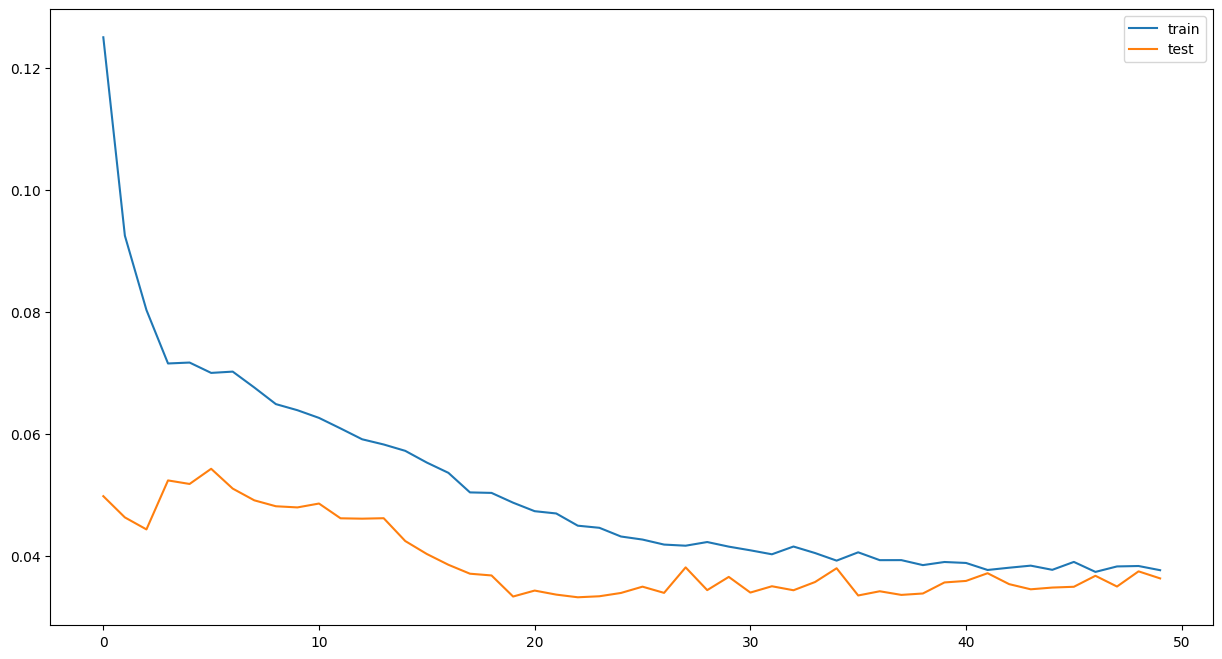

In [101]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Prediction

In [102]:
# make a prediction
pred_y = model_Stacked_biDir_tune.predict(vec_test_X)

8/8 [==============================] - 0s 6ms/step


In [103]:
pred_y[:5]

array([[0.06377207, 0.06866188, 0.06458987, 0.06464659, 0.06778526],
       [0.06524758, 0.06990413, 0.06609179, 0.06663977, 0.06987692],
       [0.06769141, 0.0723678 , 0.06849115, 0.06954426, 0.0729246 ],
       [0.06797229, 0.07270734, 0.06959408, 0.07117821, 0.07412948],
       [0.06726263, 0.07178364, 0.06982181, 0.07143408, 0.07402469]],
      dtype=float32)

In [104]:
pred_y.shape

(232, 5)

## Resacling Prediction

In [105]:
data_pred = test_data.drop(columns=['target_t1','target_t2','target_t3','target_t4','target_t5'],axis=1)

In [106]:
for i in range(0,5):
  data_pred['prediction_t'+str(i)] = pred_y[:,i]

In [107]:
data_pred

,quantity,min_price,max_price,modal_price,feature_t2,feature_t3,feature_t4,feature_t5,feature_t6,feature_t7,...,feature_t27,feature_t28,feature_t29,feature_t30,feature_t31,prediction_t0,prediction_t1,prediction_t2,prediction_t3,prediction_t4
arrival_date,,,,,,,,,,,,,,,,,,,,,
2022-07-23,0.875515,0.067344,0.072551,0.081034,0.111667,0.121667,0.133333,0.133333,0.111667,0.111667,...,0.321667,0.388333,0.421667,0.388333,0.445000,0.063772,0.068662,0.064590,0.064647,0.067785
2022-07-24,0.864548,0.067344,0.081016,0.091379,0.111667,0.111667,0.121667,0.133333,0.133333,0.111667,...,0.311667,0.321667,0.388333,0.421667,0.388333,0.065248,0.069904,0.066092,0.066640,0.069877
2022-07-25,0.804913,0.067344,0.105200,0.081034,0.121667,0.111667,0.111667,0.121667,0.133333,0.133333,...,0.245000,0.311667,0.321667,0.388333,0.421667,0.067691,0.072368,0.068491,0.069544,0.072925
2022-07-26,0.854483,0.067344,0.105200,0.091379,0.111667,0.121667,0.111667,0.111667,0.121667,0.133333,...,0.145000,0.245000,0.311667,0.321667,0.388333,0.067972,0.072707,0.069594,0.071178,0.074129
2022-07-27,0.798577,0.059720,0.096735,0.091379,0.121667,0.111667,0.121667,0.111667,0.111667,0.121667,...,0.121667,0.145000,0.245000,0.311667,0.321667,0.067263,0.071784,0.069822,0.071434,0.074025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.045354,0.085133,0.169287,0.137931,0.200000,0.188333,0.166667,0.166667,0.166667,0.200000,...,0.178333,0.166667,0.155000,0.178333,0.166667,0.160263,0.159989,0.168543,0.157624,0.161762
2023-03-10,0.060756,0.118170,0.193470,0.184483,0.166667,0.200000,0.188333,0.166667,0.166667,0.166667,...,0.200000,0.178333,0.166667,0.155000,0.178333,0.177527,0.176919,0.185015,0.173106,0.177502
2023-03-11,0.065435,0.085133,0.177751,0.172414,0.211667,0.166667,0.200000,0.188333,0.166667,0.166667,...,0.200000,0.200000,0.178333,0.166667,0.155000,0.166552,0.166441,0.173974,0.163284,0.167460


In [108]:
inv_pred_y = scaler.inverse_transform(data_pred)
inv_pred_y = inv_pred_y[:,-5:]

In [109]:
# Display Predicted values
inv_pred_y[:5,]

array([[569.87799108, 598.23892415, 574.62121993, 574.9502033 ,
        593.15452576],
       [578.43596637, 605.44397533, 583.33238661, 586.51064336,
        605.2861169 ],
       [592.61016697, 619.73325312, 597.24864662, 603.35672647,
        622.9626745 ],
       [594.23931092, 621.7025727 , 603.64565104, 612.83363402,
        629.95096743],
       [590.12328088, 616.34510905, 604.96651083, 614.31766748,
        629.34321463]])

## Rescaling Actuals

In [110]:
data_actual= test_data

In [111]:
inv_test_y = scaler.inverse_transform(data_actual)
inv_test_y = inv_test_y[:,-5:]

In [112]:
# Display Actual target values
inv_test_y[:5,]

array([[730., 670., 730., 730., 470.],
       [670., 730., 730., 470., 530.],
       [730., 730., 470., 530., 600.],
       [730., 470., 530., 600., 670.],
       [470., 530., 600., 670., 670.]])

## Comapring Actuals vs Predicted

In [113]:
pred_df = test_data[['quantity']]

In [114]:
for i in range(0,5):
  pred_df['modal_price_actual_t'+str(i+1)] = inv_test_y[:,i]
  pred_df['prediction_t'+str(i+1)] = inv_pred_y[:,i]

In [115]:
pred_df

,quantity,modal_price_actual_t1,prediction_t1,modal_price_actual_t2,prediction_t2,modal_price_actual_t3,prediction_t3,modal_price_actual_t4,prediction_t4,modal_price_actual_t5,prediction_t5
arrival_date,,,,,,,,,,,
2022-07-23,0.875515,730.0,569.877991,670.0,598.238924,730.0,574.621220,730.0,574.950203,470.0,593.154526
2022-07-24,0.864548,670.0,578.435966,730.0,605.443975,730.0,583.332387,470.0,586.510643,530.0,605.286117
2022-07-25,0.804913,730.0,592.610167,730.0,619.733253,470.0,597.248647,530.0,603.356726,600.0,622.962674
2022-07-26,0.854483,730.0,594.239311,470.0,621.702573,530.0,603.645651,600.0,612.833634,670.0,629.950967
2022-07-27,0.798577,470.0,590.123281,530.0,616.345109,600.0,604.966511,670.0,614.317667,670.0,629.343215
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.045354,1270.0,1129.526621,1200.0,1127.934986,1000.0,1177.547649,930.0,1114.217508,870.0,1138.217694
2023-03-10,0.060756,1200.0,1229.657611,1000.0,1226.128030,930.0,1273.087478,870.0,1204.017478,930.0,1229.512501
2023-03-11,0.065435,1000.0,1166.000432,930.0,1165.355515,870.0,1209.047860,930.0,1147.044542,730.0,1171.265116


In [116]:
# Calculate the error
#print("Results of sklearn.metrics:")
#for i in range(1,6):
#  print("MAPE_",i,": %.3f" % mean_absolute_percentage_error(inv_test_y[:,-1*i],inv_pred_y[:,-1*i]))

# Output without the drop NA in features generation

In [117]:
# Calculate the error
error1 = pd.Series()
for i in range(0,5):
  error1['MAPE_'+str(i+1)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred_y[:,i])
print("Results of sklearn.metrics:")
print(error1)

Results of sklearn.metrics:
MAPE_1    0.168178
MAPE_2    0.188506
MAPE_3    0.230066
MAPE_4    0.223211
MAPE_5    0.244918
dtype: float64


In [118]:
model_comparision = pd.DataFrame(data = error1)
model_comparision.rename(columns={0:'LSTM'}, inplace= True)
model_comparision

,LSTM
MAPE_1,0.168178
MAPE_2,0.188506
MAPE_3,0.230066
MAPE_4,0.223211
MAPE_5,0.244918


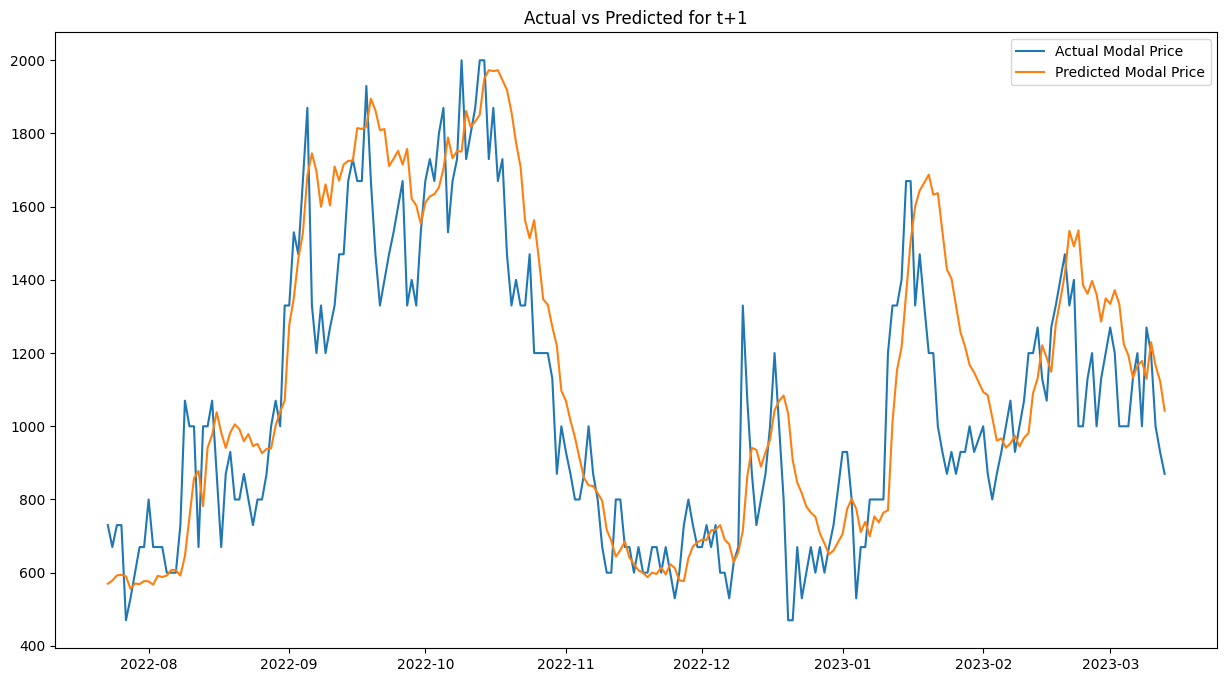

In [119]:
plt.plot(pred_df['modal_price_actual_t1'], label='Actual Modal Price')
plt.plot(pred_df['prediction_t1'],  label='Predicted Modal Price')
plt.legend()
plt.title('Actual vs Predicted for t+1')
plt.show()

# Comparing all models

In [120]:
model_comparision

,LSTM
MAPE_1,0.168178
MAPE_2,0.188506
MAPE_3,0.230066
MAPE_4,0.223211
MAPE_5,0.244918
